In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os.path as op

In [3]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as coords
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp

Using TensorFlow backend.


In [4]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'

In [5]:
refseq = pp.get_refseq( fa_file )

In [6]:
bam1 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test*/*out.wbcs.bam

In [7]:
bam2 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT*/*out.wbcs.bam

In [8]:
bam1

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam']

In [9]:
bam2

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_243_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Hek1053/BB_RT_1_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Cos1053/BB_RT_1_340_335_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Hek1053/BB_RT_1_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_243_Hek1053/BB_RT_1b_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_335_Hek1053/BB_RT_1b_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs

In [10]:
bam = bam1 + bam2

In [11]:
len( bam )

32

In [12]:
msamp_fn = { b.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : b for b in bam }

In [13]:
msamp_fn

{'BB_test_Cos1053_JKLab0340_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_JKLab0340_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam',
 'BB_RT_1_340_243_Cos1053': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_24

In [14]:
msamp_rnabam = { samp: pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [15]:
%%time
#Ugh stop messing with the min_matches thresholds you are wasting so much time
#keep them here for other exons please and thanks
#you keep losing skips
isos_dfs = { samp: jn.get_all_isoforms_pe( msamp_rnabam[ samp ],
                                           [ ( 649, 696 ), ( 3478, 3533 ) ],
                                            spl_tol = 3,
                                            indel_tol = 20,
                                            min_matches_for = 70,
                                            min_matches_rev = 50 )
             for samp in msamp_rnabam }

CPU times: user 37min 11s, sys: 12.3 s, total: 37min 24s
Wall time: 37min 24s


In [16]:
for samp in isos_dfs.keys():
    
    print( samp )
    
    print( isos_dfs[ samp ].head() )

BB_test_Cos1053_JKLab0340_MM1B
                 read_count
isoform                    
((1267, 1359),)     2400975
((1267, 1350),)     2202889
()                  1143438
bad_ends              75036
bad_starts            29333
BB_test_Cos1053_JKLab0340_MM2B
                 read_count
isoform                    
((1267, 1359),)     5054350
((1267, 1350),)     4607597
()                  2304126
bad_starts            82378
bad_ends              59270
BB_test_Cos1053_oligodT_MM1B
                 read_count
isoform                    
((1267, 1359),)     2190614
((1267, 1350),)     1962858
()                  1061553
bad_ends              65799
bad_starts            26372
BB_test_Cos1053_oligodT_MM2B
                 read_count
isoform                    
((1267, 1359),)     6181724
((1267, 1350),)     5733661
()                  3107707
bad_starts            86387
bad_ends              74857
BB_RT_1_340_243_Cos1053
                 read_count
isoform                    
((1267, 1359),) 

In [69]:
isos_dfs

{'BB_test_Cos1053_JKLab0340_MM1B':                               read_count
 isoform                                 
 ((1267, 1359),)                  2400975
 ((1267, 1350),)                  2202889
 ()                               1143438
 bad_ends                           75036
 bad_starts                         29333
 ...                                  ...
 ((1170, 1225), (1288, 1359))           1
 ((1267, 1316), (2646, 2657))           1
 ((1267, 1352), (1520, 1526))           1
 ((1267, 1350), (2235, 2242))           1
 ((1267, 1350), (1506, 1514))           1
 
 [705 rows x 1 columns],
 'BB_test_Cos1053_JKLab0340_MM2B':                               read_count
 isoform                                 
 ((1267, 1359),)                  5054350
 ((1267, 1350),)                  4607597
 ()                               2304126
 bad_starts                         82378
 bad_ends                           59270
 ...                                  ...
 ((1146, 1220), (1297, 

In [17]:
%%time
isogrp_df = jn.number_and_merge_isoforms( isos_dfs )

BB_test_Cos1053_JKLab0340_MM1B
BB_test_Cos1053_JKLab0340_MM2B
BB_test_Cos1053_oligodT_MM1B
BB_test_Cos1053_oligodT_MM2B
BB_RT_1_340_243_Cos1053
BB_RT_1_340_243_Hek1053
BB_RT_1_340_335_Cos1053
BB_RT_1_340_335_Hek1053
BB_RT_1b_340_243_Hek1053
BB_RT_1b_340_335_Hek1053
BB_RT_1b_ODT_243_Hek1053
BB_RT_1b_ODT_335_Hek1053
BB_RT_1_ODT_243_Cos1053
BB_RT_1_ODT_243_Hek1053
BB_RT_1_ODT_335_Cos1053
BB_RT_1_ODT_335_Hek1053
BB_RT_2_340_243_Cos1054
BB_RT_2_340_243_Hek1054
BB_RT_2_340_335_Cos1054
BB_RT_2_340_335_Hek1054
BB_RT_2_ODT_243_Cos1054
BB_RT_2_ODT_243_Hek1054
BB_RT_2_ODT_335_Cos1054
BB_RT_2_ODT_335_Hek1054
BB_RT_3_340_243_Cos1055
BB_RT_3_340_243_Hek1055
BB_RT_3_340_335_Cos1055
BB_RT_3_340_335_Hek1055
BB_RT_3_ODT_243_Cos1055
BB_RT_3_ODT_243_Hek1055
BB_RT_3_ODT_335_cos1055
BB_RT_3_ODT_335_Hek1055
CPU times: user 18.9 s, sys: 16 ms, total: 18.9 s
Wall time: 18.9 s


In [18]:
isogrp_df.head()

isoform  \
isonum                                  
iso0000  ((1136, 1225), (1301, 1350))   
iso0001  ((1267, 1339), (2660, 2664))   
iso0002  ((1267, 1290), (1320, 1350))   
iso0003  ((1267, 1314), (1337, 1359))   
iso0004  ((1267, 1282), (1328, 1359))   

         BB_test_Cos1053_JKLab0340_MM1B_read_count  \
isonum                                               
iso0000                                          0   
iso0001                                          0   
iso0002                                          0   
iso0003                                          1   
iso0004                                          0   

         BB_test_Cos1053_JKLab0340_MM2B_read_count  \
isonum                                               
iso0000                                          0   
iso0001                                          0   
iso0002                                          0   
iso0003                                        273   
iso0004                                          0   

         BB_test_Cos1053_oligodT_MM1B_read_count  \
isonum                                             
iso0000                                        0   
iso0001                                        0   
iso0002                                        0   
iso0003                                        0   
iso0004                                        2   

         BB_test_Cos1053_oligodT_MM2B_read_count  \
isonum                                             
iso0000                                        0   
iso0001                                        0   
iso0002                                        0   
iso0003                                        0   
iso0004                                        0   

         BB_RT_1_340_243_Cos1053_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                   1   
iso0004                                   0   

         BB_RT_1_340_243_Hek1053_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                 127   
iso0004                                   0   

         BB_RT_1_340_335_Cos1053_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                  64   
iso0004                                   0   

         BB_RT_1_340_335_Hek1053_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                  59   
iso0004                                   1   

         BB_RT_1b_340_243_Hek1053_read_count  ...  \
isonum                                        ...   
iso0000                                    0  ...   
iso0001                                    0  ...   
iso0002                                    0  ...   
iso0003                                  140  ...   
iso0004                                    1  ...   

         BB_RT_2_ODT_335_Cos1054_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                   0   
iso0004                                   0   

         BB_RT_2_ODT_335_Hek1054_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0 

In [19]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1359),) ]

isoform  BB_test_Cos1053_JKLab0340_MM1B_read_count  \
isonum                                                                
iso2658  ((1267, 1359),)                                    2400975   

         BB_test_Cos1053_JKLab0340_MM2B_read_count  \
isonum                                               
iso2658                                    5054350   

         BB_test_Cos1053_oligodT_MM1B_read_count  \
isonum                                             
iso2658                                  2190614   

         BB_test_Cos1053_oligodT_MM2B_read_count  \
isonum                                             
iso2658                                  6181724   

         BB_RT_1_340_243_Cos1053_read_count  \
isonum                                        
iso2658                             1852418   

         BB_RT_1_340_243_Hek1053_read_count  \
isonum                                        
iso2658                             3409650   

         BB_RT_1_340_335_Cos1053_read_count  \
isonum                                        
iso2658                              499731   

         BB_RT_1_340_335_Hek1053_read_count  \
isonum                                        
iso2658                             1003786   

         BB_RT_1b_340_243_Hek1053_read_count  ...  \
isonum                                        ...   
iso2658                              3096744  ...   

         BB_RT_2_ODT_335_Cos1054_read_count  \
isonum                                        
iso2658                              148022   

         BB_RT_2_ODT_335_Hek1054_read_count  \
isonum                                        
iso2658                              670847   

         BB_RT_3_340_243_Cos1055_read_count  \
isonum                                        
iso2658                              935423   

         BB_RT_3_340_243_Hek1055_read_count  \
isonum                                        
iso2658                             2235303   

         BB_RT_3_340_335_Cos1055_read_count  \
isonum                                        
iso2658                              642084   

         BB_RT_3_340_335_Hek1055_read_count  \
isonum                                        
iso2658                             1424797   

         BB_RT_3_ODT_243_Cos1055_read_count  \
isonum                                        
iso2658                             2636654   

         BB_RT_3_ODT_243_Hek1055_read_count  \
isonum                                        
iso2658                             1605049   

         BB_RT_3_ODT_335_cos1055_read_count  \
isonum                                        
iso2658                              768588   

         BB_RT_3_ODT_335_Hek1055_read_count  
isonum                                       
iso2658                             1088778  

[1 rows x 33 columns]

In [20]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1350),) ]

isoform  BB_test_Cos1053_JKLab0340_MM1B_read_count  \
isonum                                                                
iso1373  ((1267, 1350),)                                    2202889   

         BB_test_Cos1053_JKLab0340_MM2B_read_count  \
isonum                                               
iso1373                                    4607597   

         BB_test_Cos1053_oligodT_MM1B_read_count  \
isonum                                             
iso1373                                  1962858   

         BB_test_Cos1053_oligodT_MM2B_read_count  \
isonum                                             
iso1373                                  5733661   

         BB_RT_1_340_243_Cos1053_read_count  \
isonum                                        
iso1373                             1642915   

         BB_RT_1_340_243_Hek1053_read_count  \
isonum                                        
iso1373                             3029467   

         BB_RT_1_340_335_Cos1053_read_count  \
isonum                                        
iso1373                              457547   

         BB_RT_1_340_335_Hek1053_read_count  \
isonum                                        
iso1373                              943894   

         BB_RT_1b_340_243_Hek1053_read_count  ...  \
isonum                                        ...   
iso1373                              2728074  ...   

         BB_RT_2_ODT_335_Cos1054_read_count  \
isonum                                        
iso1373                              132018   

         BB_RT_2_ODT_335_Hek1054_read_count  \
isonum                                        
iso1373                              644707   

         BB_RT_3_340_243_Cos1055_read_count  \
isonum                                        
iso1373                              854764   

         BB_RT_3_340_243_Hek1055_read_count  \
isonum                                        
iso1373                             1928910   

         BB_RT_3_340_335_Cos1055_read_count  \
isonum                                        
iso1373                              607919   

         BB_RT_3_340_335_Hek1055_read_count  \
isonum                                        
iso1373                             1469642   

         BB_RT_3_ODT_243_Cos1055_read_count  \
isonum                                        
iso1373                             2365654   

         BB_RT_3_ODT_243_Hek1055_read_count  \
isonum                                        
iso1373                             1373452   

         BB_RT_3_ODT_335_cos1055_read_count  \
isonum                                        
iso1373                              730185   

         BB_RT_3_ODT_335_Hek1055_read_count  
isonum                                       
iso1373                             1190025  

[1 rows x 33 columns]

In [21]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.all.txt

In [22]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [23]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [24]:
exonbed = pbt.BedTool( '/nfs/kitzman2/smithcat/proj/wt1_2022/refs/wt1_ex9.bed' )

In [25]:
isos = jn.make_junction_graph( exonbed )

In [26]:
isos

{'iso00': ((650, 696), (1267, 1350), (3479, 3533)),
 'iso01': ((650, 696), (1267, 1359), (3479, 3533)),
 'iso02': ((650, 696), (3479, 3533))}

In [27]:
unique_jns = list( { jn for grp,jn_tups in isos.items() for jn_tup in jn_tups for jn in jn_tup
                       if 696 < jn < 3479 } ) 

In [28]:
unique_jns

[1267, 1350, 1359]

In [30]:
for lib in satbl_fn:
    
    print( lib )
    
    print( satbl_fn[ lib ].head() )

JKP1053
                         passes                              status  \
readgroupid                                                           
AAAAAAAATCACGACCCTCCTGG   False  possible_chimeric_no_major_variant   
AAAAAAAGGGCTTCCGGGTATGG    True                   no_variants_input   
AAAAAAAGGGTTCCAGACTGTGG   False                     toomanymajorvar   
AAAAAAAGTAGTCTGGTGTGTGG    True                                pass   
AAAAAAATACCCCGGATGATTGG   False  possible_chimeric_no_major_variant   

                         n_variants_passing  \
readgroupid                                   
AAAAAAAATCACGACCCTCCTGG                   6   
AAAAAAAGGGCTTCCGGGTATGG                   0   
AAAAAAAGGGTTCCAGACTGTGG                   2   
AAAAAAAGTAGTCTGGTGTGTGG                   1   
AAAAAAATACCCCGGATGATTGG                   1   

                                                              variant_list  
readgroupid                                                                 
AAAAAAAATC

In [70]:
isogrp_df

isoform  \
isonum                                                
iso0000                ((1136, 1225), (1301, 1350))   
iso0001                ((1267, 1339), (2660, 2664))   
iso0002                ((1267, 1290), (1320, 1350))   
iso0003                ((1267, 1314), (1337, 1359))   
iso0004                ((1267, 1282), (1328, 1359))   
...                                             ...   
iso7347                ((1161, 1228), (1308, 1350))   
iso7348                ((1236, 1242), (1266, 1350))   
iso7349                ((1146, 1222), (1281, 1359))   
iso7350                             ((1284, 1348),)   
iso7351  ((1267, 1306), (1563, 1568), (2040, 2045))   

         BB_test_Cos1053_JKLab0340_MM1B_read_count  \
isonum                                               
iso0000                                          0   
iso0001                                          0   
iso0002                                          0   
iso0003                                          1   
iso0004                                          0   
...                                            ...   
iso7347                                          0   
iso7348                                          0   
iso7349                                          0   
iso7350                                          0   
iso7351                                          0   

         BB_test_Cos1053_JKLab0340_MM2B_read_count  \
isonum                                               
iso0000                                          0   
iso0001                                          0   
iso0002                                          0   
iso0003                                        273   
iso0004                                          0   
...                                            ...   
iso7347                                          0   
iso7348                                          0   
iso7349                                          0   
iso7350                                          1   
iso7351                                          0   

         BB_test_Cos1053_oligodT_MM1B_read_count  \
isonum                                             
iso0000                                        0   
iso0001                                        0   
iso0002                                        0   
iso0003                                        0   
iso0004                                        2   
...                                          ...   
iso7347                                        0   
iso7348                                        0   
iso7349                                        0   
iso7350                                        0   
iso7351                                        0   

         BB_test_Cos1053_oligodT_MM2B_read_count  \
isonum                                             
iso0000                                        0   
iso0001                                        0   
iso0002                                        0   
iso0003                                        0   
iso0004                                        0   
...                                          ...   
iso7347                                        0   
iso7348                                        0   
iso7349                                        0   
iso7350                                        0   
iso7351                                        0   

         BB_RT_1_340_243_Cos1053_read_count  \
isonum                                        
iso0000                                   0   
iso0001                                   0   
iso0002                                   0   
iso0003                                   1   
iso0004                                   0   
...                                     ...   
iso7347                                   0   
iso7348                                   0   
iso7349                                   0   
iso7350                                   0   
iso7

In [74]:
msamp_rnabam = { samp : pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [75]:
%%time
#1 min/sample

iso_df_stats = { lib: jn.summarize_isos_by_var_bc_pe( { samp: bam for samp,bam in msamp_rnabam.items()
                                                        if lib.replace( 'JKP', '' ) in samp },
                                                      [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                      satbl_fn[ lib ],
                                                      isogrp_df[ [ col for col in isogrp_df if lib.replace( 'JKP', '' ) in col or col == 'isoform' ] ],
                                                      unique_jns,
                                                      [ ( ( 1266, 1350 ), ), ( ( 1266, 1359 ), ), () ],
                                                      spl_tol = 3,
                                                      indel_tol = 20,
                                                      min_matches_for = 70,
                                                      min_matches_rev = 50,
                                                      bc_tag = 'BC',
                                                     ) 
                  for lib in satbl_fn }

BB_test_Cos1053_JKLab0340_MM1B
Barcodes processed: 18000
Reads processed: 604129
Barcodes processed: 31000
Reads processed: 1017564
Barcodes processed: 34000
Reads processed: 1108315
Barcodes processed: 36000
Reads processed: 1178178
Barcodes processed: 43000
Reads processed: 1409370
Barcodes processed: 57000
Reads processed: 1857679
Barcodes processed: 63000
Reads processed: 2036886
Barcodes processed: 65000
Reads processed: 2098114
Barcodes processed: 67000
Reads processed: 2165337
Barcodes processed: 69000
Reads processed: 2237371
Barcodes processed: 73000
Reads processed: 2363659
Barcodes processed: 76000
Reads processed: 2464083
Barcodes processed: 96000
Reads processed: 3151312
Barcodes processed: 105000
Reads processed: 3429697
Barcodes processed: 117000
Reads processed: 3827139
Barcodes processed: 122000
Reads processed: 3981667
Barcodes processed: 127000
Reads processed: 4140347
Barcodes processed: 131000
Reads processed: 4266740
Barcodes processed: 132000
Reads processed: 429

For isoform: ((1273, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1384:A:T', 2), ('jkp815:1229:TT:AG,jkp815:1231:G:T,jkp815:1234:AGGGCCGA:AGGCCGA,jkp815:1249:C:G,jkp815:1315:C:G,jkp815:1397:T:C', 1), ('jkp815:1253:C:T', 1), ('jkp815:1261:A:T', 1), ('jkp815:1321:A:C', 1)]
For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 3), ('jkp815:1317:G:T', 2), ('jkp815:1265:AGGTGTGA:AGTGTGA', 2), ('jkp815:1387:T:A', 2), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1352:T:G', 2)]
For isoform: ((1267, 1289), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:AACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:AA', 2), ('jkp815:1245:T:A', 1), ('jkp815:1267:GTG:GG,jkp815:1297:A:T,jkp815:1309:C:G,jkp815:1366:A:G', 1), ('jkp815:1332:C:G', 1), ('jkp815:1222:GCCCACAT:GCCACAT', 1)]
For isoform: ((1299, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 2), ('jkp815:1228:A:C', 2), ('j

For isoform: ((1248, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1350:G:C', 1), ('jkp815:1256:T:C,jkp815:1299:C:G', 1), ('jkp815:1226:ACA:AA', 1), ('jkp815:1227:C:T,jkp815:1398:T:C', 1), ('jkp815:1240:G:C,jkp815:1283:G:T', 1)]
For isoform: ((1267, 1351), (1518, 1526))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAAAACAAG', 1)]
For isoform: ((1267, 1355), (2041, 2045))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAAAACAAG', 1)]
For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 2), ('jkp815:1228:A:G', 2), ('jkp815:1366:A:C', 2), ('jkp815:1318:A:T', 2), ('jkp815:1345:A:G', 2)]
For isoform: ((1267, 1355), (2222, 2227))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAAAACAAG', 1), ('jkp815:1298:G:T,jkp815:1308:TCCCGGT:TCCGGT,jkp815:1352:TAAAACAAG:TAAAAACAAG', 1)]
For isoform: ((1273, 1359),)
The variant

For isoform: ((1146, 1222), (1280, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1325:G:T', 1), ('jkp815:1218:C:T', 1), ('jkp815:1252:T:C', 1)]
For isoform: ((1161, 1220), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:CTAGACCTTCTCTGTCCATTTAGGTGTGAAACCATTCCAGTG:CG', 1), ('jkp815:1378:A:C', 1)]
For isoform: ((1236, 1252), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:C', 1), ('jkp815:1329:A:G,jkp815:1339:G:T', 1), ('jkp815:1255:C:A', 1), ('jkp815:1322:C:G', 1), ('jkp815:1345:A:C,jkp815:1374:C:T', 1)]
For isoform: ((1267, 1303), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:T', 1), ('jkp815:1277:ATTCC:ATCC', 1)]
For isoform: ((1267, 1303), (1323, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:T', 1), ('jkp815:1294:G:T', 1), ('jkp815:1235:G:A', 1), ('jkp815:1364:G:T', 1), ('jkp815:1366:A:T', 1)]
For isoform: ((1161, 1228), (1314, 1

For isoform: ((1258, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1283:G:A', 1)]
For isoform: ((1236, 1241), (1285, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:G', 1)]
For isoform: ((1267, 1279), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:T', 1)]
For isoform: ((1267, 3375),)
The variants with the top 5 number of barcodes are:
[('jkp815:1373:T:C', 1)]
For isoform: ((1146, 1224), (1302, 1317), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1271:G:C', 1)]
For isoform: ((1267, 1352), (2979, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1354:A:G', 1), ('jkp815:1354:A:G', 1)]
For isoform: ((1236, 1253), (1284, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 1)]
For isoform: ((1267, 1693),)
The variants with the top 5 numbe

BB_test_Cos1053_JKLab0340_MM2B
Barcodes processed: 40000
Reads processed: 1690337
Barcodes processed: 74000
Reads processed: 3047802
Barcodes processed: 88000
Reads processed: 3593450
Barcodes processed: 124000
Reads processed: 5027740
Barcodes processed: 133000
Reads processed: 5415713
Barcodes processed: 149000
Reads processed: 6097844
Barcodes processed: 176000
Reads processed: 7185221
Barcodes processed: 198000
Reads processed: 8084480
Barcodes processed: 202000
Reads processed: 8234684
Barcodes processed: 213000
Reads processed: 8660130
Barcodes processed: 223000
Reads processed: 9025860
Barcodes processed: 263000
Reads processed: 10580916
Barcodes processed: 271000
Reads processed: 10867115
Barcodes processed: 277000
Reads processed: 11089194
Barcodes processed: 285000
Reads processed: 11377119
Barcodes processed: 288000
Reads processed: 11480083
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 206), ('jkp815:1227:C:T', 178), (

For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 7), ('jkp815:1227:C:A', 6), ('jkp815:1228:A:T', 5), ('jkp815:1324:T:C', 5), ('jkp815:1358:A:G', 5)]
For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 5), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1386:T:C', 5), ('jkp815:1330:C:G', 5), ('jkp815:1228:A:G', 4), ('jkp815:1282:A:C', 4)]
For isoform: ((1190, 1224), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:T', 1), ('jkp815:1278:T:C,jkp815:1333:A:G,jkp815:1389:T:A', 1), ('jkp815:1311:C:T', 1), ('jkp815:1312:G:T', 1), ('jkp815:1373:TCT:TT,jkp815:1386:T:G', 1)]
For isoform: ((1190, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1388:T:C', 1), ('jkp815:1362:G:A', 1), ('jkp815:1266:G:T,jkp815:1314:T:G', 1), ('jkp815:1227:C:T,jkp815:1368:A:C', 1), ('jkp815:1349:A:T', 1)]
For isoform: ((1291, 1359),)
The variants with the top

For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 3), ('jkp815:1227:C:G,jkp815:1278:T:G,jkp815:1328:G:C,jkp815:1379:C:A', 1), ('jkp815:1223:CCCACATTGTTAGGGC:CC,jkp815:1276:C:T', 1), ('jkp815:1308:T:G', 1), ('jkp815:1250:CTTCTCTG:CTCTTG,jkp815:1286:T:C', 1)]
For isoform: ((1267, 1274), (1315, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1), ('jkp815:1227:C:G', 1), ('jkp815:1228:A:C', 1), ('jkp815:1344:C:A', 1), ('jkp815:1228:ATTGTTA:ATGTTA', 1)]
For isoform: ((1267, 1293), (1328, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:G:A,jkp815:1341:A:C,jkp815:1345:ATA:ACTGTG,jkp815:1348:CAGGTAAAA:CC', 1), ('jkp815:1311:C:T', 1), ('jkp815:1227:CATTGTTAGGGCCGAGG:CG,jkp815:1272:A:C', 1), ('jkp815:1288:A:T,jkp815:1354:A:C', 1)]
For isoform: ((1267, 1317), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C', 1), ('jkp815:1228:A:C', 1), ('jkp815:1228:A:C

For isoform: ((1190, 1225), (1302, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:G', 1), ('jkp815:1308:T:C', 1), ('jkp815:1391:A:C', 1), ('jkp815:1317:G:T', 1), ('jkp815:1267:G:A,jkp815:1371:T:A', 1)]
For isoform: ((1146, 1227), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 2), ('jkp815:1227:C:T,jkp815:1381:T:A', 1), ('jkp815:1282:A:G,jkp815:1286:T:G', 1), ('jkp815:1247:G:T', 1), ('jkp815:1356:A:G', 1)]
For isoform: ((1267, 1353), (2041, 2045))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAACAAG', 2)]
For isoform: ((1267, 1298), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 1), ('jkp815:1267:G:T', 1), ('jkp815:1297:A:T', 1), ('jkp815:1374:C:T', 1)]
For isoform: ((1267, 1334), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1229:T:G,jkp815:1363:C

For isoform: ((1136, 1227), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:C:A,jkp815:1342:C:T', 1), ('jkp815:1227:C:A', 1), ('jkp815:1377:C:G', 1), ('jkp815:1375:T:A', 1), ('jkp815:1358:A:C', 1)]
For isoform: ((1267, 1353), (3376, 3381))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:T', 1)]
For isoform: ((879, 884), (1275, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:G,jkp815:1354:A:T', 1), ('jkp815:1274:A:G,jkp815:1330:C:A', 1)]
For isoform: ((1267, 1664),)
The variants with the top 5 number of barcodes are:
[('jkp815:1325:G:T', 1), ('jkp815:1257:G:C,jkp815:1331:C:G', 1)]
For isoform: ((1236, 1350), (2391, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A', 1)]
For isoform: ((1152, 1224), (1287, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:C', 1), ('jkp815:1308:T:C', 1), ('jkp815:1338:A:C,jkp815:1347:A:T', 1), ('jkp815:1375:T:C', 1), ('jkp

For isoform: ((1236, 1247), (1273, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1375:T:A', 1), ('jkp815:1364:G:T', 1), ('jkp815:1304:G:T,jkp815:1312:G:C,jkp815:1328:G:A,jkp815:1360:G:T', 1), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1280:C:G', 1), ('jkp815:1283:G:T', 1)]
For isoform: ((1267, 2591),)
The variants with the top 5 number of barcodes are:
[('jkp815:1301:A:G,jkp815:1343:T:A,jkp815:1362:G:A', 1), ('jkp815:1311:C:T,jkp815:1349:A:C', 1)]
For isoform: ((1161, 1228), (1293, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:T:C', 1), ('jkp815:1227:C:G', 1), ('jkp815:1305:T:A,jkp815:1317:G:T,jkp815:1321:A:C', 1)]
For isoform: ((1236, 1242), (1294, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:T,jkp815:1360:G:T', 1)]
For isoform: ((1236, 1266), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A', 1), ('jkp815:1366:A:G', 1), ('jkp815:1227:C:A,jkp815:1285:G:A', 1), ('jkp815:1386

BB_test_Cos1053_oligodT_MM1B
Barcodes processed: 2000
Reads processed: 58062
Barcodes processed: 4000
Reads processed: 124198
Barcodes processed: 10000
Reads processed: 291743
Barcodes processed: 11000
Reads processed: 321992
Barcodes processed: 14000
Reads processed: 412561
Barcodes processed: 21000
Reads processed: 610726
Barcodes processed: 30000
Reads processed: 867598
Barcodes processed: 39000
Reads processed: 1120666
Barcodes processed: 40000
Reads processed: 1150290
Barcodes processed: 44000
Reads processed: 1263391
Barcodes processed: 52000
Reads processed: 1479012
Barcodes processed: 53000
Reads processed: 1507713
Barcodes processed: 55000
Reads processed: 1561385
Barcodes processed: 70000
Reads processed: 1972293
Barcodes processed: 73000
Reads processed: 2060823
Barcodes processed: 74000
Reads processed: 2090132
Barcodes processed: 75000
Reads processed: 2119083
Barcodes processed: 82000
Reads processed: 2329195
Barcodes processed: 91000
Reads processed: 2604835
Barcodes pro

For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 8), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1309:C:G,jkp815:1360:G:A', 7), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 6), ('jkp815:1250:C:A', 5), ('jkp815:1323:C:T', 5)]
For isoform: ((1305, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1375:T:A', 1), ('jkp815:1309:C:T', 1), ('jkp815:1253:C:T', 1), ('jkp815:1295:T:A,jkp815:1359:A:T', 1), ('jkp815:1357:CAAGT:CAAAGT', 1)]
For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 7), ('jkp815:1267:GTG:GG,jkp815:1365:T:C', 5), ('jkp815:1228:A:G', 4), ('jkp815:1227:C:T', 4), ('jkp815:1366:A:T', 3)]
For isoform: ((1269, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 12), ('jkp815:1227:C:G', 6), ('jkp815:1227:C:A', 4), ('jkp815:1362:G:A', 4), ('jkp815:1228:A:C', 4)]
For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 num

For isoform: ((1236, 1250), (1284, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G', 2), ('jkp815:1233:T:C,jkp815:1305:T:C,jkp815:1354:A:C', 1), ('jkp815:1330:C:T', 1), ('jkp815:1263:T:C', 1), ('jkp815:1237:G:T,jkp815:1373:T:C', 1)]
For isoform: ((1152, 1225), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1223:CCCACATTGTTAGGGC:CC,jkp815:1276:C:T', 1), ('jkp815:1351:G:C', 1), ('jkp815:1223:C:T,jkp815:1253:C:A,jkp815:1304:G:C,jkp815:1321:A:T', 1)]
For isoform: ((1285, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1), ('jkp815:1251:T:C', 1), ('jkp815:1329:A:G', 1), ('jkp815:1279:T:C', 1), ('jkp815:1373:TCT:TT,jkp815:1386:T:G', 1)]
For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 3), ('jkp815:1340:G:A', 1), ('jkp815:1227:C:G,jkp815:1338:AGGAC:AGAC,jkp815:1380:ATTTATTTTTCA:ATTATTTTTCA', 1), ('jkp815:1239:C:A', 1), ('jkp815:1266:G:C'

For isoform: ((1267, 1693),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:CACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 2714),)
The variants with the top 5 number of barcodes are:
[('jkp815:1255:C:T,jkp815:1285:G:T', 1)]
For isoform: ((1267, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:G', 1), ('jkp815:1346:TAC:TAAC,jkp815:1395:T:G', 1)]
For isoform: ((1161, 1222), (1291, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:G', 1), ('jkp815:1298:G:T,jkp815:1323:C:G', 1), ('jkp815:1380:A:C', 1), ('jkp815:1327:A:T', 1), ('jkp815:1346:T:C', 1)]
For isoform: ((1161, 1241), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:A:G', 1), ('jkp815:1303:A:C,jkp815:1351:G:A', 1), ('jkp815:1363:C:T', 1), ('jkp815:1237:G:T', 1)]
For isoform: ((1267, 1340), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:A:G', 1)]
For isoform: ((1255, 1359),)
The variants 

For isoform: ((1267, 1327), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:A', 1), ('jkp815:1260:C:A', 1), ('jkp815:1321:A:T', 1), ('jkp815:1374:C:A', 1), ('jkp815:1279:T:A', 1)]
For isoform: ((1170, 1222), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:T', 1), ('jkp815:1319:C:G', 1), ('jkp815:1256:T:G', 1), ('jkp815:1308:T:G,jkp815:1313:G:T,jkp815:1352:T:C', 1), ('jkp815:1390:C:T,jkp815:1394:A:T', 1)]
For isoform: ((1267, 1336), (1469, 1475), (2041, 2045))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:G,jkp815:1384:ATTTTTCA:ATTTTCA', 1)]
For isoform: ((1146, 1223), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG,jkp815:1359:A:G,jkp815:1378:A:C', 1), ('jkp815:1252:T:A', 1), ('jkp815:1227:C:A', 1), ('jkp815:1225:CAC:CC,jkp815:1237:G:C,jkp815:1239:C:A,jkp815:1240:GAGGCTA:GA,jkp815:1249:C:T,jkp815:1251:T:G,jkp815:1252:TCTCTGTCC:TC', 1), ('jkp815:1268:T:G,j

For isoform: ((1146, 1222), (1294, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:G,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CTGAAGACCCACACTAGGACTCATACAGGTA', 1)]
For isoform: ((1267, 1352), (1520, 1526))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:C', 1)]
For isoform: ((1267, 1344), (1368, 1636))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:TGT:TT', 1), ('jkp815:1349:A:T', 1), ('jkp815:1335:A:C', 1)]
For isoform: ((1136, 1141), (1274, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1269, 2601),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1267, 1350), (2790, 2794))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1267, 1332), (1635, 1645))
The variants with the top 5 number of barcodes are:
[('jkp81

Barcodes processed: 74000
Reads processed: 2807852
Barcodes processed: 84000
Reads processed: 3201411
Barcodes processed: 102000
Reads processed: 3856460
Barcodes processed: 105000
Reads processed: 3961679
Barcodes processed: 139000
Reads processed: 5154921
Barcodes processed: 157000
Reads processed: 5824524
Barcodes processed: 164000
Reads processed: 6075778
Barcodes processed: 197000
Reads processed: 7377230
Barcodes processed: 206000
Reads processed: 7729290
Barcodes processed: 242000
Reads processed: 9029044
Barcodes processed: 253000
Reads processed: 9463264
Barcodes processed: 277000
Reads processed: 10314245
Barcodes processed: 324000
Reads processed: 11958856
Barcodes processed: 350000
Reads processed: 12873460
Barcodes processed: 363000
Reads processed: 13327014
Barcodes processed: 368000
Reads processed: 13495906
Barcodes processed: 409000
Reads processed: 14865320
Barcodes processed: 428000
Reads processed: 15438128
For isoform: ((1267, 1350),)
The variants with the top 5 nu

For isoform: ((1267, 1273), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 5), ('jkp815:1227:C:T', 4), ('jkp815:1362:G:T', 4), ('jkp815:1358:A:C', 3), ('jkp815:1228:A:T', 3)]
For isoform: ((1267, 1274), (1315, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:C', 1), ('jkp815:1237:G:A,jkp815:1284:T:C', 1), ('jkp815:1257:G:C,jkp815:1331:C:G', 1), ('jkp815:1344:C:A', 1), ('jkp815:1285:G:C', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 4), ('jkp815:1228:A:T', 4), ('jkp815:1312:G:C', 3), ('jkp815:1237:G:A', 3), ('jkp815:1292:T:G', 3)]
For isoform: ((1299, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1327:A:T', 4), ('jkp815:1227:CAT:CT', 3), ('jkp815:1335:A:C', 3), ('jkp815:1397:T:G', 3), ('jkp815:1373:T:G', 2)]
For isoform: ((1267, 1329),)
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1

For isoform: ((1267, 1293), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1269:G:A', 2), ('jkp815:1376:T:A', 2), ('jkp815:1368:A:C', 2), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 2), ('jkp815:1281:C:G', 2)]
For isoform: ((1190, 1243), (1265, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:G,jkp815:1392:T:C', 1), ('jkp815:1228:A:T,jkp815:1350:G:A', 1), ('jkp815:1114:TGGGGGAC:TGGGGAC,jkp815:1271:G:A', 1), ('jkp815:1253:C:A', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1236, 1256), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:G,jkp815:1392:T:C', 1), ('jkp815:1278:T:C', 1), ('jkp815:1226:ACATTGTTA:AA', 1), ('jkp815:1303:A:C,jkp815:1334:C:G,jkp815:1363:C:T', 1), ('jkp815:1288:A:T', 1)]
For isoform: ((1236, 1241), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:G,jkp815:1392:T:C', 1), ('jkp815:1227:C:T', 1), ('jkp815:1253:C:G,jkp815:1323:CTGAAG

For isoform: ((1146, 1227), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1358:A:C', 1), ('jkp815:1241:AGGCT:AGGGCT,jkp815:1365:T:C', 1), ('jkp815:1227:C:T,jkp815:1359:A:T', 1), ('jkp815:1307:C:A', 1), ('jkp815:1287:A:T', 1)]
For isoform: ((1277, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1227:C:G,jkp815:1359:A:C', 1), ('jkp815:1238:C:G,jkp815:1367:A:C', 1), ('jkp815:1360:G:T', 1), ('jkp815:1297:A:C', 1)]
For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1372:T:C', 1), ('jkp815:1257:G:T,jkp815:1369:C:T', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1190, 1222), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1228:A:C', 1), ('jkp815:1256:T:G,jkp815:1371:T:A', 1), ('jkp815:1238:C:G', 1), ('jkp815:1241:AGGCT:AGGGCT,jkp815:1241:AGGCT:AGACT,jkp815:1365:T:C', 1)]
For isoform: ((1267, 12

For isoform: ((1236, 1253), (1284, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1328:G:T', 1), ('jkp815:1296:C:A,jkp815:1311:C:G', 1), ('jkp815:1373:TCT:TT,jkp815:1386:T:G', 1), ('jkp815:1398:T:A', 1), ('jkp815:1237:G:A', 1)]
For isoform: ((1152, 1224), (1307, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:C', 2), ('jkp815:1284:T:A', 1), ('jkp815:1307:C:G', 1), ('jkp815:1328:G:T', 1), ('jkp815:1225:CAC:CC,jkp815:1362:G:A', 1)]
For isoform: ((1267, 1337), (2927, 2938))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G,jkp815:1345:ATA:AA', 1)]
For isoform: ((1267, 1337), (1581, 1589))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G,jkp815:1345:ATA:AA', 1)]
For isoform: ((1267, 1340), (3269, 3274))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G,jkp815:1345:ATA:AA', 1)]
For isoform: ((1267, 1303), (1332, 1359))
The variants with the top 5 number of barcodes are:
[('jkp81

The variants with the top 5 number of barcodes are:
[('jkp815:1373:T:G', 1), ('jkp815:1368:A:T', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1293, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:A', 1), ('jkp815:1351:G:T', 1), ('jkp815:1335:A:C', 1), ('jkp815:1354:A:G', 1)]
For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1), ('jkp815:1335:A:G', 1), ('jkp815:1344:CATA:CA,jkp815:1351:G:C', 1), ('jkp815:1288:A:C,jkp815:1306:T:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1), ('jkp815:1244:C:A,jkp815:1257:G:T,jkp815:1313:G:T,jkp815:1383:T:A', 1)]
For isoform: ((1267, 2591),)
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 2), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1338:AGGAC:AGGGAC', 1)]
For isoform: ((1267, 2227),)
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:C,j

For isoform: ((1270, 1341), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1341:ACTCATACAGGTA:AA', 1)]
For isoform: ((1266, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C', 1)]
For isoform: ((1267, 1328), (3348, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:T,jkp815:1328:GACCCACACCAGGACTCATACAGGTAA:GA', 1)]
For isoform: ((1267, 1321), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1348), (1551, 1557))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1323), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T,jkp815:1314:T:A', 1)]
For isoform: ((1267, 1320), (1963, 1969))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:TGT:TT,jkp815:1396:T:A', 1)]
For isoform: ((1146, 1227), (1306, 1326), (1327, 1359))
The variants with the top 5 numbe

Barcodes processed: 3000
Reads processed: 59376
Barcodes processed: 12000
Reads processed: 240831
Barcodes processed: 15000
Reads processed: 296284
Barcodes processed: 16000
Reads processed: 316475
Barcodes processed: 30000
Reads processed: 599798
Barcodes processed: 38000
Reads processed: 753820
Barcodes processed: 42000
Reads processed: 828900
Barcodes processed: 44000
Reads processed: 867197
Barcodes processed: 51000
Reads processed: 1002863
Barcodes processed: 55000
Reads processed: 1078691
Barcodes processed: 56000
Reads processed: 1097951
Barcodes processed: 59000
Reads processed: 1155380
Barcodes processed: 64000
Reads processed: 1252066
Barcodes processed: 65000
Reads processed: 1270594
Barcodes processed: 71000
Reads processed: 1384117
Barcodes processed: 73000
Reads processed: 1423575
Barcodes processed: 76000
Reads processed: 1487172
Barcodes processed: 77000
Reads processed: 1507781
Barcodes processed: 84000
Reads processed: 1637673
Barcodes processed: 86000
Reads processed

For isoform: ((1270, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1268:TGT:TT,jkp815:1276:C:T', 7), ('jkp815:1268:TGT:TT,jkp815:1305:T:C', 4), ('jkp815:1360:G:C', 1), ('jkp815:1355:A:T,jkp815:1360:G:A', 1), ('jkp815:1389:T:A', 1)]
For isoform: ((1285, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGT:TG,jkp815:1237:GCCGA:GCGA,jkp815:1246:AGA:AA,jkp815:1250:CTTCTCTG:CCTG,jkp815:1283:GTG:GG', 3), ('jkp815:1279:T:G', 1), ('jkp815:1330:C:A', 1), ('jkp815:1390:C:T,jkp815:1394:A:C', 1), ('jkp815:1329:A:G', 1)]
For isoform: ((1212, 1228), (1263, 1349))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C,jkp815:1309:C:G', 1)]
For isoform: ((1267, 1303), (1332, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1323:C:T,jkp815:1350:G:A', 1), ('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1381:T:G', 1), ('jkp815:1228:A:G,jkp815:1386:T:A', 1), ('jkp815:1224:CCAC:C

For isoform: ((1236, 1245), (1281, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1388:T:C', 1), ('jkp815:1358:A:G', 1), ('jkp815:1225:CAC:CC', 1), ('jkp815:1296:C:G,jkp815:1303:A:C', 1), ('jkp815:1299:C:T', 1)]
For isoform: ((1267, 1343), (1736, 1740))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TAC:TGAC', 1)]
For isoform: ((1267, 1341), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1355:A:G', 1), ('jkp815:1227:C:G,jkp815:1341:ACTCATACAGGTA:AA', 1), ('jkp815:1392:T:C', 1), ('jkp815:1255:C:G,jkp815:1341:ACTCATACAGGTA:AA', 1), ('jkp815:1246:A:C,jkp815:1341:ACTCATACAGGTA:AA', 1)]
For isoform: ((1267, 1302), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1302:AAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:AA,jkp815:1344:C:A', 2), ('jkp815:1275:C:T,jkp815:1335:A:C,jkp815:1372:T:G', 1), ('jkp815:1227:C:A', 1), ('jkp815:1240:G:C,jkp815:1369:C:T', 1), ('jkp815:1255:C:G', 1)]
For isoform: ((1236, 1262),

For isoform: ((1267, 1287), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:T,jkp815:1291:C:A', 1), ('jkp815:1225:C:T,jkp815:1319:C:A', 1)]
For isoform: ((1161, 1225), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1347:A:G', 1)]
For isoform: ((1267, 1319), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1362:G:A', 1)]
For isoform: ((1255, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:ATTCC:ATCC', 1), ('jkp815:1313:G:T,jkp815:1348:C:A', 1), ('jkp815:1240:G:A,jkp815:1340:G:C', 1), ('jkp815:1363:C:A', 1), ('jkp815:1235:GGGCCGAGGCTAGACCTTCTC:GC,jkp815:1269:G:A,jkp815:1340:G:C', 1)]
For isoform: ((1267, 1350), (3237, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:T,jkp815:1300:GAAAGT:GAAGT,jkp815:1335:A:T,jkp815:1350:GGTAA:GA', 1)]
For isoform: ((876, 882), (1321, 1350))
The variants with the top 5 number of barcodes are:
[

For isoform: ((1152, 1225), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:A,jkp815:1360:G:A', 1), ('jkp815:1282:A:T,jkp815:1369:CTTTTCTTCA:CTTTTTCTTCA', 1)]
For isoform: ((1267, 1332), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:CACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1281), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:G', 1), ('jkp815:1228:A:C,jkp815:1327:A:T', 1)]
For isoform: ((1267, 1366),)
The variants with the top 5 number of barcodes are:
[('jkp815:1381:T:C', 1)]
For isoform: ((1267, 1350), (2223, 2229))
The variants with the top 5 number of barcodes are:
[('jkp815:1325:G:T,jkp815:1350:GGTA:GA', 1)]
For isoform: ((1267, 1315), (3344, 3360))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:T,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGAC:CC,jkp815:1343:T:A', 1)]
For isoform: ((1161, 1230), (1312, 1359))
The variants with the top 5 number of ba

Barcodes processed: 3000
Reads processed: 31241
Barcodes processed: 4000
Reads processed: 42064
Barcodes processed: 5000
Reads processed: 53797
Barcodes processed: 8000
Reads processed: 84529
Barcodes processed: 10000
Reads processed: 104596
Barcodes processed: 15000
Reads processed: 161741
Barcodes processed: 20000
Reads processed: 216525
Barcodes processed: 21000
Reads processed: 228011
Barcodes processed: 22000
Reads processed: 239949
Barcodes processed: 25000
Reads processed: 272439
Barcodes processed: 30000
Reads processed: 321804
Barcodes processed: 34000
Reads processed: 361029
Barcodes processed: 38000
Reads processed: 403720
Barcodes processed: 42000
Reads processed: 442590
Barcodes processed: 45000
Reads processed: 471869
Barcodes processed: 52000
Reads processed: 552223
Barcodes processed: 57000
Reads processed: 613043
Barcodes processed: 60000
Reads processed: 653822
Barcodes processed: 66000
Reads processed: 727983
Barcodes processed: 71000
Reads processed: 786642
Barcodes

Barcodes processed: 536000
Reads processed: 5778156
Barcodes processed: 538000
Reads processed: 5796730
Barcodes processed: 551000
Reads processed: 5921469
Barcodes processed: 555000
Reads processed: 5964038
Barcodes processed: 557000
Reads processed: 5986128
Barcodes processed: 558000
Reads processed: 5996136
Barcodes processed: 559000
Reads processed: 6005912
Barcodes processed: 560000
Reads processed: 6016224
Barcodes processed: 566000
Reads processed: 6074541
Barcodes processed: 567000
Reads processed: 6083903
Barcodes processed: 568000
Reads processed: 6093926
Barcodes processed: 572000
Reads processed: 6129049
Barcodes processed: 574000
Reads processed: 6146379
Barcodes processed: 577000
Reads processed: 6170650
Barcodes processed: 578000
Reads processed: 6179501
Barcodes processed: 582000
Reads processed: 6212062
Barcodes processed: 584000
Reads processed: 6227433
Barcodes processed: 586000
Reads processed: 6247179
Barcodes processed: 589000
Reads processed: 6276048
Barcodes pro

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA', 20), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1386:T:C', 19), ('jkp815:1266:G:A', 14), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1352:T:G', 11), ('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTC:CC,jkp815:1256:TGT:TT,jkp815:1260:C:G,jkp815:1265:AGGTGTGA:AGTGTGA', 9)]
For isoform: ((1267, 1313), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T,jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 13), ('jkp815:1228:A:G', 2), ('jkp815:1279:T:G', 2), ('jkp815:1350:G:T', 2), ('jkp815:1374:C:G', 1)]
For isoform: ((1269, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 60), ('jkp815:1267:GTG:GG,jkp815:1297:A:T,jkp815:1366:A:G', 8), ('jkp815:1267:GTG:GG,jkp815:1294:G:A', 6), ('jkp815:1227:C:A', 6), ('jkp815:1267:GTG:GG,jkp815:1359:A:G,jkp815:1378:A:C', 4)]
For isoform: soft_clipped
The variants with the top 5 number of barcodes are:


For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1309:C:G,jkp815:1360:G:A', 31), ('jkp815:1265:AGGTGTGA:AGTGTGA', 17), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1386:T:C', 12), ('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTC:CC,jkp815:1256:TGT:TT,jkp815:1260:C:G,jkp815:1265:AGGTGTGA:AGTGTGA', 11), ('jkp815:1266:G:A', 5)]
For isoform: ((1267, 1327),)
The variants with the top 5 number of barcodes are:
[('jkp815:1326:AAGACCCACACCAGGACTCATA:AA,jkp815:1364:G:A', 5), ('jkp815:1367:A:G', 2), ('jkp815:1308:TCCCGGT:TCCGGT,jkp815:1326:AAGACCCACACCAGGACTCATA:AA,jkp815:1364:G:A', 2), ('jkp815:1237:G:C', 2), ('jkp815:1367:A:T', 2)]
For isoform: ((1267, 1303), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:C', 2), ('jkp815:1227:C:G', 2), ('jkp815:1258:T:A', 2), ('jkp815:1227:C:G,jkp815:1324:T:C,jkp815:1365:T:C', 1), ('jkp815:1384:ATTTTTCA:ATTTTCA', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The v

For isoform: ((1267, 1341), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:T,jkp815:1341:ACTCATACAGGTA:AA,jkp815:1389:T:G', 10), ('jkp815:1341:ACTCATACAGGTA:AA', 4), ('jkp815:1227:C:T', 3), ('jkp815:1341:ACTCATACAGGTA:AA,jkp815:1389:T:G', 3), ('jkp815:1324:T:C', 2)]
For isoform: ((1267, 1303), (1332, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 7), ('jkp815:1300:G:A', 2), ('jkp815:1245:T:A', 1), ('jkp815:1249:C:T', 1), ('jkp815:1236:G:C', 1)]
For isoform: ((1267, 1345),)
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTAAAACAA:CA,jkp815:1362:G:T', 11), ('jkp815:1308:T:G,jkp815:1345:ATACA:AA', 7), ('jkp815:1344:CATACAGGTAAAACAA:CA', 3), ('jkp815:1274:A:C', 2), ('jkp815:1228:A:T', 1)]
For isoform: ((1300, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1309:C:T', 2), ('jkp815:1245:T:C,jkp815:1334:C:G,jkp815:1386:T:G', 2), ('jkp815:1

For isoform: ((1267, 1285), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:GTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:GC', 1), ('jkp815:1308:T:C', 1), ('jkp815:1266:G:T', 1), ('jkp815:1362:G:T', 1), ('jkp815:1227:C:T,jkp815:1374:C:A,jkp815:1391:A:C', 1)]
For isoform: ((1267, 1352), (2485, 2491))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:G,jkp815:1355:A:C', 1)]
For isoform: ((1190, 1222), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CATTGT:CT,jkp815:1281:C:G', 1), ('jkp815:1280:C:G', 1), ('jkp815:1394:A:T', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1293, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:C', 1), ('jkp815:1311:C:T', 1), ('jkp815:1231:G:C,jkp815:1283:G:T', 1), ('jkp815:1237:G:A', 1), ('jkp815:1245:T:A', 1)]
For isoform: ((1267, 1273), (1295, 1345))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:C,jkp815:1343:T:C', 1)]
Fo

For isoform: ((1267, 1287), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1), ('jkp815:1227:C:G,jkp815:1330:C:G', 1), ('jkp815:1366:A:C', 1), ('jkp815:1260:C:A', 1)]
For isoform: ((1136, 1223), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:A', 1), ('jkp815:1232:T:G', 1), ('jkp815:1373:T:C', 1), ('jkp815:1267:G:C', 1), ('jkp815:1287:A:G,jkp815:1325:G:C', 1)]
For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:G', 2), ('jkp815:1265:A:G', 1), ('jkp815:1285:GTA:GA,jkp815:1374:C:A', 1), ('jkp815:1227:C:T,jkp815:1239:C:T,jkp815:1311:C:T,jkp815:1349:A:C', 1), ('jkp815:1327:A:C', 1)]
For isoform: ((1238, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1318:A:C', 1), ('jkp815:1222:GCCCACAT:GCCACT,jkp815:1232:T:C,jkp815:1234:AGGGCCGA:AGCCGA,jkp815:1321:A:C', 1)]
For isoform: ((1267, 1287), (1326, 1359))
The variants with the top 5 number of barcodes ar

For isoform: ((1152, 1224), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:A', 1)]
For isoform: ((1236, 1268), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1281:C:T', 1), ('jkp815:1395:T:A', 1), ('jkp815:1234:AGGGCCGA:AGGCCGA', 1), ('jkp815:1328:G:C', 1), ('jkp815:1376:T:C', 1)]
For isoform: ((1267, 1338), (1469, 1475))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTAAAACAA:CA,jkp815:1362:G:T', 1)]
For isoform: ((1236, 1250), (1283, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:G', 1), ('jkp815:1228:A:C,jkp815:1308:TCCCGGT:TCCGGT', 1), ('jkp815:1334:C:A', 1)]
For isoform: ((1267, 1343), (1550, 1555), (2699, 2705))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:A:C,jkp815:1354:AAACAAG:AAAG', 1)]
For isoform: ((1161, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:A', 1), ('jkp815:1342:C

For isoform: ((1190, 1225), (1269, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTG:CG', 1)]
For isoform: ((1284, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1307:C:T,jkp815:1381:T:A', 1)]
For isoform: ((1228, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1267:G:C,jkp815:1395:T:G', 1), ('jkp815:1227:C:G,jkp815:1339:G:A', 1)]
For isoform: ((1161, 1226), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:A', 1)]
For isoform: ((1236, 1249), (1280, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1310:C:G', 1), ('jkp815:1267:GTG:GG,jkp815:1365:T:C', 1), ('jkp815:1390:C:A', 1)]
For isoform: ((1267, 1309), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1309:CCCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1), ('jkp815:1249:C:T,jkp815:1318:ACCACCT:ACACCT,jk

For isoform: ((1190, 1225), (1264, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTT:CT,jkp815:1394:A:T', 1)]
For isoform: ((1146, 1226), (1285, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1230:T:C,jkp815:1269:G:A,jkp815:1347:A:G', 1)]
For isoform: ((1267, 1327), (2028, 2034), (2392, 2400))
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:A,jkp815:1308:T:C,jkp815:1322:C:G,jkp815:1349:AGGTA:AGGGTA,jkp815:1374:C:A', 1)]
For isoform: ((1146, 1225), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:AGA:AA', 1), ('jkp815:1225:CA:AT,jkp815:1227:CATTGTTAGGGCCGAG:CG,jkp815:1246:AGACC:AC,jkp815:1253:CTCTG:CC,jkp815:1338:A:G,jkp815:1355:A:G', 1)]
For isoform: ((1267, 1288), (1343, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:T', 1), ('jkp815:1288:AAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACT:AT', 1)]
For isoform: ((

For isoform: ((1267, 1337), (2644, 2657), (2790, 2795))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:C', 1)]
For isoform: ((1267, 1334), (2029, 2036), (2595, 2601))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1)]
For isoform: ((1236, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1361:T:A,jkp815:1379:C:G', 1)]
For isoform: ((1146, 1232), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1389:T:A', 1)]
For isoform: ((1267, 1329), (2220, 2229))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:CACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1693),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:CACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1170, 1225), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:T', 1)]
For isoform: ((1146, 1225), (1319, 1359))
The variants with the 

For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 144), ('jkp815:1227:C:A', 125), ('jkp815:1227:C:G', 115), ('jkp815:1228:A:C', 88), ('jkp815:1228:A:G', 78)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 8), ('jkp815:1352:TAAAACAAG:TAAACAAG', 8), ('jkp815:1265:A:G', 5), ('jkp815:1228:A:C', 5), ('jkp815:1355:AACA:AA', 4)]
For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T,jkp815:1299:C:T,jkp815:1315:C:T', 1), ('jkp815:1262:T:G', 1), ('jkp815:1328:G:A', 1)]
For isoform: bad_starts
The variants with the top 5 number of barcodes are:
[('jkp815:1271:GAAACCAT:GAACCAT', 18), ('jkp815:1271:GAAACCAT:GAACAAT,jkp815:1335:ACCAG:ACAG', 7), ('jkp815:1239:C:T,jkp815:1269:GTG:GG', 7), ('jkp815:1269:GTG:GG', 6), ('jkp815:1271:GAAACCAT:GAACCAT,jkp815:1294:G:T', 4)]
For isoform: soft_clipped
The variants with the top 5 number of barcodes are:
[

For isoform: ((1303, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1243:GCT:GCCT', 1), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1320:C:T', 1)]
For isoform: ((1267, 1285), (1333, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:GTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:GA', 2), ('jkp815:1228:A:C,jkp815:1241:A:C', 1), ('jkp815:1346:T:C', 1), ('jkp815:1398:T:A', 1), ('jkp815:1285:GTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:GA,jkp815:1350:G:T', 1)]
For isoform: ((1267, 1340), (1893, 1898))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1264:T:A,jkp815:1324:T:A,jkp815:1341:A:G,jkp815:1343:TCA:TA', 1), ('jkp815:1341:A:G,jkp815:1343:TCA:TA', 1)]
For isoform: ((1161, 1227), (1278, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1399:T:C', 1)]
For isoform: ((1267, 1334), (3063, 3070), (3225, 3234))
The variants with the top 5 number of barcodes are:
[('jkp81

Barcodes processed: 6000
Reads processed: 66745
Barcodes processed: 7000
Reads processed: 77630
Barcodes processed: 8000
Reads processed: 89211
Barcodes processed: 9000
Reads processed: 100483
Barcodes processed: 12000
Reads processed: 140351
Barcodes processed: 15000
Reads processed: 176983
Barcodes processed: 17000
Reads processed: 201294
Barcodes processed: 22000
Reads processed: 256624
Barcodes processed: 30000
Reads processed: 343486
Barcodes processed: 31000
Reads processed: 354478
Barcodes processed: 37000
Reads processed: 428890
Barcodes processed: 38000
Reads processed: 441576
Barcodes processed: 45000
Reads processed: 537736
Barcodes processed: 53000
Reads processed: 650368
Barcodes processed: 58000
Reads processed: 717643
Barcodes processed: 63000
Reads processed: 776045
Barcodes processed: 67000
Reads processed: 823126
Barcodes processed: 71000
Reads processed: 874193
Barcodes processed: 72000
Reads processed: 885995
Barcodes processed: 73000
Reads processed: 897275
Barcode

Barcodes processed: 540000
Reads processed: 6471505
Barcodes processed: 550000
Reads processed: 6566807
Barcodes processed: 554000
Reads processed: 6608476
Barcodes processed: 556000
Reads processed: 6632660
Barcodes processed: 558000
Reads processed: 6657422
Barcodes processed: 559000
Reads processed: 6669029
Barcodes processed: 560000
Reads processed: 6680536
Barcodes processed: 563000
Reads processed: 6712279
Barcodes processed: 565000
Reads processed: 6735359
Barcodes processed: 566000
Reads processed: 6746022
Barcodes processed: 568000
Reads processed: 6770654
Barcodes processed: 569000
Reads processed: 6783406
Barcodes processed: 571000
Reads processed: 6808790
Barcodes processed: 578000
Reads processed: 6882269
Barcodes processed: 589000
Reads processed: 6991394
Barcodes processed: 591000
Reads processed: 7013332
Barcodes processed: 592000
Reads processed: 7023897
Barcodes processed: 594000
Reads processed: 7045105
Barcodes processed: 599000
Reads processed: 7091296
For isoform:

For isoform: ((1267, 1316), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:A,jkp815:1316:CGACCACCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 2), ('jkp815:1316:CGACCACCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 2), ('jkp815:1228:A:G', 1), ('jkp815:1250:C:A,jkp815:1315:C:T', 1), ('jkp815:1247:G:T', 1)]
For isoform: ((1267, 1314), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 4), ('jkp815:1267:G:T,jkp815:1295:T:A', 1), ('jkp815:1238:C:T,jkp815:1247:G:T,jkp815:1335:ACCAG:ACAG', 1), ('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC,jkp815:1388:T:C', 1)]
For isoform: ((1267, 1313), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:C,jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTA:GA', 2), ('jkp815:1255:C:T,jkp815:1266:G:A', 1), ('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGG:CG,jkp815:1328:G:C', 1), ('jkp815:1300:G:A,jkp815:1304:G:C,jkp815:1313:GTCCGACCACCTGAAGACCCAC

For isoform: ((1273, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A,jkp815:1301:A:T', 1), ('jkp815:1375:T:G', 1), ('jkp815:1243:G:C,jkp815:1279:T:G', 1), ('jkp815:1326:AAGACCCACACCA:AA', 1), ('jkp815:1255:C:T,jkp815:1256:T:G,jkp815:1347:A:G,jkp815:1363:C:A', 1)]
For isoform: ((1267, 1363),)
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C,jkp815:1312:G:A,jkp815:1349:AGGTA:AA,jkp815:1360:G:C', 4), ('jkp815:1389:T:A', 1), ('jkp815:1243:G:T,jkp815:1340:G:T', 1), ('jkp815:1231:G:C,jkp815:1244:C:T,jkp815:1312:G:A,jkp815:1349:AGGTA:AA,jkp815:1360:G:C', 1), ('jkp815:1226:ACATTGTTAGGGCCGAGGCT:AT', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 2), ('jkp815:1309:C:T,jkp815:1344:CATACAGGT:CT', 1)]
For isoform: ((1267, 1344), (2392, 2400))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 1)]
For isoform: ((1267, 1351),)
The variant

For isoform: ((1291, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A,jkp815:1364:G:C', 1), ('jkp815:1267:GTG:GG', 1), ('jkp815:1225:CACATTGT:CAAATTGT', 1)]
For isoform: ((1236, 1253), (1284, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:A,jkp815:1376:T:C', 1), ('jkp815:1311:C:T', 1)]
For isoform: ((1267, 1287), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:A,jkp815:1368:A:T', 1), ('jkp815:1268:T:G,jkp815:1337:CAG:CAAG', 1), ('jkp815:1241:A:G,jkp815:1243:GCT:GT,jkp815:1305:T:A,jkp815:1335:A:G,jkp815:1349:AGGTA:AGTA', 1)]
For isoform: ((1267, 1350), (3438, 3445))
The variants with the top 5 number of barcodes are:
[('jkp815:1241:A:C,jkp815:1313:G:T', 1)]
For isoform: ((1260, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1235:GGGCCGAGGCTAGACCTTCTCTGTCCAT:GT,jkp815:1358:A:T', 2), ('jkp815:1235:GGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTGTGAA:GTTTAGGTGTGAA,jkp815:1358:A:T', 1), (

Barcodes processed: 3000
Reads processed: 23513
Barcodes processed: 8000
Reads processed: 65161
Barcodes processed: 11000
Reads processed: 88603
Barcodes processed: 13000
Reads processed: 103764
Barcodes processed: 16000
Reads processed: 129298
Barcodes processed: 17000
Reads processed: 137930
Barcodes processed: 19000
Reads processed: 154211
Barcodes processed: 23000
Reads processed: 187325
Barcodes processed: 27000
Reads processed: 222309
Barcodes processed: 30000
Reads processed: 245625
Barcodes processed: 35000
Reads processed: 283706
Barcodes processed: 38000
Reads processed: 305889
Barcodes processed: 44000
Reads processed: 355843
Barcodes processed: 46000
Reads processed: 370676
Barcodes processed: 50000
Reads processed: 401076
Barcodes processed: 55000
Reads processed: 442010
Barcodes processed: 57000
Reads processed: 459018
Barcodes processed: 60000
Reads processed: 484027
Barcodes processed: 63000
Reads processed: 510339
Barcodes processed: 66000
Reads processed: 536338
Barco

Barcodes processed: 711000
Reads processed: 5847999
Barcodes processed: 713000
Reads processed: 5867632
Barcodes processed: 715000
Reads processed: 5887191
Barcodes processed: 724000
Reads processed: 5966054
Barcodes processed: 725000
Reads processed: 5973451
Barcodes processed: 727000
Reads processed: 5989781
Barcodes processed: 743000
Reads processed: 6121596
Barcodes processed: 754000
Reads processed: 6213177
Barcodes processed: 762000
Reads processed: 6278966
Barcodes processed: 763000
Reads processed: 6288194
Barcodes processed: 766000
Reads processed: 6315005
Barcodes processed: 770000
Reads processed: 6349314
Barcodes processed: 776000
Reads processed: 6398827
Barcodes processed: 780000
Reads processed: 6430913
Barcodes processed: 781000
Reads processed: 6437940
Barcodes processed: 782000
Reads processed: 6444779
Barcodes processed: 783000
Reads processed: 6452522
Barcodes processed: 785000
Reads processed: 6467144
Barcodes processed: 793000
Reads processed: 6524622
Barcodes pro

For isoform: ((1267, 1298), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:T:C', 3), ('jkp815:1228:A:T', 2), ('jkp815:1227:C:G', 2), ('jkp815:1289:A:G', 2), ('jkp815:1300:G:C', 2)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 2), ('jkp815:1228:A:T,jkp815:1308:T:A', 1), ('jkp815:1301:A:T', 1), ('jkp815:1228:A:C,jkp815:1288:A:C', 1), ('jkp815:1358:A:T', 1)]
For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 32), ('jkp815:1227:C:A,jkp815:1342:CTC:CC', 2), ('jkp815:1227:C:A', 2), ('jkp815:1321:A:C', 2), ('jkp815:1225:CAC:CC,jkp815:1302:A:C,jkp815:1322:C:T,jkp815:1342:CTC:CC', 2)]
For isoform: ((1299, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 4), ('jkp815:1294:G:T', 3), ('jkp815:1245:T:A', 3), ('jkp815:1227:C:T', 3), ('jkp815:1266:G:A', 3)]
For isoform: ((1236, 1350),)
The variants with the top 5 

For isoform: ((1237, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1224:CCAC:CC,jkp815:1228:A:C,jkp815:1232:TTAG:TA,jkp815:1244:CTA:CA,jkp815:1251:TTCTCT:TT,jkp815:1257:G:T,jkp815:1294:GTC:GC,jkp815:1340:G:C', 3), ('jkp815:1225:CACATTG:CT,jkp815:1234:A:T,jkp815:1247:G:C,jkp815:1312:G:A', 1), ('jkp815:1228:A:C,jkp815:1294:GTC:GC,jkp815:1340:G:C', 1), ('jkp815:1269:G:T', 1), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTA:ATGTTA', 1)]
For isoform: ((1272, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1268:TGTGA:TA', 1), ('jkp815:1230:T:C,jkp815:1281:C:G', 1), ('jkp815:1231:G:T', 1), ('jkp815:1274:A:C', 1), ('jkp815:1349:A:C', 1)]
For isoform: ((1267, 1303), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:A', 1), ('jkp815:1228:A:C', 1), ('jkp815:1295:T:A', 1), ('jkp815:1366:A:C', 1), ('jkp815:1230:T:C,jkp815:1311:C:T,jkp815:1394:A:T', 1)]
For isoform: ((1300, 1350),)
The variants with the top 5 num

For isoform: ((1267, 1331),)
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATAC:CC', 5), ('jkp815:1331:CCACACCAGGACTCATACAGGTAAAACAAG:CG', 5), ('jkp815:1389:T:G', 1), ('jkp815:1284:TGT:TT,jkp815:1396:T:A', 1), ('jkp815:1280:CCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGAC:CC,jkp815:1331:CCACACCAGGACTCATACAGGTAAAACAAG:CG', 1)]
For isoform: ((1267, 1350), (2235, 2242))
The variants with the top 5 number of barcodes are:
[('jkp815:1215:T:C,jkp815:1243:GCT:GT,jkp815:1262:TTTAG:TG,jkp815:1267:G:A,jkp815:1334:C:T,jkp815:1356:ACA:AA', 1), ('jkp815:1356:ACA:AA,jkp815:1367:A:G', 1), ('jkp815:1243:GCT:GT,jkp815:1356:ACA:AA', 1)]
For isoform: ((1267, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA,jkp815:1379:CATT:CT', 6), ('jkp815:1295:T:A', 2), ('jkp815:1389:T:A', 2), ('jkp815:1228:A:C', 2), ('jkp815:1279:T:C', 1)]
For isoform: ((1277, 1359),)
The variants with the top 5 number of barc

For isoform: ((1267, 1344), (2391, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:T,jkp815:1397:T:C', 1), ('jkp815:1348:C:A', 1), ('jkp815:1225:CAC:CC', 1), ('jkp815:1362:G:A', 1), ('jkp815:1335:A:G', 1)]
For isoform: ((1161, 1227), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1358:A:T', 1)]
For isoform: ((1267, 1321), (1345, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:G,jkp815:1321:ACCTGAAGACCCACACCAGGACTCA:AA', 3), ('jkp815:1321:ACCTGAAGACCCACACCAGGACTCA:AA', 2), ('jkp815:1280:C:T', 1), ('jkp815:1305:T:G', 1), ('jkp815:1335:A:G', 1)]
For isoform: ((1267, 1363),)
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C,jkp815:1312:G:A,jkp815:1349:AGGTA:AA,jkp815:1360:G:C', 11), ('jkp815:1231:G:C,jkp815:1312:G:A,jkp815:1336:C:A,jkp815:1349:AGGTA:AA,jkp815:1360:G:C', 1), ('jkp815:1383:T:G', 1), ('jkp815:1231:G:C,jkp815:1244:C:T,jkp815:1312:G:A,jkp815:1349:AGGTA:AA,jkp815:1360:G:C', 

For isoform: ((1267, 1351), (3236, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAACAAG', 2)]
For isoform: ((1267, 1325), (2032, 2037))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAAACAAG:CG', 1)]
For isoform: ((1267, 1284), (1328, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:T', 1), ('jkp815:1331:C:G', 1), ('jkp815:1292:T:G', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA', 1), ('jkp815:1368:A:T', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 4), ('jkp815:1309:C:T,jkp815:1344:CATACAGGT:CT', 1), ('jkp815:1335:A:T', 1)]
For isoform: ((1267, 1349),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTG:CC,jkp815:1234:AG:TT,jkp815:1312:G:A,jkp815:1348:CAGGTAAAACAA:CA', 3), ('jkp815:1395:T:G', 1), ('jkp815:1271:GAAACCAT:GAACCAT', 1), ('jkp815:1215:T:C,jkp815:1235:G:T,jkp815:1243:G:T', 

For isoform: ((1212, 1225), (1269, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:G', 1)]
For isoform: ((1312, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T', 1)]
For isoform: ((1236, 1261), (1286, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C,jkp815:1309:C:A,jkp815:1320:C:G', 1), ('jkp815:1270:T:C,jkp815:1345:A:C', 1), ('jkp815:1233:T:G,jkp815:1236:G:T', 1), ('jkp815:1293:TGT:TT,jkp815:1328:G:T', 1), ('jkp815:1285:GTA:GA', 1)]
For isoform: ((1267, 1325), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:G:C,jkp815:1308:TCCCGGT:TCCGGT,jkp815:1323:CTG:CG', 1), ('jkp815:1321:A:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA,jkp815:1379:CATT:CT', 1)]
For isoform: ((1170, 1226), (1324, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1365:T:A', 1)]
For isoform: ((1267, 1329),)
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:A,j

For isoform: ((1267, 2039),)
The variants with the top 5 number of barcodes are:
[('jkp815:1220:GTGCCC:GC,jkp815:1228:ATTGTTAGGGCCGA:ATGTTACCGA,jkp815:1243:GCT:GT,jkp815:1302:A:T,jkp815:1342:CTCATACAGGTAAAAC:CC', 1)]
For isoform: ((1267, 1319), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1389:T:A', 1), ('jkp815:1335:A:G', 1), ('jkp815:1227:C:A,jkp815:1319:CCACCTGAAGACCCACACCAGGA:CA', 1), ('jkp815:1305:T:G,jkp815:1399:T:A', 1), ('jkp815:1251:T:A', 1)]
For isoform: ((1267, 2782),)
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:A', 1)]
For isoform: ((1190, 1225), (1269, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTG:CG', 1)]
For isoform: ((1190, 1222), (1281, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:ATTTAGGTGT:AT', 1)]
For isoform: ((1267, 1352), (2595, 2601))
The variants with the top 5 number of barcodes are:
[('jkp815:1276:C:G',

For isoform: ((1267, 1345), (3237, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1238:CCGAGGCTAG:CG,jkp815:1249:CCT:CAGACT,jkp815:1344:CATACAGGTA:CA,jkp815:1397:T:C', 1)]
For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGTAA:TA', 1), ('jkp815:1288:A:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1)]
For isoform: ((1236, 1247), (1273, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1253:C:A,jkp815:1359:A:T', 1), ('jkp815:1286:TAAAACT:TAAACT', 1), ('jkp815:1393:T:G', 1)]
For isoform: ((1146, 1227), (1278, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1399:T:C', 1)]
For isoform: ((1267, 1284), (1325, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C,jkp815:1308:TCCCGGT:TCCGGT,jkp815:1333:A:C', 1)]
For isoform: ((1267, 1345), (1401, 1407))
The variants with th

For isoform: ((1146, 1225), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:A', 1)]
For isoform: ((1267, 1347), (1635, 1645))
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACA:AA', 1)]
For isoform: ((1190, 1224), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:T,jkp815:1395:T:C', 1)]
For isoform: ((1236, 1249), (1278, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1320:C:A', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1267, 1334), (2029, 2036), (3236, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:C,jkp815:1306:T:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1), ('jkp815:1236:G:A,jkp815:1288:A:C,jkp815:1336:C:A,jkp815:1343:TCATACAGGTAA:TA', 1)]
For isoform: ((1284, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1)]
For isoform: ((1267, 1308), (1330, 1359))
The variants with the top 5 number of barco

Barcodes processed: 7000
Reads processed: 75137
Barcodes processed: 8000
Reads processed: 86127
Barcodes processed: 9000
Reads processed: 98611
Barcodes processed: 10000
Reads processed: 112131
Barcodes processed: 12000
Reads processed: 135519
Barcodes processed: 17000
Reads processed: 191653
Barcodes processed: 18000
Reads processed: 201568
Barcodes processed: 19000
Reads processed: 213540
Barcodes processed: 20000
Reads processed: 224604
Barcodes processed: 23000
Reads processed: 254025
Barcodes processed: 26000
Reads processed: 288615
Barcodes processed: 28000
Reads processed: 309361
Barcodes processed: 29000
Reads processed: 319271
Barcodes processed: 33000
Reads processed: 362585
Barcodes processed: 35000
Reads processed: 389478
Barcodes processed: 40000
Reads processed: 452049
Barcodes processed: 41000
Reads processed: 466677
Barcodes processed: 48000
Reads processed: 568234
Barcodes processed: 57000
Reads processed: 680596
Barcodes processed: 59000
Reads processed: 703065
Barcod

Barcodes processed: 531000
Reads processed: 6077298
Barcodes processed: 534000
Reads processed: 6109303
Barcodes processed: 537000
Reads processed: 6139786
Barcodes processed: 539000
Reads processed: 6162627
Barcodes processed: 541000
Reads processed: 6185716
Barcodes processed: 543000
Reads processed: 6209999
Barcodes processed: 547000
Reads processed: 6251776
Barcodes processed: 552000
Reads processed: 6299646
Barcodes processed: 554000
Reads processed: 6316853
Barcodes processed: 564000
Reads processed: 6416108
Barcodes processed: 565000
Reads processed: 6425561
Barcodes processed: 566000
Reads processed: 6432610
Barcodes processed: 567000
Reads processed: 6442580
Barcodes processed: 569000
Reads processed: 6460014
Barcodes processed: 570000
Reads processed: 6467750
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 843), ('jkp815:1227:C:A', 840), ('jkp815:1227:C:G', 702), ('jkp815:1228:A:C', 534), ('jkp815:1228:A:G', 476)]
For isoform: ((1267, 

For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:G,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 9), ('jkp815:1225:CACATTG:CG,jkp815:1225:CACATTG:CACGTTG,jkp815:1253:C:G,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 1), ('jkp815:1253:C:G,jkp815:1308:T:A,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 1), ('jkp815:1243:G:C', 1), ('jkp815:1308:TCCCGGT:TCCGGT,jkp815:1360:G:A', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1283:G:T', 1), ('jkp815:1212:G:A', 1), ('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTGT:CT', 1), ('jkp815:1304:G:A', 1)]
For isoform: ((1267, 1293), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1320:C:G', 1), ('jkp815:1253:C:T', 1), ('jkp815:1268:T:A,jkp815:1368:A:C', 1), ('jkp815:1233:T:G,jkp815:1244:C:G,jkp815:1335:A:G', 1), ('jkp815:1373:T:C', 1)]
For isoform: ((1267, 1293), (1328, 1359))
The v

For isoform: ((1267, 2601),)
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:C', 1), ('jkp815:1319:C:A', 1), ('jkp815:1305:T:C,jkp815:1352:TAAAACAAG:TAAACAAG', 1), ('jkp815:1302:A:G,jkp815:1319:CCACCTGAAGACCCACACCAGGACTCATACAGGTA:CA,jkp815:1366:A:C', 1), ('jkp815:1218:CTGTGCCCACATT:CTGTGCCCAGATT', 1)]
For isoform: ((1267, 1322), (1346, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCAT:CT,jkp815:1362:G:T', 1), ('jkp815:1333:A:G', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACA:AA', 10), ('jkp815:1259:C:A,jkp815:1260:CAT:CT,jkp815:1301:A:T,jkp815:1347:ACA:AA,jkp815:1355:A:T', 1), ('jkp815:1307:C:T,jkp815:1383:T:C', 1), ('jkp815:1260:CAT:CT,jkp815:1301:A:T,jkp815:1332:C:A,jkp815:1347:ACA:AA,jkp815:1355:A:T', 1), ('jkp815:1228:ATTGTTA:ATGTTA,jkp815:1347:ACA:AA', 1)]
For isoform: ((1136, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:A'

For isoform: ((1265, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1303),)
The variants with the top 5 number of barcodes are:
[('jkp815:1268:T:G,jkp815:1316:C:A,jkp815:1380:A:T', 1), ('jkp815:1271:GAAACCAT:GAACCAT,jkp815:1294:G:T', 1)]
For isoform: ((1267, 1319), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:G', 1), ('jkp815:1227:C:A,jkp815:1319:CCACCTGAAGACCCACACCAGGA:CA', 1)]
For isoform: ((1267, 1320), (1550, 1556))
The variants with the top 5 number of barcodes are:
[('jkp815:1283:G:A,jkp815:1307:C:G,jkp815:1321:ACCTGAAGACCCACACCAGGACTCA:AA', 1)]
For isoform: ((1236, 1256), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:C:A', 1)]
For isoform: ((1267, 1284), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1268:T:G,jkp815:1362:G:T', 1)]
For isoform: ((1267, 1303), (2581, 2590))
The variants with the top 5 number of barcodes ar

Barcodes processed: 15000
Reads processed: 131534
Barcodes processed: 16000
Reads processed: 140315
Barcodes processed: 19000
Reads processed: 167290
Barcodes processed: 20000
Reads processed: 176930
Barcodes processed: 26000
Reads processed: 228883
Barcodes processed: 42000
Reads processed: 361203
Barcodes processed: 46000
Reads processed: 399810
Barcodes processed: 48000
Reads processed: 418929
Barcodes processed: 56000
Reads processed: 499690
Barcodes processed: 59000
Reads processed: 531015
Barcodes processed: 62000
Reads processed: 561123
Barcodes processed: 69000
Reads processed: 628499
Barcodes processed: 70000
Reads processed: 638125
Barcodes processed: 71000
Reads processed: 646924
Barcodes processed: 72000
Reads processed: 656627
Barcodes processed: 73000
Reads processed: 665823
Barcodes processed: 75000
Reads processed: 684480
Barcodes processed: 76000
Reads processed: 693504
Barcodes processed: 78000
Reads processed: 710991
Barcodes processed: 82000
Reads processed: 744715


Barcodes processed: 539000
Reads processed: 4758392
Barcodes processed: 542000
Reads processed: 4779511
Barcodes processed: 543000
Reads processed: 4786901
Barcodes processed: 546000
Reads processed: 4808814
Barcodes processed: 548000
Reads processed: 4824860
Barcodes processed: 550000
Reads processed: 4841401
Barcodes processed: 551000
Reads processed: 4850007
Barcodes processed: 556000
Reads processed: 4887185
Barcodes processed: 560000
Reads processed: 4917764
Barcodes processed: 561000
Reads processed: 4924250
Barcodes processed: 562000
Reads processed: 4934458
Barcodes processed: 564000
Reads processed: 4953124
Barcodes processed: 568000
Reads processed: 4989131
Barcodes processed: 569000
Reads processed: 4997917
Barcodes processed: 571000
Reads processed: 5015087
Barcodes processed: 572000
Reads processed: 5024413
Barcodes processed: 573000
Reads processed: 5033850
Barcodes processed: 574000
Reads processed: 5043589
Barcodes processed: 584000
Reads processed: 5140757
Barcodes pro

For isoform: ((1267, 1273), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT,jkp815:1316:C:T', 32), ('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 29), ('jkp815:1228:A:T', 6), ('jkp815:1245:T:A', 4), ('jkp815:1228:A:C', 3)]
For isoform: ((1267, 1293), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 39), ('jkp815:1227:C:A', 3), ('jkp815:1362:G:T', 2), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1354:A:G', 2), ('jkp815:1242:G:A', 2)]
For isoform: ((1267, 1358),)
The variants with the top 5 number of barcodes are:
[('jkp815:1359:AGT:AGGT,jkp815:1397:T:G', 11), ('jkp815:1359:AGT:AGGT,jkp815:1394:A:G', 4), ('jkp815:1315:C:T,jkp815:1357:CAAGT:CAGT', 3), ('jkp815:1225:CAC:CC', 2), ('jkp815:1257:G:C,jkp815:1357:CAAGT:CAGT', 2)]
For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTG

For isoform: ((1267, 1284), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1278:T:C', 2), ('jkp815:1339:G:T', 2), ('jkp815:1246:A:T', 1), ('jkp815:1240:G:A', 1), ('jkp815:1382:T:C', 1)]
For isoform: ((1291, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:C,jkp815:1355:A:C', 1), ('jkp815:1396:T:G', 1), ('jkp815:1281:C:A', 1), ('jkp815:1316:C:A', 1)]
For isoform: ((1236, 1249), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:A', 2), ('jkp815:1299:CGA:CGGA,jkp815:1395:T:G', 1)]
For isoform: ((879, 884), (1275, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1343:T:C', 1)]
For isoform: ((1284, 1312),)
The variants with the top 5 number of barcodes are:
[('jkp815:1391:A:C', 1)]
For isoform: ((1267, 1284), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:C', 2), ('jkp815:1278:T:C,jkp815:1349:A:G', 1), ('jkp8

For isoform: ((1267, 1340), (1893, 1898))
The variants with the top 5 number of barcodes are:
[('jkp815:1341:A:G,jkp815:1343:TCA:TA', 23), ('jkp815:1341:A:G,jkp815:1343:TCA:TA,jkp815:1343:TCA:GCA', 1), ('jkp815:1227:C:T,jkp815:1235:G:T,jkp815:1331:C:T,jkp815:1341:A:G,jkp815:1343:TCA:TA', 1), ('jkp815:1228:A:G', 1), ('jkp815:1263:T:A,jkp815:1341:A:G,jkp815:1343:TCA:TA', 1)]
For isoform: ((1267, 1344), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTA:CA,jkp815:1368:A:T', 12), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1238:CCGAGGCTAG:CG,jkp815:1249:CCT:CAGACT,jkp815:1344:CATACAGGTA:CA', 8), ('jkp815:1326:A:C', 1), ('jkp815:1275:C:T,jkp815:1332:CACACCAGGACTCATACAGGTAAAA:CA,jkp815:1392:T:G', 1), ('jkp815:1366:A:C', 1)]
For isoform: ((1267, 1344), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTA:CA,jkp815:1368:A:T', 9), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1238:CCGAGGCTAG:CG

For isoform: ((1267, 1314), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 8), ('jkp815:1309:C:T', 1), ('jkp815:1398:T:G', 1), ('jkp815:1226:ACA:AA', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1328:GACCCACACCAGGACTCATACAGGTAAAACAAG:GG', 5), ('jkp815:1289:A:C', 1), ('jkp815:1284:T:C', 1), ('jkp815:1309:C:A', 1), ('jkp815:1249:C:G,jkp815:1384:A:T', 1)]
For isoform: ((1329, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 2), ('jkp815:1298:G:T,jkp815:1347:A:T', 1), ('jkp815:1234:A:C,jkp815:1320:C:G', 1), ('jkp815:1226:ACA:AA,jkp815:1229:TTGT:TT,jkp815:1236:GGCC:GC,jkp815:1240:G:C,jkp815:1243:GCT:GT,jkp815:1248:ACCTT:ACTT,jkp815:1326:A:T', 1), ('jkp815:1256:T:G', 1)]
For isoform: ((1267, 1336),)
The variants with the top 5 number of barcodes are:
[('jkp815:1275:C:T,jkp815:1332:CACACCAGGACTCATACAGGTAAAA:CA,jkp815:1392:T:G

For isoform: ((1267, 1303), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA,jkp815:1367:A:C', 8), ('jkp815:1355:A:G', 1), ('jkp815:1277:A:G,jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA,jkp815:1367:A:C', 1), ('jkp815:1364:G:A', 1), ('jkp815:1303:A:C', 1)]
For isoform: ((1146, 1222), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1250:C:T', 1), ('jkp815:1286:T:G', 1), ('jkp815:1317:G:C', 1), ('jkp815:1294:G:C', 1), ('jkp815:1331:C:T', 1)]
For isoform: ((1267, 1323), (3236, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:T,jkp815:1324:TGAAGACCCACACCAGGACTCATACAGGTAA:TA', 2), ('jkp815:1343:TCATACAGGTAAAACA:TA', 1), ('jkp815:1324:TGAAGACCCACACCAGGACTCATACAGGTAA:TA', 1)]
For isoform: ((1267, 1289), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:AACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTG

For isoform: ((1267, 1351), (2703, 2709))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:GTA:GA', 1)]
For isoform: ((1236, 1243), (1265, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:GCTAGACCTTCTCTGTCCATTTA:GA', 4), ('jkp815:1243:GCTAGACCTTCTCTGTCCATTTA:GA,jkp815:1277:ATTCC:ATCC,jkp815:1307:C:T', 2), ('jkp815:1388:T:A', 1), ('jkp815:1358:A:G', 1), ('jkp815:1290:A:C,jkp815:1391:A:C', 1)]
For isoform: ((1267, 2174),)
The variants with the top 5 number of barcodes are:
[('jkp815:1302:A:C', 1)]
For isoform: ((1136, 1223), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:G', 1)]
For isoform: ((1146, 1229), (1308, 1326), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:T,jkp815:1376:T:C', 1), ('jkp815:1226:ACA:AA,jkp815:1359:A:T', 1)]
For isoform: ((1161, 1219), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:G,jkp815:1384:A:T', 1)]
For isofor

For isoform: ((1267, 1303), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1)]
For isoform: ((1267, 1351),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A,jkp815:1347:A:G,jkp815:1354:A:G', 1), ('jkp815:1285:G:T,jkp815:1312:GGTC:GC', 1), ('jkp815:1366:A:T', 1)]
For isoform: ((1267, 1348), (2168, 2175))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:AGGTAAAACA:AA', 1)]
For isoform: ((1190, 1243), (1265, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:GCTAGACCTTCTCTGTCCATTTA:GA,jkp815:1277:ATTCC:ATCC,jkp815:1307:C:T,jkp815:1339:G:A', 1)]
For isoform: ((1221, 1229), (1262, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:T:G,jkp815:1385:T:G', 1)]
For isoform: ((1267, 1351), (3236, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAACAAG', 1)]
For isoform: ((1236, 1256), (1305, 1359))


For isoform: ((1146, 1225), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:G', 1)]
For isoform: ((1190, 1227), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:AGGGCCGA:AGGCCGA,jkp815:1286:T:A', 1)]
For isoform: ((1267, 1313), (1330, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1), ('jkp815:1287:A:T,jkp815:1298:G:C,jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1287:A:T,jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 1)]
For isoform: ((1267, 1321), (2473, 2479))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCAT:CT,jkp815:1355:A:G,jkp815:1362:G:T', 1), ('jkp815:1322:CCTGAAGACCCACACCAGGACTCAT:CT,jkp815:1362:G:T', 1)]
For isoform: ((1170, 1224), (1266, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1224:CCACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAG:CG', 1)]
For isoform: ((1341, 1350),)
The variants with the top 5 number of ba

For isoform: ((1267, 1343), (2227, 2234))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:G', 1)]
For isoform: ((1267, 1352), (3320, 3326))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:G,jkp815:1343:TCA:TA', 1)]
For isoform: ((1161, 1222), (1281, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1278:T:G,jkp815:1309:C:T', 1)]
For isoform: ((1267, 2324),)
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T', 1)]
For isoform: ((1161, 1224), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1368:A:C', 1)]
For isoform: ((1190, 1223), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:AGGGCCGA:AGGCCGA', 1)]
For isoform: ((1236, 1257), (1289, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:A,jkp815:1355:A:C', 1)]
For isoform: ((1236, 1246), (1310, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:G', 1

For isoform: ((1146, 1224), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1283:G:C,jkp815:1369:C:A', 1)]
For isoform: ((1146, 1231), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:T:C', 1)]
For isoform: ((1267, 1314), (1655, 1664))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:T,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGAC:CC,jkp815:1343:T:A', 1)]
757749 total barcodes in bam file
6583442 total reads in the bam file
525994 (69.42%) barcodes had no variant in the subassembly
3939076 (59.83%) reads were associated with barcodes without variants in the subassembly
From the remaining barcodes/reads in the subassembly...
1851 (0.34%) barcodes failed the min_bc_max_reads filter
8896 (0.34%) reads failed the min_bc_max_reads filter
121 (0.02%) barcodes did not fulfill any filter
639 (0.02%) reads did not fulfill any filter
0 (0.00%) reads were unmapped
0 (0.00%) reads were unpaired
20306 (0.77%) reads were seco

Barcodes processed: 413000
Reads processed: 3020519
Barcodes processed: 414000
Reads processed: 3026301
Barcodes processed: 418000
Reads processed: 3055844
Barcodes processed: 423000
Reads processed: 3090674
Barcodes processed: 424000
Reads processed: 3098495
Barcodes processed: 426000
Reads processed: 3112033
Barcodes processed: 427000
Reads processed: 3119169
Barcodes processed: 429000
Reads processed: 3130819
Barcodes processed: 436000
Reads processed: 3171674
Barcodes processed: 437000
Reads processed: 3176750
Barcodes processed: 438000
Reads processed: 3182220
Barcodes processed: 439000
Reads processed: 3188403
Barcodes processed: 444000
Reads processed: 3221278
Barcodes processed: 445000
Reads processed: 3229001
Barcodes processed: 446000
Reads processed: 3235856
Barcodes processed: 448000
Reads processed: 3250532
Barcodes processed: 455000
Reads processed: 3299267
Barcodes processed: 458000
Reads processed: 3320319
Barcodes processed: 459000
Reads processed: 3326468
Barcodes pro

For isoform: ((1267, 1293), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 28), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1354:A:G', 3), ('jkp815:1285:GTAAAACTTGTCAGCG:GG,jkp815:1285:GTAAAACTTGTCAGCG:GTATAACTTGTCAGCG,jkp815:1322:C:G', 1), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TGTCAGCGAAAGTTCCCCCGGTCCGACCACCTGAAGACCCAC', 1), ('jkp815:1279:T:C', 1)]
For isoform: ((1267, 1312), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:T,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAG:CG', 6), ('jkp815:1234:A:C,jkp815:1307:CTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCAT:CT', 3), ('jkp815:1239:C:G,jkp815:1297:A:T,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAG:CG', 1), ('jkp815:1297:A:T,jkp815:1301:A:C,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAG:CG', 1), ('jkp815:1228:A:G,j

For isoform: ((1267, 1304), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 5), ('jkp815:1374:C:A', 1), ('jkp815:1228:A:C,jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 1), ('jkp815:1227:C:T,jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 1), ('jkp815:1263:T:C,jkp815:1373:T:G,jkp815:1378:A:C', 1)]
For isoform: ((1170, 1224), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:A', 1)]
For isoform: ((1248, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGTTAG:TG,jkp815:1236:GG:TA,jkp815:1240:GAGGCT:GT,jkp815:1253:CTCTGTCCAT:CA', 4), ('jkp815:1225:CAC:CC,jkp815:1229:TTGT:TT,jkp815:1236:GGCCGAG:GG,jkp815:1244:C:G', 2), ('jkp815:1241:AGGCTA:AA', 2), ('jkp815:1220:GTGCC:GC,jkp815:1226:ACATTGTTAGGGC:AC,jkp815:1239:C:T,jkp815:1243:G:T,jkp815:1244:CTA:CGTA,jkp815:1334:C:G,jkp815:1355:A:T', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA', 1)]
For isofo

For isoform: ((1267, 1309), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1309:CCCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1), ('jkp815:1265:A:C,jkp815:1297:A:C', 1)]
For isoform: ((1267, 1286), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1375:T:A', 1), ('jkp815:1249:C:T,jkp815:1286:TAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:TA', 1)]
For isoform: ((1267, 1321),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T,jkp815:1320:CACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAA:CA', 1), ('jkp815:1320:CACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAA:CA', 1)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1249:C:G', 1), ('jkp815:1228:A:T', 1), ('jkp815:1292:T:G', 1), ('jkp815:1259:C:G,jkp815:1337:C:A,jkp815:1372:T:G', 1)]
For isoform: ((1267, 1354), (2089, 2094))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:A', 1)]
For isoform: ((1212, 1250), (1303, 1359))

Barcodes processed: 1000
Reads processed: 24678
Barcodes processed: 5000
Reads processed: 123774
Barcodes processed: 23000
Reads processed: 582102
Barcodes processed: 27000
Reads processed: 681751
Barcodes processed: 32000
Reads processed: 804552
Barcodes processed: 38000
Reads processed: 951878
Barcodes processed: 46000
Reads processed: 1137586
Barcodes processed: 47000
Reads processed: 1161283
Barcodes processed: 53000
Reads processed: 1314051
Barcodes processed: 68000
Reads processed: 1680918
Barcodes processed: 79000
Reads processed: 1960003
Barcodes processed: 85000
Reads processed: 2097095
Barcodes processed: 93000
Reads processed: 2296400
Barcodes processed: 97000
Reads processed: 2400273
Barcodes processed: 98000
Reads processed: 2425636
Barcodes processed: 103000
Reads processed: 2548107
Barcodes processed: 105000
Reads processed: 2597535
Barcodes processed: 116000
Reads processed: 2886854
Barcodes processed: 117000
Reads processed: 2912043
Barcodes processed: 126000
Reads pro

For isoform: ((1267, 1298), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 2), ('jkp815:1312:G:C,jkp815:1340:G:C', 1), ('jkp815:1222:GCCCACAT:GCAT,jkp815:1332:C:T,jkp815:1358:A:T', 1), ('jkp815:1365:T:A', 1), ('jkp815:1300:G:C,jkp815:1318:A:G,jkp815:1337:C:G,jkp815:1354:A:G', 1)]
For isoform: ((1136, 1222), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1215:T:C', 1), ('jkp815:1334:C:A', 1), ('jkp815:1263:T:C,jkp815:1373:T:G', 1)]
For isoform: ((1267, 1274), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:G', 2), ('jkp815:1249:C:T', 1), ('jkp815:1228:A:C,jkp815:1334:C:T', 1), ('jkp815:1349:A:T', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1267, 1341), (2592, 2596))
The variants with the top 5 number of barcodes are:
[('jkp815:1341:ACT:AT', 1)]
For isoform: ((1190, 1222), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1338:AGGAC:AGGGAC', 1), ('jkp815:1276:C

For isoform: ((1236, 1249), (1278, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1318:ACCACCT:ACACCT', 1)]
For isoform: ((1267, 1293), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 5), ('jkp815:1230:T:C', 1), ('jkp815:1222:GCCCACAT:GCCACAT', 1), ('jkp815:1294:G:C', 1), ('jkp815:1234:AGGGCCGA:AGCCGA,jkp815:1308:T:G,jkp815:1351:G:T', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1229:T:C', 2), ('jkp815:1230:TGT:TT', 1), ('jkp815:1376:T:A', 1), ('jkp815:1288:A:C', 1), ('jkp815:1257:G:T', 1)]
For isoform: ((1267, 1279), (1319, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:G', 1), ('jkp815:1226:A:C,jkp815:1227:CATT:CT,jkp815:1232:TTAG:TA', 1), ('jkp815:1279:T:A', 1), ('jkp815:1279:T:G', 1), ('jkp815:1392:T:C', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[(

For isoform: ((1190, 1225), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1233:T:C', 2), ('jkp815:1230:T:A', 1), ('jkp815:1326:A:C,jkp815:1364:G:T', 1), ('jkp815:1234:A:C', 1), ('jkp815:1331:C:G', 1)]
For isoform: ((1236, 1293), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G', 1), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1), ('jkp815:1324:T:C', 1), ('jkp815:1231:GTTAG:GTAG', 1), ('jkp815:1227:CAT:CT,jkp815:1246:AGACCTTCT:AT,jkp815:1256:TGT:TT,jkp815:1259:C:G,jkp815:1263:TTAGGTGTGA:TA', 1)]
For isoform: ((1146, 1222), (1294, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1355:A:T', 1)]
For isoform: ((1190, 1223), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGT:TT', 1), ('jkp815:1251:T:G', 1)]
For isoform: ((1170, 1225), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:122

For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:CAGGACTCATACAGGTA:CA', 2), ('jkp815:1247:G:C,jkp815:1337:CAGGACTCATACAGGTA:CA', 1), ('jkp815:1326:A:T', 1), ('jkp815:1383:T:A', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1267, 1338), (3237, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C,jkp815:1337:CAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1337), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C,jkp815:1337:CAGGACTCATACAGGTA:CA', 1), ('jkp815:1337:CAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1319), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:A,jkp815:1362:G:T', 1), ('jkp815:1309:C:G,jkp815:1374:CTTCA:CTCA', 1), ('jkp815:1264:T:C,jkp815:1319:CCACCTGAAGACCCACACCAGGACTCATACAGGT:CT', 1), ('jkp815:1215:T:C,jkp815:1307:C:G,jkp815:1325:GAAGAC:GAGAC', 1)]
For isoform: ((1190, 1232), (1305, 1359))
The variants with the top 5

For isoform: ((1261, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:C', 1)]
For isoform: ((1212, 1230), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:C,jkp815:1322:C:G', 1)]
For isoform: ((1161, 1236), (1298, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:A,jkp815:1288:AAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACT:AT', 1), ('jkp815:1323:C:T,jkp815:1336:C:T', 1), ('jkp815:1377:C:T', 1)]
For isoform: ((1190, 1222), (1294, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1190, 1230), (1284, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:C,jkp815:1366:A:T', 1), ('jkp815:1288:A:T,jkp815:1343:T:A', 1), ('jkp815:1272:A:G,jkp815:1379:C:A', 1)]
For isoform: ((1170, 1223), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:A,jkp815:1354:A:G', 1), ('jkp815:1261:A:C,jkp815:1295:T:C',

BB_RT_1_ODT_243_Hek1053
Barcodes processed: 1000
Reads processed: 10960
Barcodes processed: 3000
Reads processed: 33286
Barcodes processed: 6000
Reads processed: 67974
Barcodes processed: 8000
Reads processed: 89522
Barcodes processed: 14000
Reads processed: 158124
Barcodes processed: 16000
Reads processed: 180851
Barcodes processed: 18000
Reads processed: 205231
Barcodes processed: 24000
Reads processed: 273977
Barcodes processed: 25000
Reads processed: 283871
Barcodes processed: 28000
Reads processed: 315750
Barcodes processed: 30000
Reads processed: 336354
Barcodes processed: 32000
Reads processed: 356961
Barcodes processed: 33000
Reads processed: 368620
Barcodes processed: 34000
Reads processed: 379751
Barcodes processed: 36000
Reads processed: 402147
Barcodes processed: 41000
Reads processed: 454481
Barcodes processed: 43000
Reads processed: 474397
Barcodes processed: 44000
Reads processed: 487350
Barcodes processed: 48000
Reads processed: 536487
Barcodes processed: 51000
Reads pr

Barcodes processed: 508000
Reads processed: 5790186
Barcodes processed: 511000
Reads processed: 5821462
Barcodes processed: 526000
Reads processed: 5975586
Barcodes processed: 527000
Reads processed: 5985434
Barcodes processed: 536000
Reads processed: 6086689
Barcodes processed: 541000
Reads processed: 6138020
Barcodes processed: 542000
Reads processed: 6149398
Barcodes processed: 546000
Reads processed: 6189228
Barcodes processed: 555000
Reads processed: 6270878
Barcodes processed: 557000
Reads processed: 6288030
Barcodes processed: 559000
Reads processed: 6309162
Barcodes processed: 561000
Reads processed: 6329571
Barcodes processed: 564000
Reads processed: 6361508
Barcodes processed: 565000
Reads processed: 6370960
Barcodes processed: 569000
Reads processed: 6408370
Barcodes processed: 573000
Reads processed: 6445595
Barcodes processed: 580000
Reads processed: 6528754
Barcodes processed: 582000
Reads processed: 6551751
Barcodes processed: 585000
Reads processed: 6586952
Barcodes pro

For isoform: ((1269, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 58), ('jkp815:1267:GTG:GG,jkp815:1294:G:A', 8), ('jkp815:1267:GTG:GG,jkp815:1297:A:T,jkp815:1366:A:G', 8), ('jkp815:1227:C:A', 5), ('jkp815:1267:GTG:GG,jkp815:1359:A:G,jkp815:1378:A:C', 4)]
For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:G,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 9), ('jkp815:1279:T:C', 2), ('jkp815:1248:A:T', 2), ('jkp815:1324:TGAAGACCCACACCAGGACTCATACAGGTAA:TA', 2), ('jkp815:1297:A:T', 2)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1300:G:C,jkp815:1365:T:C', 1), ('jkp815:1343:T:G,jkp815:1365:TAAACT:TAACT', 1), ('jkp815:1227:C:G', 1), ('jkp815:1312:G:T,jkp815:1360:G:T', 1), ('jkp815:1236:G:T', 1)]
For isoform: ((1313, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1327:A:T,jkp815:1355:A:T', 1), ('jkp815:1303:A:C', 1), ('jkp81

For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1328:GACCCACACCAGGACTCATACAGGTAAAACAAG:GG', 5), ('jkp815:1360:G:A', 2), ('jkp815:1248:A:T', 1), ('jkp815:1255:C:G,jkp815:1332:C:A', 1), ('jkp815:1381:T:A', 1)]
For isoform: ((1267, 1345),)
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTAAAACAA:CA,jkp815:1362:G:T', 15), ('jkp815:1308:T:G,jkp815:1345:ATACA:AA', 6), ('jkp815:1344:CATACAGGTAAAACAA:CA', 3), ('jkp815:1338:A:G', 1), ('jkp815:1365:T:A', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACA:AA', 12), ('jkp815:1326:A:G,jkp815:1347:ACA:AA,jkp815:1390:C:G', 3), ('jkp815:1282:A:C', 1), ('jkp815:1351:G:A,jkp815:1393:T:G', 1), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1317:G:T', 1)]
For isoform: ((1236, 1242), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:G,jkp815:1283:G:A,jkp815:1356:A:C', 1), ('jkp815:1242:G:A', 1), ('jkp8

For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 2), ('jkp815:1311:C:T', 2), ('jkp815:1320:C:T', 2), ('jkp815:1374:C:G', 2), ('jkp815:1267:G:C', 2)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:CAGGACTCATACAGGTA:CA', 5), ('jkp815:1289:A:T', 1), ('jkp815:1240:G:T,jkp815:1272:A:T,jkp815:1383:T:C', 1), ('jkp815:1249:C:G,jkp815:1353:A:T', 1), ('jkp815:1247:G:C,jkp815:1337:CAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1304), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 9), ('jkp815:1258:T:A,jkp815:1274:A:G', 1), ('jkp815:1240:GAG:GG,jkp815:1302:A:T', 1), ('jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC,jkp815:1341:A:G', 1), ('jkp815:1249:C:G', 1)]
For isoform: ((1267, 1331),)
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATAC:CC', 7), ('jkp815:1331:CC

For isoform: ((1267, 1344), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTA:CA,jkp815:1368:A:T', 13), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1238:CCGAGGCTAG:CG,jkp815:1249:CCT:CAGACT,jkp815:1344:CATACAGGTA:CA', 5), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1344:CATACAGGTA:CA', 1), ('jkp815:1344:CATACAGGTA:CA', 1), ('jkp815:1340:G:A', 1)]
For isoform: ((1267, 1344), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTA:CA,jkp815:1368:A:T', 12), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1238:CCGAGGCTAG:CG,jkp815:1249:CCT:CAGACT,jkp815:1344:CATACAGGTA:CA', 5), ('jkp815:1247:G:T', 2), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTAG:ATGTTG,jkp815:1344:CATACAGGTA:CA', 1), ('jkp815:1344:CATACAGGTA:CA', 1)]
For isoform: ((1267, 1337),)
The variants with the top 5 number of barcodes are:
[('jkp815:1337:CAGGACTCATAC:CC', 5), ('jkp815:1271:GAAACCAT:GAACAAT,jkp815:1335:ACCAG:ACA

For isoform: ((1207, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1315:C:A,jkp815:1367:AACTTTTCTTCA:AA', 1)]
For isoform: ((1267, 1344), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 6), ('jkp815:1250:C:T,jkp815:1303:A:T,jkp815:1392:T:A', 1), ('jkp815:1309:C:T,jkp815:1344:CATACAGGT:CT', 1), ('jkp815:1278:T:A', 1), ('jkp815:1219:T:C,jkp815:1373:T:G', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 5), ('jkp815:1317:G:A', 1), ('jkp815:1363:C:G', 1), ('jkp815:1303:A:C,jkp815:1338:A:C', 1), ('jkp815:1255:C:A,jkp815:1330:C:G', 1)]
For isoform: ((1146, 1220), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1390:C:T,jkp815:1394:A:T', 1), ('jkp815:1289:A:G,jkp815:1324:T:C,jkp815:1391:A:T', 1)]
For isoform: ((1267, 1312), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:GGTCCGACCACCT

For isoform: ((1267, 1321), (1966, 1972))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:ACCTGAAGACCCACACCAGGACTC:AC', 1)]
For isoform: ((1161, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:GAAACCAT:GAACCAT', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1190, 1222), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:G', 1), ('jkp815:1238:C:T,jkp815:1381:TTTATTTTT:TTACATTATTTTT', 1)]
For isoform: ((1161, 1222), (1302, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:T,jkp815:1363:C:T', 1)]
For isoform: ((1267, 1303), (1323, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1286:T:A', 1), ('jkp815:1288:A:G', 1), ('jkp815:1239:C:A', 1), ('jkp815:1376:T:A', 1), ('jkp815:1364:G:A', 1)]
For isoform: ((1236, 1247), (1273, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACA:AA', 1), ('jkp815:1227:C:G', 1), ('jkp815:1272:A:C', 1)]
Fo

For isoform: ((1267, 1350), (2391, 2398))
The variants with the top 5 number of barcodes are:
[('jkp815:1359:AGT:AGGT,jkp815:1397:T:G', 1)]
For isoform: ((1267, 2591),)
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1295:T:A,jkp815:1322:C:G', 1), ('jkp815:1345:A:G,jkp815:1375:T:G,jkp815:1398:T:G', 1)]
For isoform: ((1190, 1243), (1265, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:C,jkp815:1243:GCTAGACCTTCTCTGTCCATTTA:GA', 1)]
For isoform: ((1267, 1336),)
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G', 1)]
For isoform: ((1146, 1223), (1275, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1333:A:C', 1)]
For isoform: ((1267, 1319), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:T,jkp815:1395:T:C', 1), ('jkp815:1393:T:A', 1), ('jkp815:1335:A:G', 1), ('jkp815:1227:C:A,jkp815:1319:CCACCTGAAGACCCACACCAGGA:CA', 1), ('jkp815:1371:T:G', 1)]
For i

For isoform: ((1146, 1230), (1327, 1346))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1307:C:A', 1)]
For isoform: ((1161, 1220), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:A,jkp815:1369:C:G', 1), ('jkp815:1231:G:A,jkp815:1286:T:C,jkp815:1327:A:G', 1)]
For isoform: ((1190, 1222), (1281, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:A', 1)]
For isoform: ((1267, 1348), (2581, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1241:A:G,jkp815:1349:AGGTA:AGTA', 1)]
For isoform: ((1136, 1223), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1369:CTTTTCTTCA:CTTTCTTCA', 1), ('jkp815:1306:T:A,jkp815:1309:C:T,jkp815:1332:C:A', 1)]
For isoform: ((1267, 2396),)
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:T,jkp815:1258:TCCAT:TCAT,jkp815:1265:A:C,jkp815:1291:C:A,jkp815:1346:T:C', 1)]
For i

For isoform: ((1076, 1081), (1270, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T,jkp815:1342:C:T', 1)]
For isoform: ((1267, 1357), (1705, 1712))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:G', 1)]
For isoform: ((1000, 1070), (1308, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:T:C', 1)]
For isoform: ((1267, 1344), (2351, 2356), (2598, 2603))
The variants with the top 5 number of barcodes are:
[('jkp815:1378:ACA:AA', 1)]
For isoform: ((832, 836), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1367:A:C', 1)]
For isoform: ((1190, 1221), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1303), (1328, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:A', 1)]
For isoform: ((1265, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G', 2)]
For isoform: ((1161, 1229), (1

For isoform: ((1166, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1299:C:G,jkp815:1343:TCATAC:TC', 1)]
For isoform: ((1267, 1332), (2584, 2591))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:C:G,jkp815:1294:G:C,jkp815:1365:T:G', 1)]
For isoform: ((1267, 1334), (2029, 2036), (2595, 2601))
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:G', 1)]
For isoform: ((1267, 1359), (2124, 2601))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:A', 1)]
For isoform: ((1212, 1226), (1260, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:T', 1)]
For isoform: ((1267, 1332), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGTTAG:TG,jkp815:1236:GG:TA,jkp815:1240:GAGGCT:GT,jkp815:1253:CTCTGTCCAT:CA', 1)]
For isoform: ((1146, 1225), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:C', 1)]
For isoform: ((1267,

For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T,jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 4), ('jkp815:1267:G:T,jkp815:1299:C:T,jkp815:1315:C:T', 1)]
For isoform: ((1281, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:ATTCC:ATCC,jkp815:1366:A:C', 1), ('jkp815:1227:C:A', 1), ('jkp815:1239:C:G', 1)]
For isoform: ((1236, 1256), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:GGTCCGACCACCTGAAGACCCACACCAGGACTCATACA:GA', 1)]
For isoform: ((1190, 1220), (1292, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:G', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:CAGGACTCATACAGGTA:CA', 2)]
For isoform: ((1267, 1337), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:CAGGACTCATACAGGTA:CA', 2)]
For isoform: ((1267, 1312), (1334, 1359))
The variants with t

Barcodes processed: 1000
Reads processed: 14454
Barcodes processed: 4000
Reads processed: 59929
Barcodes processed: 5000
Reads processed: 75850
Barcodes processed: 8000
Reads processed: 118885
Barcodes processed: 11000
Reads processed: 166823
Barcodes processed: 15000
Reads processed: 231458
Barcodes processed: 16000
Reads processed: 247307
Barcodes processed: 17000
Reads processed: 261461
Barcodes processed: 18000
Reads processed: 278114
Barcodes processed: 24000
Reads processed: 365383
Barcodes processed: 31000
Reads processed: 464672
Barcodes processed: 33000
Reads processed: 492376
Barcodes processed: 37000
Reads processed: 548028
Barcodes processed: 43000
Reads processed: 647215
Barcodes processed: 45000
Reads processed: 681637
Barcodes processed: 47000
Reads processed: 714373
Barcodes processed: 48000
Reads processed: 733319
Barcodes processed: 52000
Reads processed: 812227
Barcodes processed: 55000
Reads processed: 865205
Barcodes processed: 59000
Reads processed: 932290
Barcode

Barcodes processed: 497000
Reads processed: 7703198
Barcodes processed: 499000
Reads processed: 7729626
Barcodes processed: 500000
Reads processed: 7742097
Barcodes processed: 505000
Reads processed: 7805742
Barcodes processed: 512000
Reads processed: 7905188
Barcodes processed: 520000
Reads processed: 8026641
Barcodes processed: 524000
Reads processed: 8087829
Barcodes processed: 531000
Reads processed: 8214687
Barcodes processed: 537000
Reads processed: 8311240
Barcodes processed: 540000
Reads processed: 8356201
Barcodes processed: 542000
Reads processed: 8383949
Barcodes processed: 556000
Reads processed: 8592666
Barcodes processed: 558000
Reads processed: 8626615
Barcodes processed: 560000
Reads processed: 8657967
Barcodes processed: 562000
Reads processed: 8688393
Barcodes processed: 566000
Reads processed: 8759387
Barcodes processed: 571000
Reads processed: 8835562
Barcodes processed: 572000
Reads processed: 8850816
Barcodes processed: 577000
Reads processed: 8922389
Barcodes pro

For isoform: ((1269, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 49), ('jkp815:1267:GTG:GG,jkp815:1297:A:T,jkp815:1366:A:G', 7), ('jkp815:1267:GTG:GG,jkp815:1359:A:G,jkp815:1378:A:C', 4), ('jkp815:1267:GTG:GG,jkp815:1294:G:A', 3), ('jkp815:1227:C:G', 2)]
For isoform: ((1267, 1284), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 4), ('jkp815:1239:CGA:CA,jkp815:1393:T:G', 1), ('jkp815:1215:TCA:TCCA', 1), ('jkp815:1324:T:A,jkp815:1366:A:C', 1), ('jkp815:1235:G:T', 1)]
For isoform: ((1267, 1286), (1318, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1275:C:G,jkp815:1276:CAT:CT,jkp815:1373:T:A', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1386:T:C', 1), ('jkp815:1317:G:T,jkp815:1335:A:G,jkp815:1382:T:C', 1), ('jkp815:1341:A:G,jkp815:1370:T:A', 1), ('jkp815:1227:C:T,jkp815:1372:T:C', 1)]
For isoform: ((1267, 1360),)
The variants with the top 5 number of barcodes are:
[('jkp815:1249:C:G', 1), (

For isoform: ((1146, 1222), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCCCACAT,jkp815:1273:A:T,jkp815:1336:C:A', 1), ('jkp815:1392:T:G', 1)]
For isoform: ((1267, 1312), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:C,jkp815:1307:CTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCAT:CT', 7), ('jkp815:1297:A:T,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAG:CG', 4), ('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:GC,jkp815:1338:A:C', 2), ('jkp815:1239:C:G,jkp815:1297:A:T,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAG:CG', 1), ('jkp815:1280:C:T', 1)]
For isoform: ((1267, 1322), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 4), ('jkp815:1394:A:T', 1), ('jkp815:1227:C:G', 1), ('jkp815:1344:C:G,jkp815:1348:C:T', 1), ('jkp815:1227:CAT:CT', 1)]
For isoform: ((1267, 1303), (1323, 1350))
The variants with the top 5 number of barcodes 

For isoform: ((1000, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:C', 2), ('jkp815:1227:C:G', 1), ('jkp815:1282:A:G,jkp815:1382:T:C', 1), ('jkp815:1302:A:G', 1), ('jkp815:1248:ACCTT:ACTT', 1)]
For isoform: ((1267, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 5), ('jkp815:1251:T:C,jkp815:1321:A:T,jkp815:1383:T:G', 1), ('jkp815:1384:A:C', 1), ('jkp815:1296:C:T', 1), ('jkp815:1354:A:T', 1)]
For isoform: ((1267, 1283), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T', 1), ('jkp815:1300:GAAAGT:GAAGT,jkp815:1339:G:C', 1), ('jkp815:1228:A:T', 1), ('jkp815:1336:C:G', 1), ('jkp815:1265:A:T', 1)]
For isoform: ((1267, 1351),)
The variants with the top 5 number of barcodes are:
[('jkp815:1300:G:A', 1), ('jkp815:1261:A:C,jkp815:1332:C:A', 1), ('jkp815:1248:A:T', 1), ('jkp815:1312:G:T,jkp815:1337:C:T', 1), ('jkp815:1251:T:A,jkp815:1370:T:A', 1)]
For iso

For isoform: ((890, 898),)
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A,jkp815:1344:C:T', 1), ('jkp815:1232:T:G', 1), ('jkp815:1324:T:C', 1), ('jkp815:1340:G:C', 1), ('jkp815:1265:A:T,jkp815:1370:T:G', 1)]
For isoform: ((1267, 1303), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACA:AA,jkp815:1330:C:T', 1), ('jkp815:1364:G:T', 1), ('jkp815:1234:A:T,jkp815:1350:G:T', 1), ('jkp815:1237:G:T', 1), ('jkp815:1223:C:T,jkp815:1265:A:G', 1)]
For isoform: ((1267, 1352), (2979, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1354:A:G', 1)]
For isoform: ((1303, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:T', 1), ('jkp815:1240:GAG:GG', 1), ('jkp815:1362:G:T', 1)]
For isoform: ((1303, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1242:G:A,jkp815:1264:T:A', 1), ('jkp815:1255:C:G,jkp815:1344:CAT:CT', 1)]
For isoform: ((1267, 1

For isoform: ((1267, 1354),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1368:A:C', 1)]
For isoform: ((1267, 1353), (2317, 2323))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:G:A', 1)]
For isoform: ((1267, 1321), (2220, 2226))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACA:AA,jkp815:1232:T:C,jkp815:1287:A:T,jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTAA:CA', 1), ('jkp815:1244:C:A,jkp815:1287:A:T,jkp815:1311:C:T,jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTAA:CA', 1)]
For isoform: ((1236, 1241), (1265, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1241:AGGCTAGACCTTCTCTGTCCATTTA:AA,jkp815:1291:CTTGTC:CTGTA,jkp815:1362:GCG:GG', 1), ('jkp815:1225:CACATTGT:CT,jkp815:1237:GCCGA:GCGA,jkp815:1254:T:C', 1)]
For isoform: ((1305, 1313), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T,jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 1)]
For isoform: ((1305, 1313), (1330,

For isoform: ((1267, 1293), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:T', 1)]
For isoform: ((1267, 1303), (1332, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1)]
For isoform: ((1170, 1223), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1309:C:A', 1)]
For isoform: ((1236, 1246), (1268, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:AGACCTTCTCTGTCCATTTAGGT:AT,jkp815:1307:C:A', 1)]
For isoform: ((1267, 1340), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:T,jkp815:1341:ACTCATACAGGTA:AA,jkp815:1389:T:G', 1)]
For isoform: ((1267, 1350), (2790, 2794))
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:A,jkp815:1365:T:A', 1)]
For isoform: ((1161, 1228), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G,jkp815:1295:TCA:TA,jkp815:1348:C:G,

BB_RT_2_340_243_Cos1054
Barcodes processed: 1000
Reads processed: 32182
Barcodes processed: 7000
Reads processed: 223759
Barcodes processed: 8000
Reads processed: 255082
Barcodes processed: 12000
Reads processed: 397253
Barcodes processed: 13000
Reads processed: 426155
Barcodes processed: 14000
Reads processed: 456342
Barcodes processed: 19000
Reads processed: 602431
Barcodes processed: 23000
Reads processed: 721523
Barcodes processed: 24000
Reads processed: 750883
Barcodes processed: 28000
Reads processed: 871026
Barcodes processed: 33000
Reads processed: 1026900
Barcodes processed: 34000
Reads processed: 1057117
Barcodes processed: 39000
Reads processed: 1206512
Barcodes processed: 42000
Reads processed: 1303537
Barcodes processed: 43000
Reads processed: 1338308
Barcodes processed: 44000
Reads processed: 1370004
Barcodes processed: 45000
Reads processed: 1396880
Barcodes processed: 51000
Reads processed: 1625552
Barcodes processed: 60000
Reads processed: 1925634
Barcodes processed: 8

For isoform: ((1267, 1282), (1317, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:T', 1), ('jkp815:1279:T:A,jkp815:1352:T:C', 1), ('jkp815:1269:G:C', 1), ('jkp815:1245:T:G', 1), ('jkp815:1260:C:T,jkp815:1378:A:G', 1)]
For isoform: ((1267, 1328), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:C', 1), ('jkp815:1328:G:T,jkp815:1388:T:A', 1), ('jkp815:1300:G:T,jkp815:1346:T:C', 1), ('jkp815:1328:GACCCACACCAGGACTCATACAGGTAA:GA', 1), ('jkp815:1297:A:G', 1)]
For isoform: ((1170, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1376:T:G', 1), ('jkp815:1345:A:T', 1), ('jkp815:1300:G:T,jkp815:1346:T:C', 1), ('jkp815:1334:C:T', 1)]
For isoform: ((1236, 1257), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1316:C:A,jkp815:1364:G:A', 1), ('jkp815:1230:T:C,jkp815:1251:T:C,jkp815:1335:A:C', 1), ('jkp815:1322:C:T,jkp815:1389:T:G', 1), ('jkp815:1392:T:C', 1), ('jkp815:1363:C:A', 1)]
For is

For isoform: ((1267, 1282), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1390:C:G', 1)]
112599 total barcodes in bam file
3486667 total reads in the bam file
94051 (83.53%) barcodes had no variant in the subassembly
1708277 (48.99%) reads were associated with barcodes without variants in the subassembly
From the remaining barcodes/reads in the subassembly...
430 (1.01%) barcodes failed the min_bc_max_reads filter
7864 (0.44%) reads failed the min_bc_max_reads filter
137 (0.32%) barcodes did not fulfill any filter
3182 (0.18%) reads did not fulfill any filter
0 (0.00%) reads were unmapped
0 (0.00%) reads were unpaired
15058 (0.85%) reads were secondary alignments
341 (0.02%) reads were soft clipped
17402 (0.98%) reads were bad starts
7226 (0.41%) reads were bad ends
BB_RT_2_340_243_Hek1054
Barcodes processed: 1000
Reads processed: 10848
Barcodes processed: 4000
Reads processed: 46970
Barcodes processed: 11000
Reads processed: 129392
Barcodes processed: 120

Barcodes processed: 404000
Reads processed: 4715492
Barcodes processed: 405000
Reads processed: 4727580
Barcodes processed: 406000
Reads processed: 4738890
Barcodes processed: 410000
Reads processed: 4787573
Barcodes processed: 413000
Reads processed: 4826318
Barcodes processed: 415000
Reads processed: 4852324
Barcodes processed: 418000
Reads processed: 4889641
Barcodes processed: 425000
Reads processed: 4971033
Barcodes processed: 426000
Reads processed: 4982083
Barcodes processed: 428000
Reads processed: 5003472
Barcodes processed: 429000
Reads processed: 5015845
Barcodes processed: 432000
Reads processed: 5052586
Barcodes processed: 435000
Reads processed: 5087009
Barcodes processed: 436000
Reads processed: 5098465
Barcodes processed: 441000
Reads processed: 5156603
Barcodes processed: 447000
Reads processed: 5231193
Barcodes processed: 448000
Reads processed: 5243050
Barcodes processed: 450000
Reads processed: 5266966
Barcodes processed: 452000
Reads processed: 5290394
Barcodes pro

For isoform: ((1267, 1274), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 3), ('jkp815:1301:A:G', 1), ('jkp815:1390:C:A', 1), ('jkp815:1227:C:T,jkp815:1339:G:A', 1), ('jkp815:1335:A:T', 1)]
For isoform: ((1267, 1279), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C', 1), ('jkp815:1390:C:T', 1), ('jkp815:1271:GAAACCAT:GAACCAT,jkp815:1396:T:C', 1), ('jkp815:1312:G:C', 1), ('jkp815:1359:A:T', 1)]
For isoform: ((1272, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:C,jkp815:1257:G:C,jkp815:1265:AGGTGTGA:AGA', 7), ('jkp815:1330:C:A', 3), ('jkp815:1227:CAT:CT,jkp815:1231:G:A,jkp815:1265:AGGTGTGA:AGA,jkp815:1363:C:G', 3), ('jkp815:1227:C:T', 2), ('jkp815:1337:CAG:CG,jkp815:1389:T:C', 1)]
For isoform: ((1243, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTG:CC,jkp815:1236:GGCCGAG:GG,jkp815:1244:C:G,jkp815:1251:TTCT:TT', 7), ('jkp815

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA', 28), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1276:C:A', 19), ('jkp815:1266:G:A', 18), ('jkp815:1237:G:C,jkp815:1265:AGGTGTGA:AGTGTGA', 9), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1351:G:T', 8)]
For isoform: ((1267, 1307), (1341, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:G:T,jkp815:1331:C:A', 1), ('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 1), ('jkp815:1307:CTCCCGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1)]
For isoform: ((1236, 1257), (1293, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A', 1), ('jkp815:1235:G:T,jkp815:1353:A:T', 1), ('jkp815:1277:A:C', 1), ('jkp815:1317:G:A', 1), ('jkp815:1225:CACAT:CC,jkp815:1231:G:T,jkp815:1236:G:C,jkp815:1238:CCGAG:CG,jkp815:1244:C:G,jkp815:1247:GA:CG,jkp815:1250:CTTCTCTGTCCAT:CT,jkp815:1268:TGT:TT,jkp815:1391:A:G', 1)]
For isoform: ((1267, 1285), (1321, 1350))
The variants with the top

For isoform: ((1267, 1312), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:T', 2), ('jkp815:1252:T:C', 2), ('jkp815:1225:CAC:CC,jkp815:1229:TTGTTAGGG:TG,jkp815:1238:CCG:CGAGCG,jkp815:1241:AGGCTAGACC:AC,jkp815:1253:CTCTGTCCATT:CT,jkp815:1253:CTCTGTCCATT:CTCTGTCCAGT,jkp815:1271:GAAACCAT:GAACCAT,jkp815:1327:A:C', 1), ('jkp815:1265:A:G', 1), ('jkp815:1207:T:C,jkp815:1227:C:G,jkp815:1249:C:T,jkp815:1282:AGTG:AG,jkp815:1331:C:A', 1)]
For isoform: ((1267, 1312), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGTTAGGG:TG,jkp815:1238:CCG:CGAGCG,jkp815:1241:AGGCTAGACC:AC,jkp815:1253:CTCTGTCCATT:CT,jkp815:1253:CTCTGTCCATT:CTCTGTCCAGT,jkp815:1271:GAAACCAT:GAACCAT,jkp815:1327:A:C', 1), ('jkp815:1298:G:A,jkp815:1355:A:T,jkp815:1368:A:C', 1), ('jkp815:1340:G:C', 1), ('jkp815:1272:A:C', 1), ('jkp815:1259:C:T,jkp815:1277:A:C,jkp815:1313:G:A', 1)]
For isoform: ((1267, 1312), (1340, 1350))
The variants with the top 

For isoform: ((1212, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 2), ('jkp815:1241:A:T,jkp815:1245:T:C,jkp815:1321:A:C,jkp815:1351:G:T', 1), ('jkp815:1250:C:A', 1), ('jkp815:1227:CATTG:CT,jkp815:1246:AGA:AA,jkp815:1254:TCTGT:TT,jkp815:1260:CATT:CT', 1), ('jkp815:1227:CAT:CT,jkp815:1249:C:T', 1)]
For isoform: ((1267, 1334), (2223, 2229))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 2), ('jkp815:1204:C:T', 1), ('jkp815:1269:G:A,jkp815:1391:A:C', 1), ('jkp815:1287:A:T', 1), ('jkp815:1296:C:G,jkp815:1337:C:G', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 3), ('jkp815:1362:G:T', 1), ('jkp815:1237:G:T,jkp815:1311:C:T,jkp815:1348:C:G', 1), ('jkp815:1227:C:T,jkp815:1344:CATACAGGT:CT', 1), ('jkp815:1239:C:A,jkp815:1344:CATACAGGT:CT', 1)]
For isoform: ((1267, 1286), (1337, 1359))
The variants with the top 5 number 

For isoform: ((1264, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1230:TGT:TT,jkp815:1242:GGCT:GT,jkp815:1246:AGA:AA,jkp815:1250:C:T,jkp815:1253:C:T,jkp815:1255:CTGTCCAT:CA,jkp815:1269:GTG:GG,jkp815:1287:A:T,jkp815:1371:T:C', 1), ('jkp815:1367:A:C', 1)]
For isoform: ((1267, 1343),)
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:G,jkp815:1343:TCATACA:TA', 3), ('jkp815:1255:C:G,jkp815:1351:G:C', 1), ('jkp815:1247:G:T,jkp815:1324:T:G,jkp815:1343:TCATACA:TA', 1), ('jkp815:1304:G:A', 1), ('jkp815:1236:G:A,jkp815:1247:G:A,jkp815:1324:T:G,jkp815:1343:TCATACA:TA', 1)]
For isoform: ((1236, 1244), (1290, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:C,jkp815:1341:A:G', 1), ('jkp815:1276:C:T,jkp815:1363:C:G', 1), ('jkp815:1358:A:C', 1), ('jkp815:1328:G:T', 1), ('jkp815:1338:A:G', 1)]
For isoform: ((1267, 1336), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1369:C

For isoform: ((1190, 1217), (1255, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1217:ACTGTGCCCACATTGTTAGGGCCGAGGCTAGACCTTCTC:AC,jkp815:1319:C:A', 1), ('jkp815:1268:T:A', 1), ('jkp815:1294:G:A', 1), ('jkp815:1304:G:T', 1)]
For isoform: ((1190, 1226), (1317, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:A', 1), ('jkp815:1281:CAGTGTAAAACTTGTCAGCGA:CA,jkp815:1307:C:T', 1)]
For isoform: ((1267, 1328), (1683, 1702))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:C', 5), ('jkp815:1343:T:C', 1)]
For isoform: ((1190, 1225), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1323:C:G', 1)]
For isoform: ((1267, 1336),)
The variants with the top 5 number of barcodes are:
[('jkp815:1335:ACCAGGACTCATACAGGTAAAACAAGTGC:AC,jkp815:1380:A:T', 1)]
For isoform: ((1170, 1224), (1279, 1326), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:T,jkp815:1279:T:A,jkp815:1317:G:T', 

For isoform: ((1136, 1223), (1291, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1354:A:G', 1)]
For isoform: ((1190, 1227), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:T,jkp815:1394:A:G', 1)]
For isoform: ((1247, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:GGCCGAGGCTAG:GG,jkp815:1393:T:G', 1)]
For isoform: ((1267, 1317), (1345, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCAT:ACAT,jkp815:1304:GTTCTCC:GTCTCC', 1), ('jkp815:1317:GACCACCTGAAGACCCACACCAGGACTCA:GA,jkp815:1317:GACCACCTGAAGACCCACACCAGGACTCA:GACCACCTGAAAACCCACACCAGGACTCA', 1), ('jkp815:1336:C:G', 1), ('jkp815:1233:TAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTGTGA:TA', 1), ('jkp815:1369:C:A', 1)]
For isoform: ((885, 890), (1276, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:T,jkp815:1274:ACCAT:ACAT', 2), ('jkp815:1274:ACCAT:ACAT,jkp815:1304:GTTCTCC:GTCTCC', 1)]
For isoform: ((1267, 129

For isoform: ((1212, 1228), (1263, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:ATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATT:AT,jkp815:1292:T:C,jkp815:1300:GAAAGT:GAAGT', 1)]
For isoform: ((1267, 1350), (2811, 2820))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:A,jkp815:1337:CAG:CAAG', 1)]
For isoform: ((1190, 1223), (1275, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:G:C', 1)]
For isoform: ((1267, 1325), (1674, 1693))
The variants with the top 5 number of barcodes are:
[('jkp815:1339:GGACTCA:GA', 1)]
For isoform: ((1236, 1260), (1289, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 1), ('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1348), (2392, 2400))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAGGT:CT', 1)]
For isoform: ((1267, 1297), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:T,jkp815:1310:C:G', 1)]
For isoform: ((11

Barcodes processed: 5000
Reads processed: 178268
Barcodes processed: 8000
Reads processed: 270297
Barcodes processed: 10000
Reads processed: 335311
Barcodes processed: 11000
Reads processed: 369085
Barcodes processed: 15000
Reads processed: 499170
Barcodes processed: 25000
Reads processed: 861732
Barcodes processed: 27000
Reads processed: 931066
Barcodes processed: 35000
Reads processed: 1200626
Barcodes processed: 36000
Reads processed: 1231622
Barcodes processed: 38000
Reads processed: 1293170
Barcodes processed: 45000
Reads processed: 1537022
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 21), ('jkp815:1227:C:T', 20), ('jkp815:1227:C:A', 15), ('jkp815:1351:G:T', 15), ('jkp815:1279:T:C', 13)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 21), ('jkp815:1228:A:C', 19), ('jkp815:1366:A:T', 19), ('jkp815:1227:C:A', 15), ('jkp815:1227:C:T', 15)]
For isoform: ()
The variants with 

BB_RT_2_340_335_Hek1054
Barcodes processed: 2000
Reads processed: 29304
Barcodes processed: 4000
Reads processed: 58703
Barcodes processed: 11000
Reads processed: 174067
Barcodes processed: 12000
Reads processed: 191329
Barcodes processed: 16000
Reads processed: 254861
Barcodes processed: 18000
Reads processed: 286169
Barcodes processed: 19000
Reads processed: 302533
Barcodes processed: 31000
Reads processed: 504973
Barcodes processed: 35000
Reads processed: 574118
Barcodes processed: 38000
Reads processed: 626028
Barcodes processed: 44000
Reads processed: 715674
Barcodes processed: 46000
Reads processed: 747676
Barcodes processed: 47000
Reads processed: 762656
Barcodes processed: 51000
Reads processed: 824461
Barcodes processed: 52000
Reads processed: 837223
Barcodes processed: 53000
Reads processed: 850594
Barcodes processed: 58000
Reads processed: 922018
Barcodes processed: 59000
Reads processed: 936049
Barcodes processed: 60000
Reads processed: 948546
Barcodes processed: 61000
Read

For isoform: ((1267, 1312), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1372:T:A', 1), ('jkp815:1326:A:G', 1), ('jkp815:1343:T:G,jkp815:1354:A:C,jkp815:1375:T:C', 1), ('jkp815:1225:CAC:CC,jkp815:1229:TTGTTAGGG:TG,jkp815:1238:CCG:CGAGCG,jkp815:1241:AGGCTAGACC:AC,jkp815:1253:CTCTGTCCATT:CT,jkp815:1253:CTCTGTCCATT:CTCTGTCCAGT,jkp815:1271:GAAACCAT:GAACCAT,jkp815:1327:A:C', 1), ('jkp815:1240:G:C', 1)]
For isoform: ((1267, 1334),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:CACCAGGACTCATAC:CC', 4), ('jkp815:1393:T:G', 1), ('jkp815:1251:T:A', 1), ('jkp815:1227:C:G,jkp815:1317:G:T', 1), ('jkp815:1266:G:T,jkp815:1293:T:G,jkp815:1337:C:T', 1)]
For isoform: ((1243, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTG:CC,jkp815:1236:GGCCGAG:GG,jkp815:1244:C:G,jkp815:1251:TTCT:TT', 1), ('jkp815:1222:G:A,jkp815:1225:CACATTG:CC,jkp815:1236:GGCCGAG:GG,jkp815:1244:C:G,jkp815:1251:TTCT:TT', 1), ('jkp815:1251:T:G,jkp815:

For isoform: ((1267, 1279), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 11), ('jkp815:1249:C:T,jkp815:1355:A:T', 1), ('jkp815:1387:T:G', 1), ('jkp815:1296:C:T,jkp815:1347:A:G,jkp815:1359:A:C', 1), ('jkp815:1225:CAC:CC,jkp815:1228:ATTGTTA:ATGTTA,jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA,jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TCCAGTGTAAAACTTCTCAGCGAAA', 1)]
For isoform: ((1267, 1345), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGTA:AA', 3), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 1), ('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACC:TC', 1), ('jkp815:1291:C:A', 1), ('jkp815:1263:T:A,jkp815:1340:G:C', 1)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1294:G:C', 1)]
For isoform: ((1267, 1274), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 3), ('jkp815:127

For isoform: ((1267, 1338), (1469, 1475))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1337:C:A', 1), ('jkp815:1246:A:G', 1), ('jkp815:1228:A:T,jkp815:1339:G:A,jkp815:1344:CATA:CA', 1), ('jkp815:1339:G:A,jkp815:1344:CATA:CA', 1), ('jkp815:1246:A:G,jkp815:1339:G:A,jkp815:1344:CATA:CA,jkp815:1386:T:A', 1)]
For isoform: ((1267, 2223),)
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAAAC:CC', 3), ('jkp815:1301:A:G,jkp815:1333:ACACCAGGACTCATA:AA', 2), ('jkp815:1223:C:T,jkp815:1227:CATT:CT,jkp815:1231:G:T,jkp815:1276:C:T,jkp815:1337:C:T', 1), ('jkp815:1314:T:C', 1), ('jkp815:1274:A:T', 1)]
For isoform: ((1136, 1141), (1274, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG,jkp815:1286:TAAAACT:TAAACT,jkp815:1297:A:T', 1)]
For isoform: ((1267, 1339), (2585, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:G', 1), ('jkp815:1235:G:T,jkp815:1265:A:G,jk

For isoform: ((1267, 1318), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G', 1), ('jkp815:1349:A:G', 1), ('jkp815:1318:ACCACCTGAAGACCCACACCAGGACTCATACAGGTA:AA', 1)]
For isoform: ((1267, 1336), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:A', 1)]
For isoform: ((1236, 1254), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1279), (1331, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:G', 1), ('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACC:TC', 1)]
For isoform: ((1267, 1384), (3040, 3045))
The variants with the top 5 number of barcodes are:
[('jkp815:1354:A:C', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1342:C:G', 1), ('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTGTG:AG,jkp815:1355:A:T', 1), ('jkp815:1244:C:A,jkp815:1346:T:A', 1), ('jkp815:122

Barcodes processed: 5000
Reads processed: 160450
Barcodes processed: 7000
Reads processed: 222337
Barcodes processed: 8000
Reads processed: 250668
Barcodes processed: 14000
Reads processed: 453932
Barcodes processed: 18000
Reads processed: 576565
Barcodes processed: 24000
Reads processed: 747557
Barcodes processed: 43000
Reads processed: 1325106
Barcodes processed: 47000
Reads processed: 1443863
Barcodes processed: 51000
Reads processed: 1571208
Barcodes processed: 61000
Reads processed: 1915614
Barcodes processed: 80000
Reads processed: 2528088
Barcodes processed: 83000
Reads processed: 2617477
Barcodes processed: 87000
Reads processed: 2742098
Barcodes processed: 95000
Reads processed: 2988799
Barcodes processed: 96000
Reads processed: 3017535
Barcodes processed: 103000
Reads processed: 3221388
Barcodes processed: 104000
Reads processed: 3250934
Barcodes processed: 108000
Reads processed: 3369795
Barcodes processed: 117000
Reads processed: 3650556
Barcodes processed: 122000
Reads pro

The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1)]
For isoform: ((1294, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1254:T:A,jkp815:1351:G:T', 1), ('jkp815:1314:T:G,jkp815:1332:C:A', 1), ('jkp815:1378:A:C', 1), ('jkp815:1288:A:T', 1), ('jkp815:1307:C:A,jkp815:1326:A:G', 1)]
For isoform: ((1267, 2223),)
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:T', 1), ('jkp815:1352:T:A', 1), ('jkp815:1255:C:T', 1), ('jkp815:1283:G:C', 1), ('jkp815:1331:CCACACCAGGACTCATACAGGTAAAAC:CC', 1)]
For isoform: ((1267, 1283), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:T', 1), ('jkp815:1227:C:A', 1), ('jkp815:1257:G:A,jkp815:1352:TAAAACAAG:TAAACAAG,jkp815:1377:C:G', 1), ('jkp815:1327:AGACCCACACC:AC', 1), ('jkp815:1397:T:A', 1)]
For isoform: ((1212, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:A,jkp815:1313:G:T', 1), ('jkp815:1228:A:T,jkp815:1372:T:G', 1)]
For isofo

The variants with the top 5 number of barcodes are:
[('jkp815:1255:C:A,jkp815:1350:GGTAAA:GA', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1190, 1224), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1316:C:G', 1)]
For isoform: ((1267, 1349), (1350, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:G', 1)]
For isoform: ((1267, 1313), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:A,jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAA:GA', 1)]
For isoform: ((1267, 1310), (1348, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1249:C:A', 1), ('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA', 1)]
For isoform: ((1267, 1312), (2581, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1)]
For isoform: ((1136, 1226), (1294, 1350))
The variants with the top 5 number of barco

Barcodes processed: 2000
Reads processed: 25549
Barcodes processed: 3000
Reads processed: 39512
Barcodes processed: 4000
Reads processed: 52458
Barcodes processed: 5000
Reads processed: 64897
Barcodes processed: 6000
Reads processed: 77536
Barcodes processed: 14000
Reads processed: 187328
Barcodes processed: 21000
Reads processed: 280487
Barcodes processed: 23000
Reads processed: 307166
Barcodes processed: 37000
Reads processed: 499920
Barcodes processed: 38000
Reads processed: 515783
Barcodes processed: 43000
Reads processed: 593499
Barcodes processed: 48000
Reads processed: 665856
Barcodes processed: 53000
Reads processed: 736129
Barcodes processed: 54000
Reads processed: 749752
Barcodes processed: 55000
Reads processed: 763067
Barcodes processed: 56000
Reads processed: 775883
Barcodes processed: 60000
Reads processed: 829738
Barcodes processed: 63000
Reads processed: 869942
Barcodes processed: 64000
Reads processed: 883218
Barcodes processed: 65000
Reads processed: 897763
Barcodes p

Barcodes processed: 485000
Reads processed: 6443806
Barcodes processed: 491000
Reads processed: 6525763
Barcodes processed: 492000
Reads processed: 6538959
Barcodes processed: 493000
Reads processed: 6551522
Barcodes processed: 494000
Reads processed: 6563955
Barcodes processed: 496000
Reads processed: 6587478
Barcodes processed: 497000
Reads processed: 6599880
Barcodes processed: 498000
Reads processed: 6612959
Barcodes processed: 501000
Reads processed: 6647621
Barcodes processed: 504000
Reads processed: 6681408
Barcodes processed: 505000
Reads processed: 6692889
Barcodes processed: 506000
Reads processed: 6705330
Barcodes processed: 508000
Reads processed: 6731218
Barcodes processed: 519000
Reads processed: 6862581
Barcodes processed: 520000
Reads processed: 6872797
Barcodes processed: 521000
Reads processed: 6882651
Barcodes processed: 522000
Reads processed: 6892003
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1038), ('jkp81

For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1316:C:T,jkp815:1348:CAGGTAAAA:CA', 11), ('jkp815:1279:T:G', 1), ('jkp815:1234:A:T,jkp815:1281:C:A,jkp815:1316:C:T,jkp815:1348:CAGGTAAAA:CA', 1), ('jkp815:1313:G:T', 1), ('jkp815:1313:G:A', 1)]
For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 23), ('jkp815:1267:GTG:GG,jkp815:1360:G:C', 9), ('jkp815:1267:GTG:GG,jkp815:1297:A:T', 8), ('jkp815:1256:TGT:TT,jkp815:1266:GGTG:GG', 5), ('jkp815:1267:GTG:GG,jkp815:1372:T:G', 5)]
For isoform: ((1267, 1353),)
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:A', 1), ('jkp815:1345:A:T,jkp815:1352:TAAAACAAG:TAG', 1)]
For isoform: ((1267, 1328), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1328:GACCCACACCAGGACTCATACAGGTA:GA', 3), ('jkp815:1286:T:G', 2), ('jkp815:1370:T:C', 1), ('jkp815:1315:C:A,jkp815:1334:C:G', 1), ('jkp815:1231:G:T,jkp815:1264:T:A', 1)]


For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:T,jkp815:1342:CTC:CC', 8), ('jkp815:1342:CTC:CC', 7), ('jkp815:1277:A:T,jkp815:1342:CTC:CC', 5), ('jkp815:1318:A:T,jkp815:1342:CTC:CC', 5), ('jkp815:1267:G:C,jkp815:1281:CAGTG:CG,jkp815:1342:CTC:CC', 3)]
For isoform: ((1190, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:T', 1), ('jkp815:1221:TGCCCACATTGTTAGGGCCGAGGC:TGCCCATGTAGGGCGAGGC,jkp815:1251:T:G,jkp815:1266:G:A,jkp815:1335:A:C', 1), ('jkp815:1275:C:T,jkp815:1292:T:G,jkp815:1351:G:C', 1), ('jkp815:1226:ACATTGTT:AG,jkp815:1238:CCGAGGCTAGACCTTCTC:CCTAGACCTTCTC,jkp815:1238:CCGAGGCTAGACCTTCTC:CCGC,jkp815:1260:CAT:CT,jkp815:1322:C:G', 1), ('jkp815:1267:G:A', 1)]
For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTG:AG,jkp815:1373:T:G', 8), ('jkp815:1226:A:G', 2), ('jkp815:1256:T:A', 2), ('jkp815:1330:C:T', 1), ('jkp815:129

For isoform: ((1236, 1262), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:A', 1), ('jkp815:1252:T:A,jkp815:1295:T:C', 1), ('jkp815:1320:C:T,jkp815:1327:A:T', 1)]
For isoform: ((1236, 1255), (1286, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:G:A', 1)]
For isoform: ((1267, 1308), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:A,jkp815:1308:TCCCGGTCCGACCACCTGAAGAC:TC', 8), ('jkp815:1360:G:T', 1), ('jkp815:1227:C:T,jkp815:1333:A:T', 1), ('jkp815:1254:T:G', 1), ('jkp815:1398:T:A', 1)]
For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:G:A', 1)]
For isoform: ((1267, 1343), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1), ('jkp815:1343:TCATACAGGT:TT,jkp815:1391:A:G', 1), ('jkp815:1385:T:A', 1), ('jkp815:1374:C:G', 1), ('jkp815:1292:T:C', 1)]
For isoform: ((1267, 1287), (1321, 1350))
The varian

For isoform: ((1267, 1327), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1327:AGACCCACACCAGGACTCATACAGGTA:AA', 2), ('jkp815:1234:A:T', 1), ('jkp815:1368:A:T', 1), ('jkp815:1226:ACATTGTTAG:ACT,jkp815:1238:C:G,jkp815:1241:AGGCTAGACCTTCTC:AC,jkp815:1257:G:A,jkp815:1259:CCAT:CT,jkp815:1363:C:A', 1), ('jkp815:1398:T:A', 1)]
For isoform: ((1267, 1336), (2613, 2625))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:T,jkp815:1345:ATA:AA,jkp815:1369:C:A', 6), ('jkp815:1228:ATTGTTA:ATGTTA,jkp815:1228:ATTGTTA:GTTGTTA,jkp815:1337:C:T,jkp815:1345:ATA:AA,jkp815:1369:C:A', 1), ('jkp815:1321:A:T', 1), ('jkp815:1250:C:G,jkp815:1353:A:T', 1), ('jkp815:1271:G:A', 1)]
For isoform: ((1267, 1320), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:C,jkp815:1351:G:T,jkp815:1396:T:C', 1), ('jkp815:1290:A:C', 1), ('jkp815:1372:T:C', 1), ('jkp815:1227:CAT:CT,jkp815:1255:C:A,jkp815:1311:C:T', 1), ('jkp815:1275:C:G', 1)]
For isofor

For isoform: ((1351, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:G,jkp815:1251:T:G', 1), ('jkp815:1265:A:G,jkp815:1346:T:C,jkp815:1367:A:G', 1), ('jkp815:1341:A:C,jkp815:1381:T:G', 1), ('jkp815:1267:G:C', 1), ('jkp815:1364:G:C', 1)]
For isoform: ((1236, 1261), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:C,jkp815:1289:A:G,jkp815:1316:C:T', 1)]
For isoform: ((1267, 1282), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:C', 1), ('jkp815:1324:T:G', 1), ('jkp815:1353:A:C', 1), ('jkp815:1334:C:T,jkp815:1343:T:C', 1), ('jkp815:1242:G:A,jkp815:1299:C:T', 1)]
For isoform: ((1212, 1225), (1264, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTT:CT,jkp815:1278:T:G', 1)]
For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1324:TGAAGACCCACACCAGGACTCAT:TT', 2), ('jkp815:1324:T:C', 1), ('jkp815

For isoform: ((1267, 1337), (2644, 2650))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:GACTCATACAGGTAAAA:GA', 1)]
For isoform: ((1267, 1338), (1902, 1907))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:GACTCATACAGGTAAAA:GA', 1)]
For isoform: ((1267, 1331), (3272, 3279))
The variants with the top 5 number of barcodes are:
[('jkp815:1353:A:G', 1), ('jkp815:1332:CACACCAGGACTCATACAGGTA:CA,jkp815:1374:C:A', 1)]
For isoform: ((1267, 1354), (2278, 2283))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGT:CT,jkp815:1237:GCCGA:GCGA,jkp815:1253:CTC:CC,jkp815:1311:C:T', 1)]
For isoform: ((1267, 1350), (1635, 1645))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:G,jkp815:1373:T:A', 1)]
For isoform: ((1267, 1330), (1653, 1666))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:T:A', 1)]
For isoform: ((1321, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:C', 1), ('

For isoform: ((1267, 1303), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:AGGGCCGA:AGGCCGA,jkp815:1264:TAG:TG,jkp815:1369:C:G,jkp815:1387:T:C', 1), ('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:GC', 1)]
For isoform: ((1267, 1361),)
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:T', 1), ('jkp815:1246:A:G,jkp815:1271:GAAACCAT:GAACCAT', 1)]
For isoform: ((1267, 1310),)
The variants with the top 5 number of barcodes are:
[('jkp815:1306:T:A,jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTCATAC:CC,jkp815:1388:T:C', 1)]
For isoform: ((1267, 1281), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1281:CAGTGTAAAACTTGTCAGCGAAA:CA,jkp815:1372:T:A', 2), ('jkp815:1364:G:T', 1), ('jkp815:1398:T:C', 1)]
For isoform: ((1136, 1221), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1249:C:A,jkp815:1368:A:T', 1)]
For isoform: ((1267, 1275), (1327, 1359))
The variants with the top 5 number o

For isoform: ((1236, 1242), (1267, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:GAGGCTAGACCTTCTCTGTCCATTTA:GA', 1)]
For isoform: ((1267, 1352), (2651, 2657))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:A:G,jkp815:1337:C:T', 1)]
For isoform: ((1267, 1339), (1963, 1969))
The variants with the top 5 number of barcodes are:
[('jkp815:1338:AGGAC:AGAC,jkp815:1343:T:C,jkp815:1389:T:G', 2)]
For isoform: ((1200, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT', 1)]
For isoform: ((1247, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:C', 1)]
For isoform: ((1190, 1225), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1360:G:C', 1)]
For isoform: ((1267, 1350), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CAAC', 1)]
For isoform: ((1267, 1277), (1311, 1359))
The variants with the t

Barcodes processed: 2000
Reads processed: 69091
Barcodes processed: 6000
Reads processed: 202059
Barcodes processed: 13000
Reads processed: 421914
Barcodes processed: 15000
Reads processed: 491874
Barcodes processed: 19000
Reads processed: 639852
Barcodes processed: 21000
Reads processed: 708617
Barcodes processed: 23000
Reads processed: 773486
Barcodes processed: 33000
Reads processed: 1096545
Barcodes processed: 34000
Reads processed: 1123346
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 21), ('jkp815:1227:C:G', 18), ('jkp815:1228:A:C', 17), ('jkp815:1228:A:T', 17), ('jkp815:1227:C:A', 15)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 16), ('jkp815:1227:C:A', 14), ('jkp815:1362:G:C', 11), ('jkp815:1227:C:G', 11), ('jkp815:1227:C:T', 10)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G', 18), ('jkp815:1265:A:T', 17), ('jkp815:1227:C:T'

Barcodes processed: 8000
Reads processed: 102422
Barcodes processed: 9000
Reads processed: 114898
Barcodes processed: 13000
Reads processed: 166753
Barcodes processed: 14000
Reads processed: 180162
Barcodes processed: 20000
Reads processed: 260037
Barcodes processed: 23000
Reads processed: 305126
Barcodes processed: 25000
Reads processed: 336718
Barcodes processed: 26000
Reads processed: 351309
Barcodes processed: 27000
Reads processed: 366179
Barcodes processed: 29000
Reads processed: 396559
Barcodes processed: 31000
Reads processed: 428912
Barcodes processed: 32000
Reads processed: 440727
Barcodes processed: 34000
Reads processed: 465663
Barcodes processed: 36000
Reads processed: 490767
Barcodes processed: 38000
Reads processed: 514966
Barcodes processed: 40000
Reads processed: 541690
Barcodes processed: 41000
Reads processed: 553488
Barcodes processed: 42000
Reads processed: 566702
Barcodes processed: 44000
Reads processed: 589800
Barcodes processed: 45000
Reads processed: 602572
Ba

For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:T', 32), ('jkp815:1266:G:C', 31), ('jkp815:1266:G:A', 18), ('jkp815:1265:A:T', 16), ('jkp815:1258:T:A', 14)]
For isoform: ((1267, 1312),)
The variants with the top 5 number of barcodes are:
[('jkp815:1294:GTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:GA,jkp815:1338:A:G', 3), ('jkp815:1258:T:A,jkp815:1293:T:G', 1), ('jkp815:1185:T:C', 1)]
For isoform: ((1284, 1350), (2981, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A,jkp815:1350:GGTAAA:GA', 8), ('jkp815:1227:CAT:CT,jkp815:1266:G:A,jkp815:1350:GGTAAA:GA', 1), ('jkp815:1266:G:A,jkp815:1323:C:G,jkp815:1350:GGTAAA:GA', 1), ('jkp815:1287:A:C,jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTAAAA:CA,jkp815:1366:A:C', 1)]
For isoform: soft_clipped
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:A', 2), ('jkp815:1375:T:C', 2), ('jkp815:1262:T:A', 2), ('jkp815:1347:A:T', 2), ('jkp815:1244:C:G', 2)]
For isofo

For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 4), ('jkp815:1307:C:T,jkp815:1342:CTC:CC', 3), ('jkp815:1342:CTC:CC,jkp815:1360:G:C', 2), ('jkp815:1267:G:C,jkp815:1281:CAGTG:CG,jkp815:1342:CTC:CC', 2), ('jkp815:1227:C:T,jkp815:1342:CTC:CC', 1)]
For isoform: ((1267, 1345), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGTA:AA', 2), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 1), ('jkp815:1263:T:A,jkp815:1340:G:C', 1), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1345:ATACAGGTA:AA', 1), ('jkp815:1234:A:C', 1)]
For isoform: ((1267, 1345), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGTA:AA', 5), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 1), ('jkp815:1368:A:C', 1), ('jkp815:1263:T:A,jkp815:1340:G:C', 1)]
For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 12), ('jkp815:1267:GTG:GG,jkp815:1360:G:

For isoform: ((1281, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1282:AGT:AGGT,jkp815:1298:G:T', 5), ('jkp815:1256:TGTCC:TC', 1), ('jkp815:1393:T:C', 1)]
For isoform: ((1267, 1343),)
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T,jkp815:1324:T:G,jkp815:1343:TCATACA:TA', 3), ('jkp815:1247:GACCTTCTCTG:GACCTTCTCAG', 1), ('jkp815:1324:T:G,jkp815:1343:TCATACA:TA', 1)]
For isoform: ((1190, 1219), (1298, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:C', 1)]
For isoform: ((1267, 1293),)
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:T', 1), ('jkp815:1233:T:C,jkp815:1349:A:G', 1), ('jkp815:1234:AGGGCCGA:AGGCCGA,jkp815:1311:C:T,jkp815:1338:AGGAC:AGAC', 1), ('jkp815:1335:A:T,jkp815:1348:CAGG:CG', 1), ('jkp815:1307:C:A', 1)]
For isoform: ((1267, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAG:CG', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1276:C:A', 1), ('jkp815:1301

For isoform: ((1267, 1340), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:C', 1), ('jkp815:1227:C:A,jkp815:1306:T:C', 1), ('jkp815:1312:G:T', 1)]
For isoform: ((1236, 1245), (1290, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:C,jkp815:1264:T:A,jkp815:1269:GTGAAACCATTCCAGTGTAAAACTT:GT,jkp815:1336:CCAGGACTC:CC', 1)]
For isoform: ((1267, 1280), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:CCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:CC', 1), ('jkp815:1176:C:T,jkp815:1280:CCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:CC', 1)]
For isoform: ((1236, 1241), (1282, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T,jkp815:1358:A:G', 1), ('jkp815:1298:G:C,jkp815:1329:A:T,jkp815:1334:C:G', 1)]
For isoform: ((1267, 1310),)
The variants with the top 5 number of barcodes are:
[('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1), ('jkp815:12

BB_RT_3_340_243_Cos1055
Barcodes processed: 2000
Reads processed: 6160
Barcodes processed: 4000
Reads processed: 12745
Barcodes processed: 6000
Reads processed: 18936
Barcodes processed: 9000
Reads processed: 28038
Barcodes processed: 11000
Reads processed: 34448
Barcodes processed: 13000
Reads processed: 40952
Barcodes processed: 14000
Reads processed: 44314
Barcodes processed: 15000
Reads processed: 47425
Barcodes processed: 22000
Reads processed: 70633
Barcodes processed: 24000
Reads processed: 76862
Barcodes processed: 27000
Reads processed: 86142
Barcodes processed: 31000
Reads processed: 98637
Barcodes processed: 32000
Reads processed: 101945
Barcodes processed: 34000
Reads processed: 108147
Barcodes processed: 35000
Reads processed: 111102
Barcodes processed: 36000
Reads processed: 114130
Barcodes processed: 37000
Reads processed: 117073
Barcodes processed: 38000
Reads processed: 120318
Barcodes processed: 40000
Reads processed: 126499
Barcodes processed: 41000
Reads processed: 

Barcodes processed: 341000
Reads processed: 1106964
Barcodes processed: 342000
Reads processed: 1110523
Barcodes processed: 343000
Reads processed: 1114139
Barcodes processed: 344000
Reads processed: 1117832
Barcodes processed: 345000
Reads processed: 1121985
Barcodes processed: 346000
Reads processed: 1125558
Barcodes processed: 347000
Reads processed: 1129054
Barcodes processed: 348000
Reads processed: 1132465
Barcodes processed: 350000
Reads processed: 1139212
Barcodes processed: 352000
Reads processed: 1146572
Barcodes processed: 354000
Reads processed: 1153530
Barcodes processed: 358000
Reads processed: 1166830
Barcodes processed: 359000
Reads processed: 1169979
Barcodes processed: 361000
Reads processed: 1176551
Barcodes processed: 363000
Reads processed: 1183045
Barcodes processed: 365000
Reads processed: 1189215
Barcodes processed: 366000
Reads processed: 1192307
Barcodes processed: 367000
Reads processed: 1195389
Barcodes processed: 368000
Reads processed: 1198533
Barcodes pro

Barcodes processed: 690000
Reads processed: 2215115
Barcodes processed: 691000
Reads processed: 2218285
Barcodes processed: 693000
Reads processed: 2223918
Barcodes processed: 694000
Reads processed: 2226687
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1351), ('jkp815:1227:C:G', 1224), ('jkp815:1228:A:T', 1198), ('jkp815:1227:C:A', 1126), ('jkp815:1228:A:C', 877)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1272), ('jkp815:1227:C:G', 1210), ('jkp815:1228:A:T', 1165), ('jkp815:1227:C:A', 1037), ('jkp815:1228:A:C', 795)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 392), ('jkp815:1265:A:T', 357), ('jkp815:1265:A:G', 341), ('jkp815:1227:C:T', 334), ('jkp815:1227:C:G', 287)]
For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:T', 67), ('jkp815:1266:G:C', 62), ('jkp815:1258:T:A', 47), ('jk

For isoform: ((1270, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1268:TGT:TT', 28), ('jkp815:1228:A:T,jkp815:1268:TGT:TT', 15), ('jkp815:1239:C:A,jkp815:1268:TGT:TT', 13), ('jkp815:1268:TGT:TT,jkp815:1277:A:T,jkp815:1330:C:A,jkp815:1397:T:A', 7), ('jkp815:1263:T:A,jkp815:1268:TGT:TT,jkp815:1330:C:T', 4)]
For isoform: ((1267, 1338), (1469, 1475))
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:A,jkp815:1344:CATA:CA', 5), ('jkp815:1225:CAC:CC,jkp815:1330:C:G,jkp815:1370:T:C', 1), ('jkp815:1339:G:A,jkp815:1340:G:A,jkp815:1344:CATA:CA', 1), ('jkp815:1362:GCG:GG', 1), ('jkp815:1334:C:A', 1)]
For isoform: ((1267, 1279), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 29), ('jkp815:1228:A:C,jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 1), ('jkp815:1360:GTGCGTAAACTTTTCT:GA', 1), ('jkp815:1320:C:G,jkp815:1321:A:C', 1), ('jkp815:1308:T:C,jkp815:1315:C:A', 1)]
For isoform: ((1267, 1279), (

For isoform: ((1267, 1305), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:TTCTCCCGGTCCGACCACCTGAAGACCCACA:TA', 3), ('jkp815:1324:TGA:TA', 1), ('jkp815:1350:G:C', 1), ('jkp815:1364:G:T', 1), ('jkp815:1227:C:G,jkp815:1305:TTCTCCCGGTCCGACCACCTGAAGACCCACA:TA', 1)]
For isoform: ((1267, 1305), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:TTCTCCCGGTCCGACCACCTGAAGACCCACA:TA', 6), ('jkp815:1228:A:T,jkp815:1313:G:T', 1), ('jkp815:1227:CAT:CT,jkp815:1283:G:C', 1), ('jkp815:1261:A:G', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1267, 1273), (1297, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:A,jkp815:1273:AACCATTCCAGTGTAAAACTTGTCA:AA', 11), ('jkp815:1225:CAC:CC,jkp815:1324:T:C,jkp815:1343:TCATACAGG:TT', 1), ('jkp815:1235:G:C,jkp815:1380:A:G', 1), ('jkp815:1294:G:T', 1), ('jkp815:1238:C:A,jkp815:1251:T:C,jkp815:1273:AACCATTCCAGTGTAAAACTTGTCA:AA,jkp815:1375:T:G', 1)]
For isoform: ((1284, 1340), (2171

The variants with the top 5 number of barcodes are:
[('jkp815:1286:TAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGAC:TC', 1)]
For isoform: ((1267, 1328), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1328:GACCCACACCAGGACTCATACAGGTA:GA', 1)]
For isoform: ((1236, 1253), (1314, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1268:T:A', 1), ('jkp815:1311:C:A', 1)]
For isoform: ((1267, 1321), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1294:G:C,jkp815:1321:ACCTGAAGACCCACACCAGGACTCATACA:AA,jkp815:1367:A:T', 9), ('jkp815:1368:A:C', 2), ('jkp815:1294:G:C,jkp815:1317:G:T,jkp815:1321:ACCTGAAGACCCACACCAGGACTCATACA:AA,jkp815:1367:A:T', 1), ('jkp815:1323:C:G', 1), ('jkp815:1309:C:A,jkp815:1353:A:C', 1)]
For isoform: ((1267, 1280), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:CCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:CC', 1), ('jkp815:1215:T:C,jkp815:1362:G:T',

For isoform: ((1284, 1334), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:CCAGGACTC:CC', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1357:CAAGT:CGT', 4), ('jkp815:1232:T:A,jkp815:1357:CAAGT:CGT', 2), ('jkp815:1355:A:T', 1), ('jkp815:1323:C:A', 1), ('jkp815:1248:AC:AGG,jkp815:1353:A:G', 1)]
For isoform: ((1190, 1221), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:A:G', 1)]
For isoform: ((1277, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:T', 1), ('jkp815:1336:CCAGGA:CA', 1), ('jkp815:1354:A:T', 1), ('jkp815:1373:T:G', 1), ('jkp815:1381:T:G', 1)]
For isoform: ((1212, 1226), (1264, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTG:AG,jkp815:1329:A:C,jkp815:1345:A:C', 1)]
For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:T'

[('jkp815:1375:T:G', 1)]
For isoform: ((1267, 1308), (2219, 2226))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:T', 1), ('jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1330), (3237, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:T,jkp815:1245:T:A,jkp815:1332:CACACCAGGACTCATACAGGTAAAA:CA', 1)]
For isoform: ((1146, 1226), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:A,jkp815:1337:C:A', 1)]
For isoform: ((1267, 1312), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCACAC:TC,jkp815:1347:A:G', 1), ('jkp815:1283:G:A,jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1371:T:A', 1), ('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1), ('jkp815:1260:C:T,jkp815:1319:C:G', 1)]
For isoform: ((1190, 1233), (1289, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A', 

The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G,jkp815:1307:C:A,jkp815:1396:T:C', 1)]
For isoform: ((1267, 1688), (2064, 2083))
The variants with the top 5 number of barcodes are:
[('jkp815:1263:T:G,jkp815:1335:A:C', 1)]
For isoform: ((1236, 1241), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1385:T:C', 1)]
For isoform: ((1236, 1264), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A,jkp815:1341:A:C', 1)]
For isoform: ((1236, 1256), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:T,jkp815:1330:C:A', 1)]
For isoform: ((1190, 1224), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1376:T:A', 1)]
For isoform: ((1190, 1224), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1241:A:T,jkp815:1365:TAAACT:TAACT', 1)]
For isoform: ((1236, 1262), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:

The variants with the top 5 number of barcodes are:
[('jkp815:1367:A:C', 1)]
For isoform: ((1190, 1224), (1266, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1367:A:G', 1)]
For isoform: ((1267, 1286), (1324, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:C', 1)]
For isoform: ((1267, 1350), (2236, 2243))
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:T,jkp815:1356:ACA:AA', 1)]
For isoform: ((1190, 1225), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:A', 1)]
For isoform: ((1161, 1227), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1373:T:C', 1)]
For isoform: ((1146, 1223), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:CCAGGACTCATACAGGTAAAACAA:CA', 1)]
For isoform: ((1236, 1256), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:A,jkp815:1300:G:A,jkp815:1359:A:G', 1)]
For isoform: ((

Barcodes processed: 222000
Reads processed: 1138958
Barcodes processed: 225000
Reads processed: 1153684
Barcodes processed: 228000
Reads processed: 1169618
Barcodes processed: 230000
Reads processed: 1180134
Barcodes processed: 234000
Reads processed: 1201398
Barcodes processed: 235000
Reads processed: 1206097
Barcodes processed: 237000
Reads processed: 1216122
Barcodes processed: 238000
Reads processed: 1220606
Barcodes processed: 240000
Reads processed: 1229762
Barcodes processed: 241000
Reads processed: 1234651
Barcodes processed: 243000
Reads processed: 1245040
Barcodes processed: 246000
Reads processed: 1259083
Barcodes processed: 247000
Reads processed: 1263745
Barcodes processed: 249000
Reads processed: 1272879
Barcodes processed: 252000
Reads processed: 1287786
Barcodes processed: 256000
Reads processed: 1306517
Barcodes processed: 257000
Reads processed: 1311067
Barcodes processed: 259000
Reads processed: 1320695
Barcodes processed: 262000
Reads processed: 1332790
Barcodes pro

Barcodes processed: 607000
Reads processed: 3143829
Barcodes processed: 608000
Reads processed: 3148677
Barcodes processed: 609000
Reads processed: 3153391
Barcodes processed: 610000
Reads processed: 3159067
Barcodes processed: 611000
Reads processed: 3164651
Barcodes processed: 613000
Reads processed: 3176498
Barcodes processed: 617000
Reads processed: 3196699
Barcodes processed: 620000
Reads processed: 3213735
Barcodes processed: 623000
Reads processed: 3230061
Barcodes processed: 624000
Reads processed: 3235224
Barcodes processed: 625000
Reads processed: 3240152
Barcodes processed: 626000
Reads processed: 3245008
Barcodes processed: 627000
Reads processed: 3250033
Barcodes processed: 629000
Reads processed: 3260139
Barcodes processed: 630000
Reads processed: 3264869
Barcodes processed: 631000
Reads processed: 3269538
Barcodes processed: 632000
Reads processed: 3274800
Barcodes processed: 634000
Reads processed: 3284901
Barcodes processed: 636000
Reads processed: 3295486
Barcodes pro

For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:T', 136), ('jkp815:1258:T:A', 102), ('jkp815:1266:G:C', 102), ('jkp815:1266:G:A', 55), ('jkp815:1265:A:T', 47)]
For isoform: ((1236, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 58), ('jkp815:1264:T:G', 54), ('jkp815:1265:A:G', 39), ('jkp815:1265:A:T', 35), ('jkp815:1246:A:C', 20)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAACAAG', 59), ('jkp815:1346:TACAGGTAAA:TA', 42), ('jkp815:1356:ACA:AA', 31), ('jkp815:1352:TAAAACAAG:TAACAAG', 30), ('jkp815:1343:TCA:TA', 24)]
For isoform: ((1265, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGGGTGTGA,jkp815:1302:A:C,jkp815:1376:T:C', 19), ('jkp815:1218:CTGTGCCCACATTGTT:CT,jkp815:1265:AGGTGTGA:AGGGTGTGA', 11), ('jkp815:1265:AGGTGTGA:AGGGTGTGA,jkp815:1332:C:G', 6), ('jkp815:1265:AGGTGTGA:AGGGTGTGA,jkp815:1315:C:T', 5), ('

For isoform: ((1267, 1273), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1209:TGGGCCT:TGGCCT,jkp815:1273:AACCATTCCAGTGTAAAACTTGTCAGC:AC', 22), ('jkp815:1324:T:G', 1), ('jkp815:1250:C:A,jkp815:1356:A:C', 1), ('jkp815:1260:C:T,jkp815:1362:G:C', 1), ('jkp815:1398:T:A', 1)]
For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 8), ('jkp815:1364:G:A', 1), ('jkp815:1267:G:C', 1), ('jkp815:1327:AGA:AA', 1), ('jkp815:1235:G:C', 1)]
For isoform: ((1267, 1281), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1281:CAGTGTAAAACTTGTCAGCGAAA:CA,jkp815:1372:T:A', 7), ('jkp815:1327:A:G,jkp815:1357:C:T', 1), ('jkp815:1365:T:G', 1), ('jkp815:1361:T:A', 1), ('jkp815:1227:C:G,jkp815:1327:A:C,jkp815:1362:G:T', 1)]
For isoform: ((1299, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 3), ('jkp815:1264:T:G,jkp815:1294:G:T', 2), ('jkp815:

For isoform: ((1267, 1279), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 33), ('jkp815:1290:A:T', 2), ('jkp815:1378:A:T', 1), ('jkp815:1240:G:C,jkp815:1253:C:T,jkp815:1310:C:A,jkp815:1339:G:A,jkp815:1371:T:C', 1), ('jkp815:1350:G:A', 1)]
For isoform: ((1267, 1279), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 30), ('jkp815:1228:A:C,jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 1), ('jkp815:1236:G:A,jkp815:1299:C:G,jkp815:1394:A:C', 1), ('jkp815:1317:G:C', 1), ('jkp815:1282:A:G,jkp815:1344:CAT:CT,jkp815:1391:A:G', 1)]
For isoform: ((1267, 1328), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:CCCACACCAGGACTCATACAGGTAAA:CA,jkp815:1366:A:C', 4), ('jkp815:1240:G:T,jkp815:1330:CCCACACCAGGACTCATACAGGTAAA:CA,jkp815:1366:A:C', 1), ('jkp815:1257:G:C,jkp815:1354:A:G,jkp815:1393:T:A', 1), ('jkp815:1244:C:T', 1), ('jkp815:1228:A:G', 1)]

For isoform: ((1267, 1300), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 12), ('jkp815:1294:G:A,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1340:G:C', 1), ('jkp815:1356:A:G', 1), ('jkp815:1242:G:A', 1)]
For isoform: ((1267, 1300), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 14), ('jkp815:1294:G:A,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1373:T:C', 1), ('jkp815:1293:T:C,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1324:T:C', 1)]
For isoform: ((1267, 1298), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1396:T:C', 1), ('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 1)]
For isoform: ((1267, 1293),)
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:C', 1), ('jkp815:1325:G:C,jkp815:1373:T:C', 

For isoform: ((1267, 1312), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAGGT:CT', 1), ('jkp815:1283:G:A,jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1371:T:A', 1), ('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1), ('jkp815:1242:G:A,jkp815:1289:A:T,jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC,jkp815:1365:T:A', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:C', 2), ('jkp815:1399:T:A', 2), ('jkp815:1358:A:G', 1), ('jkp815:1284:T:G', 1), ('jkp815:1284:T:C', 1)]
For isoform: ((1267, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACAGGTAAAACAAGTGC:AC,jkp815:1378:ACA:AA', 6), ('jkp815:1237:G:A', 1), ('jkp815:1289:A:G,jkp815:1386:T:C', 1), ('jkp815:1285:G:T', 1), ('jkp815:1279:T:A', 1)]
For isoform: ((1190, 1223), (1293, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1368:A:C', 1)]
For isoform: ((1267, 1350), (3188, 3322))
The variants with th

For isoform: ((1267, 1310), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC,jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CCGGTCCTACCACCTGAAGACCCACACCAGGACTC', 1), ('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1), ('jkp815:1247:G:T', 1)]
For isoform: ((1264, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1357:C:T', 1)]
For isoform: ((1161, 1222), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:G:T,jkp815:1363:C:T', 1)]
For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1248:ACCTT:ACTT,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 4), ('jkp815:1229:T:C,jkp815:1343:T:C', 1), ('jkp815:1227:C:G,jkp815:1234:AGGGCCGAGGCTAGACCT:AT,jkp815:1273:A:G', 1), ('jkp815:1296:C:G', 1), ('jkp815:1377:C:A', 1)]
For isoform: ((1236, 1242), (1267, 1359))
The variants with the top 5 number of barcode

For isoform: ((1000, 1059), (1323, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:G', 1)]
For isoform: ((1268, 1330), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:CCCACACCAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1312), (1330, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:T', 1)]
For isoform: ((995, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1366:A:G', 1)]
For isoform: ((1267, 1310), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:C,jkp815:1385:T:A', 1), ('jkp815:1270:T:G,jkp815:1310:CCGGTCCGACCACCTGAAGACCCAC:CC', 1)]
For isoform: ((1161, 1222), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1), ('jkp815:1239:CGA:CA,jkp815:1263:T:G', 1)]
For isoform: ((1267, 1314),)
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:G', 1)]
For isoform

For isoform: ((1136, 1225), (1314, 1326), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C', 1), ('jkp815:1263:T:C', 1)]
For isoform: ((1190, 1223), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1)]
For isoform: ((1267, 1277), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:T,jkp815:1369:C:T', 1), ('jkp815:1324:T:A', 1), ('jkp815:1259:C:G,jkp815:1300:G:A,jkp815:1390:C:G', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1303), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1290:A:C,jkp815:1354:A:G', 1), ('jkp815:1330:C:G', 1), ('jkp815:1259:C:A', 1)]
For isoform: ((1267, 1351), (1505, 1512))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:T,jkp815:1324:T:A', 1)]
For isoform: ((1236, 1312), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1229:T:G,jkp815:1384:A:C', 1)]
For isof

For isoform: ((1170, 1218), (1284, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:A:T', 1)]
For isoform: ((1335, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1351:GTA:GA', 1)]
For isoform: ((1267, 1294), (1343, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:A', 1)]
For isoform: ((1267, 1350), (3169, 3173))
The variants with the top 5 number of barcodes are:
[('jkp815:1270:T:G', 1)]
For isoform: ((1267, 2400),)
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:T', 1)]
For isoform: ((1239, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTG:AT,jkp815:1236:GGCC:GC,jkp815:1248:ACCTT:ACTT,jkp815:1324:T:A', 1)]
For isoform: ((1190, 1227), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:A', 1)]
For isoform: ((1326, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G,jkp815:1337:C:G', 1)]
For isoform: ((1

BB_RT_3_340_335_Cos1055
Barcodes processed: 2000
Reads processed: 13969
Barcodes processed: 3000
Reads processed: 20609
Barcodes processed: 6000
Reads processed: 41171
Barcodes processed: 7000
Reads processed: 48333
Barcodes processed: 8000
Reads processed: 54236
Barcodes processed: 9000
Reads processed: 61766
Barcodes processed: 13000
Reads processed: 93907
Barcodes processed: 18000
Reads processed: 130960
Barcodes processed: 20000
Reads processed: 148431
Barcodes processed: 21000
Reads processed: 156127
Barcodes processed: 27000
Reads processed: 197194
Barcodes processed: 31000
Reads processed: 227777
Barcodes processed: 32000
Reads processed: 234311
Barcodes processed: 36000
Reads processed: 263556
Barcodes processed: 37000
Reads processed: 271087
Barcodes processed: 38000
Reads processed: 279019
Barcodes processed: 40000
Reads processed: 295676
Barcodes processed: 44000
Reads processed: 330236
Barcodes processed: 45000
Reads processed: 338451
Barcodes processed: 50000
Reads process

Barcodes processed: 452000
Reads processed: 3567763
Barcodes processed: 454000
Reads processed: 3582038
Barcodes processed: 455000
Reads processed: 3589435
Barcodes processed: 456000
Reads processed: 3595270
Barcodes processed: 458000
Reads processed: 3610041
Barcodes processed: 460000
Reads processed: 3622496
Barcodes processed: 466000
Reads processed: 3658118
Barcodes processed: 470000
Reads processed: 3681807
Barcodes processed: 471000
Reads processed: 3687777
Barcodes processed: 472000
Reads processed: 3693722
Barcodes processed: 473000
Reads processed: 3699946
Barcodes processed: 475000
Reads processed: 3712703
Barcodes processed: 479000
Reads processed: 3736890
Barcodes processed: 485000
Reads processed: 3785106
Barcodes processed: 486000
Reads processed: 3793977
Barcodes processed: 487000
Reads processed: 3800925
Barcodes processed: 488000
Reads processed: 3809177
Barcodes processed: 489000
Reads processed: 3816258
Barcodes processed: 491000
Reads processed: 3831932
Barcodes pro

For isoform: ((1267, 1279), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 22), ('jkp815:1239:C:A', 1), ('jkp815:1280:C:G', 1), ('jkp815:1228:A:T,jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAA:TA', 1), ('jkp815:1355:A:C', 1)]
For isoform: ((1267, 1300), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 10), ('jkp815:1265:A:T', 2), ('jkp815:1294:G:A,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1290:A:T', 1), ('jkp815:1291:C:T', 1)]
For isoform: ((1267, 1282), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1258:TCCAT:TCAT,jkp815:1278:TTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:TC', 1), ('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:TC', 1)]
For isoform: ((1157, 1164), (1256, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1)]
For isoform

For isoform: ((1267, 1277), (1306, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1286:TAAAACT:TAACT,jkp815:1308:T:A,jkp815:1313:G:T', 1), ('jkp815:1267:G:A,jkp815:1313:G:T', 1), ('jkp815:1351:G:C', 1)]
For isoform: ((1267, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 4), ('jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 1), ('jkp815:1233:T:A', 1), ('jkp815:1265:A:C', 1), ('jkp815:1238:C:G,jkp815:1311:C:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 1)]
For isoform: ((1267, 1287), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1287:AAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:AA', 8), ('jkp815:1287:AAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:AA', 2), ('jkp815:1229:T:G,jkp815:1366:A:T', 1), ('jkp815:1305:T:A,jkp815:1337:C:A', 1), ('jkp815:1227:C:T,jkp815:1238:C:T,jkp815:1287:AAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAG

For isoform: ((1267, 1340), (2394, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:GACTCATACAGGTAA:GA', 4), ('jkp815:1350:G:C', 1), ('jkp815:1245:T:G,jkp815:1295:T:G,jkp815:1340:GACTCATACAGGTAA:GA', 1), ('jkp815:1286:T:G,jkp815:1340:GACTCATACAGGTAA:GA', 1), ('jkp815:1278:T:A,jkp815:1340:GACTCATACAGGTAA:GA', 1)]
For isoform: ((1258, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:A', 3), ('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTG:AG,jkp815:1329:A:C', 2), ('jkp815:1328:G:C,jkp815:1337:C:A', 1), ('jkp815:1267:G:T', 1), ('jkp815:1224:CCACATTGTTAGGGCCGAGGCTAGACCTTCTCTG:CCAG,jkp815:1329:A:C', 1)]
For isoform: ((1267, 1273), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T,jkp815:1262:T:G,jkp815:1347:A:T', 1), ('jkp815:1381:T:C', 1), ('jkp815:1234:A:G,jkp815:1264:TAG:TG', 1), ('jkp815:1229:T:C', 1), ('jkp815:1266:G:A', 1)]
For isoform: ((1267, 1291), (1318, 1359))
The variants with the top 5 number 

For isoform: ((1267, 2399),)
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1333:A:T,jkp815:1391:A:T', 1)]
For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1396:T:A', 1), ('jkp815:1337:C:G', 1), ('jkp815:1364:G:A', 1)]
For isoform: ((1267, 1286), (1324, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1372:T:C', 1), ('jkp815:1341:A:C', 1), ('jkp815:1345:A:G', 1)]
For isoform: ((1267, 1287), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:GCCGAGGCTAGACCTTCTCTGTCCAT:GT,jkp815:1277:A:T,jkp815:1307:C:G,jkp815:1384:A:T', 1), ('jkp815:1397:T:C', 1), ('jkp815:1231:G:T', 1), ('jkp815:1241:A:T,jkp815:1264:T:A,jkp815:1290:A:G,jkp815:1347:A:C', 1), ('jkp815:1336:C:G', 1)]
For isoform: ((1236, 1261), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1254:T:G', 1)]
For isoform: ((1267, 1302), (1329, 1359))
The variants with

For isoform: ((1267, 1351), (1765, 1772))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:T', 1)]
For isoform: ((1236, 1252), (1308, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:A', 1)]
For isoform: ((1267, 1296), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:T', 1), ('jkp815:1360:G:C', 1), ('jkp815:1264:TAG:TG,jkp815:1360:G:A', 1)]
For isoform: ((1236, 1261), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:C', 1)]
For isoform: ((1236, 1257), (1323, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:G,jkp815:1319:C:T,jkp815:1353:A:C', 1), ('jkp815:1347:A:G', 1)]
For isoform: ((1267, 2224),)
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAAAC:CC', 1)]
For isoform: ((1190, 1222), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:C', 1)]
For isoform: ((1267, 1293), (1

Barcodes processed: 1000
Reads processed: 6564
Barcodes processed: 2000
Reads processed: 13736
Barcodes processed: 4000
Reads processed: 26495
Barcodes processed: 11000
Reads processed: 72859
Barcodes processed: 12000
Reads processed: 78933
Barcodes processed: 13000
Reads processed: 84587
Barcodes processed: 18000
Reads processed: 120042
Barcodes processed: 22000
Reads processed: 147982
Barcodes processed: 25000
Reads processed: 169066
Barcodes processed: 26000
Reads processed: 176440
Barcodes processed: 30000
Reads processed: 204950
Barcodes processed: 32000
Reads processed: 219606
Barcodes processed: 40000
Reads processed: 270496
Barcodes processed: 43000
Reads processed: 288394
Barcodes processed: 44000
Reads processed: 295085
Barcodes processed: 45000
Reads processed: 302563
Barcodes processed: 47000
Reads processed: 315413
Barcodes processed: 50000
Reads processed: 336015
Barcodes processed: 51000
Reads processed: 342307
Barcodes processed: 53000
Reads processed: 354118
Barcodes p

Barcodes processed: 397000
Reads processed: 2653372
Barcodes processed: 398000
Reads processed: 2660606
Barcodes processed: 400000
Reads processed: 2676525
Barcodes processed: 401000
Reads processed: 2685307
Barcodes processed: 405000
Reads processed: 2714905
Barcodes processed: 407000
Reads processed: 2728061
Barcodes processed: 412000
Reads processed: 2762517
Barcodes processed: 416000
Reads processed: 2791351
Barcodes processed: 418000
Reads processed: 2804840
Barcodes processed: 419000
Reads processed: 2812603
Barcodes processed: 421000
Reads processed: 2828229
Barcodes processed: 425000
Reads processed: 2858119
Barcodes processed: 426000
Reads processed: 2865360
Barcodes processed: 427000
Reads processed: 2872760
Barcodes processed: 430000
Reads processed: 2894208
Barcodes processed: 431000
Reads processed: 2901544
Barcodes processed: 432000
Reads processed: 2909325
Barcodes processed: 434000
Reads processed: 2924452
Barcodes processed: 435000
Reads processed: 2932065
Barcodes pro

Barcodes processed: 778000
Reads processed: 5380701
Barcodes processed: 779000
Reads processed: 5387616
Barcodes processed: 780000
Reads processed: 5392957
Barcodes processed: 786000
Reads processed: 5435703
Barcodes processed: 787000
Reads processed: 5442216
Barcodes processed: 788000
Reads processed: 5451675
Barcodes processed: 794000
Reads processed: 5502610
Barcodes processed: 797000
Reads processed: 5526059
Barcodes processed: 804000
Reads processed: 5580154
Barcodes processed: 807000
Reads processed: 5599195
Barcodes processed: 809000
Reads processed: 5614634
Barcodes processed: 810000
Reads processed: 5621468
Barcodes processed: 811000
Reads processed: 5629731
Barcodes processed: 813000
Reads processed: 5642634
Barcodes processed: 814000
Reads processed: 5648883
Barcodes processed: 816000
Reads processed: 5662131
Barcodes processed: 818000
Reads processed: 5673269
Barcodes processed: 823000
Reads processed: 5710097
Barcodes processed: 826000
Reads processed: 5732766
Barcodes pro

For isoform: soft_clipped
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 7), ('jkp815:1362:G:T', 6), ('jkp815:1335:A:C', 6), ('jkp815:1227:C:G', 6), ('jkp815:1227:C:A', 5)]
For isoform: ((1267, 1287), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:C', 2), ('jkp815:1308:T:A', 2), ('jkp815:1256:T:G,jkp815:1396:T:G', 1), ('jkp815:1305:T:C', 1), ('jkp815:1366:A:G', 1)]
For isoform: ((1267, 1323), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:C', 1), ('jkp815:1270:T:A,jkp815:1391:A:C', 1), ('jkp815:1397:T:C', 1), ('jkp815:1284:TGTAAA:TA,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGG:CG,jkp815:1371:T:C', 1), ('jkp815:1256:T:G', 1)]
For isoform: ((1267, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 6), ('jkp815:1285:G:T', 2), ('jkp815:1227:C:G', 1), ('jkp815:1241:A:T,jkp815:1322:C:T', 1), ('jkp815:1240:G:T', 

For isoform: ((1292, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:G', 2), ('jkp815:1284:T:A,jkp815:1351:G:A', 1), ('jkp815:1343:T:G', 1), ('jkp815:1242:G:A', 1), ('jkp815:1235:G:A', 1)]
For isoform: ((1267, 1300), (1345, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1286:T:C,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCA:GA', 6), ('jkp815:1227:C:G,jkp815:1295:TCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCAT:TT', 1), ('jkp815:1376:T:C', 1), ('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1), ('jkp815:1286:T:C,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCA:GA,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCA:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAAGACTCA', 1)]
For isoform: ((1267, 1273), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1381:T:C', 1), ('jkp815:1391:A:T', 1), ('jkp815:1345:ATACAGGT:ATACACGT', 1), ('jkp815:1231:G:A,jkp815:1391:A:C', 1), ('jkp815:1308

For isoform: ((1267, 1300), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 17), ('jkp815:1294:G:A,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1293:T:C,jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1232:T:G,jkp815:1304:G:C,jkp815:1365:T:C', 1), ('jkp815:1250:C:T', 1)]
For isoform: ((1236, 1253), (1278, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:G', 2), ('jkp815:1246:A:C,jkp815:1372:T:A', 1), ('jkp815:1222:GCCCACAT:GCCCCACAT', 1)]
For isoform: ((1267, 1284), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1278:T:G', 2), ('jkp815:1234:AGGGCCGAGGCTAGACCTTCTCT:AT,jkp815:1272:A:G', 1), ('jkp815:1227:C:T,jkp815:1393:T:A', 1), ('jkp815:1223:C:T,jkp815:1308:T:A', 1), ('jkp815:1365:T:C', 1)]
For isoform: ((1267, 1330), (3274, 3279))
The variants with the top 5 number of barcodes are:
[('jkp815:1318:A:T,jkp815:1328:GAC

For isoform: ((1267, 1273), (1317, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:G', 2), ('jkp815:1279:T:C', 1), ('jkp815:1228:A:T,jkp815:1348:C:T', 1), ('jkp815:1227:C:A', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1267, 1298), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 2), ('jkp815:1288:A:T,jkp815:1372:T:A', 1)]
For isoform: ((1267, 1298), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 2)]
For isoform: ((1267, 1297), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C,jkp815:1368:A:C', 1), ('jkp815:1317:G:T,jkp815:1357:C:T', 1), ('jkp815:1308:T:G', 1), ('jkp815:1232:T:C,jkp815:1284:TGT:TT', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1276, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:A,jkp815:1264:T:C', 1), ('jkp815:1346:T:A', 1)]
F

For isoform: ((1267, 2592),)
The variants with the top 5 number of barcodes are:
[('jkp815:1246:AGA:AA,jkp815:1386:T:G', 1), ('jkp815:1350:G:C', 1), ('jkp815:1340:G:T,jkp815:1367:A:T', 1), ('jkp815:1323:C:G', 1)]
For isoform: ((1267, 1347), (2596, 2601))
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 1)]
For isoform: ((1267, 1291), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:T:C,jkp815:1225:CACAT:CC,jkp815:1231:G:T,jkp815:1238:CCGAG:CG,jkp815:1244:C:G,jkp815:1247:GA:CG,jkp815:1250:CTTCTCTGTCCAT:CT,jkp815:1268:TGT:TT,jkp815:1391:A:G', 1), ('jkp815:1257:G:A', 1)]
For isoform: ((1236, 1242), (1267, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:T', 1), ('jkp815:1279:T:A,jkp815:1330:C:G', 1), ('jkp815:1240:GAGGCTAGACCTTCTCTGTCCATTTA:GA', 1)]
For isoform: ((1267, 1332), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:C,jkp815:1332:CACACCAGGACTCATACAGGTA:CA', 4), ('j

For isoform: ((1236, 1251), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:A:G', 1)]
For isoform: ((1237, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:T,jkp815:1347:A:C', 1), ('jkp815:1226:ACATTGT:AT,jkp815:1234:AG:TA,jkp815:1243:GCT:GT,jkp815:1246:A:G,jkp815:1264:T:G,jkp815:1392:T:A', 1)]
For isoform: ((1271, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A,jkp815:1227:C:G,jkp815:1230:T:C,jkp815:1329:ACCCACACCAG:ACCACACTAG', 1)]
For isoform: ((1261, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:G,jkp815:1320:C:T', 1)]
For isoform: ((1340, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 1), ('jkp815:1262:T:G', 1)]
For isoform: ((1267, 1313), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1241:A:G,jkp815:1369:C:T', 1), ('jkp815:1228:A:C,jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATA:GA', 1)]
For isof

For isoform: ((1267, 1303), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 1)]
For isoform: ((1161, 1219), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C', 1)]
For isoform: ((1236, 1262), (1297, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C,jkp815:1320:C:A,jkp815:1355:A:C', 1)]
For isoform: ((1267, 1331), (2041, 2045))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1330), (1587, 1592))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1328), (2705, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAAA:CA', 1), ('jkp815:1343:T:G,jkp815:1376:T:G', 1)]
For isoform: ((1267, 1306), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1306:TCT

For isoform: ((1327, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:C', 1)]
For isoform: ((1267, 1322), (2029, 2034), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:C,jkp815:1323:CTGAAGACCCACACCAGGACTCATA:CA,jkp815:1389:T:C', 1)]
For isoform: ((1267, 1279),)
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:G,jkp815:1307:C:G,jkp815:1339:G:T', 1)]
For isoform: ((1267, 1351), (3292, 3298))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAACAAG', 1)]
For isoform: ((1236, 1250), (1286, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1275:C:T,jkp815:1311:C:G', 1)]
For isoform: ((1267, 1354), (2278, 2283))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:A,jkp815:1389:T:G', 1)]
For isoform: ((1267, 1321), (2220, 2226))
The variants with the top 5 number of barcodes are:
[('jkp815:1276:CAT:CT', 1)]
For isoform: ((876, 883), (1313, 1350))


Barcodes processed: 178000
Reads processed: 1209706
Barcodes processed: 182000
Reads processed: 1237084
Barcodes processed: 189000
Reads processed: 1288907
Barcodes processed: 190000
Reads processed: 1296130
Barcodes processed: 191000
Reads processed: 1303306
Barcodes processed: 193000
Reads processed: 1316641
Barcodes processed: 194000
Reads processed: 1323546
Barcodes processed: 196000
Reads processed: 1338084
Barcodes processed: 203000
Reads processed: 1387476
Barcodes processed: 205000
Reads processed: 1402639
Barcodes processed: 206000
Reads processed: 1409188
Barcodes processed: 207000
Reads processed: 1415844
Barcodes processed: 212000
Reads processed: 1448506
Barcodes processed: 215000
Reads processed: 1468945
Barcodes processed: 216000
Reads processed: 1474906
Barcodes processed: 219000
Reads processed: 1494221
Barcodes processed: 220000
Reads processed: 1500063
Barcodes processed: 225000
Reads processed: 1533572
Barcodes processed: 228000
Reads processed: 1554109
Barcodes pro

Barcodes processed: 571000
Reads processed: 3980068
Barcodes processed: 572000
Reads processed: 3987552
Barcodes processed: 575000
Reads processed: 4009790
Barcodes processed: 576000
Reads processed: 4016883
Barcodes processed: 578000
Reads processed: 4031449
Barcodes processed: 581000
Reads processed: 4053455
Barcodes processed: 582000
Reads processed: 4061071
Barcodes processed: 583000
Reads processed: 4068239
Barcodes processed: 586000
Reads processed: 4091944
Barcodes processed: 588000
Reads processed: 4105191
Barcodes processed: 590000
Reads processed: 4117985
Barcodes processed: 597000
Reads processed: 4166658
Barcodes processed: 598000
Reads processed: 4173621
Barcodes processed: 601000
Reads processed: 4194261
Barcodes processed: 605000
Reads processed: 4221979
Barcodes processed: 607000
Reads processed: 4234465
Barcodes processed: 608000
Reads processed: 4241308
Barcodes processed: 614000
Reads processed: 4285325
Barcodes processed: 618000
Reads processed: 4313419
Barcodes pro

Barcodes processed: 964000
Reads processed: 6626951
Barcodes processed: 966000
Reads processed: 6637743
Barcodes processed: 967000
Reads processed: 6642864
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 962), ('jkp815:1228:A:T', 885), ('jkp815:1227:C:G', 878), ('jkp815:1227:C:A', 765), ('jkp815:1228:A:C', 661)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1951), ('jkp815:1227:C:G', 1803), ('jkp815:1228:A:T', 1782), ('jkp815:1227:C:A', 1572), ('jkp815:1228:A:C', 1265)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1878), ('jkp815:1228:A:T', 1741), ('jkp815:1227:C:G', 1718), ('jkp815:1227:C:A', 1489), ('jkp815:1228:A:C', 1204)]
For isoform: bad_starts
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 160), ('jkp815:1276:CATTCCAGTGTAAAA:CA', 56), ('jkp815:1228:A:T', 52), ('jkp815:1227:C:T', 47), ('jkp815:1269:GTG:

For isoform: ((1267, 1308), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 10), ('jkp815:1248:A:T,jkp815:1269:GTG:GG', 1), ('jkp815:1248:A:T,jkp815:1376:T:G', 1), ('jkp815:1278:T:G,jkp815:1370:T:G', 1), ('jkp815:1280:C:A', 1)]
For isoform: ((1267, 1350), (2376, 2380))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:A:C,jkp815:1237:GCCGA:GCGA', 1)]
For isoform: ((1267, 1334), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:G,jkp815:1334:CACCAGGACTCATACAGGT:CT', 2), ('jkp815:1286:T:A,jkp815:1325:G:T', 1), ('jkp815:1304:G:A', 1), ('jkp815:1294:G:T,jkp815:1370:T:A', 1), ('jkp815:1272:A:G,jkp815:1297:A:T,jkp815:1322:C:T,jkp815:1334:CACCAGGACTCATACAGGT:CT', 1)]
For isoform: ((1267, 1334), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:G,jkp815:1334:CACCAGGACTCATACAGGT:CT', 2), ('jkp815:1305:T:C,jkp815:1345:A:T', 1), ('jkp815:1334:C:T,jkp

For isoform: ((1267, 1330), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:CCCACACCAGGACTCATACAGGTA:CA', 5), ('jkp815:1321:A:G', 1), ('jkp815:1311:C:G', 1), ('jkp815:1268:T:C', 1), ('jkp815:1248:A:T', 1)]
For isoform: ((1267, 1335),)
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:A', 1), ('jkp815:1334:CACCAGGACTCATA:CA', 1), ('jkp815:1398:T:G', 1), ('jkp815:1298:G:C', 1), ('jkp815:1334:CACCAGGACTCATA:CA,jkp815:1334:CACCAGGACTCATA:CCCCAGGACTCATA', 1)]
For isoform: ((1299, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:A', 3), ('jkp815:1286:T:A', 2), ('jkp815:1385:T:A', 2), ('jkp815:1264:T:G', 2), ('jkp815:1386:T:C', 2)]
For isoform: ((1170, 1226), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1382:T:C', 1)]
For isoform: ((1236, 1253), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACAT:CT,jkp815:1232:TTAGG:TG,jkp815:1339:G:A', 1), ('jkp81

For isoform: ((1190, 1226), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1387:T:C', 1), ('jkp815:1329:A:T', 1)]
For isoform: ((1267, 1273), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1209:TGGGCCT:TGGCCT,jkp815:1273:AACCATTCCAGTGTAAAACTTGTCAGC:AC', 23), ('jkp815:1393:T:G', 2), ('jkp815:1368:A:C', 2), ('jkp815:1379:C:A', 1), ('jkp815:1346:T:A', 1)]
For isoform: ((1146, 1223), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A,jkp815:1326:A:T', 1), ('jkp815:1237:GCCGA:GCGA,jkp815:1301:A:T', 1), ('jkp815:1263:T:A,jkp815:1293:T:C', 1)]
For isoform: ((1236, 1251), (1281, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:C', 1)]
For isoform: ((1267, 1294), (1317, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:G:T', 1), ('jkp815:1266:G:T,jkp815:1323:C:T', 1), ('jkp815:1275:C:G', 1), ('jkp815:1384:A:T', 1)]
For isoform: ((1236, 1249), (1306, 1359

For isoform: ((971, 976), (1273, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T,jkp815:1271:GAAACCAT:GAACCAT', 7), ('jkp815:1241:A:T', 1), ('jkp815:1261:A:T,jkp815:1368:A:C', 1), ('jkp815:1288:A:G,jkp815:1330:C:A', 1), ('jkp815:1346:T:A', 1)]
For isoform: ((1190, 1262), (1297, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:T', 1)]
For isoform: ((1236, 1262), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1290:A:G', 1), ('jkp815:1342:C:A,jkp815:1388:T:A', 1), ('jkp815:1321:A:G', 1), ('jkp815:1287:A:T', 1), ('jkp815:1294:G:T', 1)]
For isoform: ((1267, 1287), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:C', 1), ('jkp815:1317:G:T,jkp815:1357:C:T', 1), ('jkp815:1274:A:C,jkp815:1374:C:T', 1), ('jkp815:1239:CGA:CA,jkp815:1340:G:T', 1), ('jkp815:1348:CAGGT:CT', 1)]
For isoform: ((1236, 1265), (1307, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1

For isoform: ((1267, 1325), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:A:T,jkp815:1325:GAAGACCCACACCAGGACTCATA:GA,jkp815:1396:T:G', 2), ('jkp815:1297:A:C', 1), ('jkp815:1367:A:C', 1), ('jkp815:1394:A:T', 1), ('jkp815:1239:C:G,jkp815:1319:C:A', 1)]
For isoform: ((1146, 1226), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:C', 1)]
For isoform: ((1236, 1254), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1334:C:A', 1), ('jkp815:1321:A:G', 1), ('jkp815:1237:G:A,jkp815:1253:C:T,jkp815:1337:C:T', 1)]
For isoform: ((1136, 1230), (1327, 1336))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:T', 1), ('jkp815:1296:C:T', 1), ('jkp815:1341:A:G', 1)]
For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 2), ('jkp815:1267:G:T,jkp815:1298:G:C,jkp815:1365:T:A', 1), ('jkp815:1264:T:A,jkp815:1385:T:A', 1), ('jkp815:13

For isoform: ((1267, 1350), (2676, 2713))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1310), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1361:T:C', 1), ('jkp815:1374:C:G', 1), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1230:TGTTAGGGCCGAGGCT:TT,jkp815:1248:ACCTT:ATT,jkp815:1256:TGT:TT', 1), ('jkp815:1310:C:A,jkp815:1351:G:A', 1), ('jkp815:1270:T:G,jkp815:1310:CCGGTCCGACCACCTGAAGACCCAC:CC', 1)]
For isoform: ((1236, 1255), (1285, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1369:C:T', 1), ('jkp815:1291:C:T,jkp815:1335:A:T,jkp815:1338:A:C', 1), ('jkp815:1240:G:C,jkp815:1276:C:A,jkp815:1362:G:T', 1), ('jkp815:1235:G:T', 1), ('jkp815:1323:C:A', 1)]
For isoform: ((1267, 1291), (1318, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:A', 1), ('jkp815:1270:T:A,jkp815:1392:T:C', 1), ('jkp815:1345:A:C,jkp815:1368:A:T', 1), ('jkp815:1246:A:G,jkp815:1304:G:A', 1), ('jkp

For isoform: ((1267, 1282), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:AGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGG:AG', 1), ('jkp815:1239:C:G', 1)]
For isoform: ((1267, 1355),)
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:A', 1), ('jkp815:1242:G:T,jkp815:1318:A:G,jkp815:1352:TAAAACAAG:TAAACAAG', 1), ('jkp815:1248:A:T', 1), ('jkp815:1311:C:G,jkp815:1360:G:T', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1161, 1226), (1292, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1297), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:C,jkp815:1270:T:C,jkp815:1347:A:G', 1), ('jkp815:1336:C:T', 1), ('jkp815:1249:C:G', 1), ('jkp815:1350:G:A', 1), ('jkp815:1318:A:C', 1)]
For isoform: ((732, 745), (1267, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:T,jkp815:1355:A:T', 1), ('jkp815:1240:G:A', 1), ('jkp815:1

For isoform: ((1267, 1306), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCACAC:TC', 3), ('jkp815:1235:GGGCCGAGGCTAG:GG,jkp815:1318:A:C', 1), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1333:A:G', 1), ('jkp815:1335:A:C', 1), ('jkp815:1318:A:G,jkp815:1397:T:C', 1)]
For isoform: ((1146, 1224), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1276:C:A', 1), ('jkp815:1365:T:A', 1)]
For isoform: ((1267, 1317), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:G,jkp815:1317:GACCACCTGAAGACCCACACCAGGACTCATA:GA', 2), ('jkp815:1257:G:C,jkp815:1325:G:T', 1), ('jkp815:1308:TCCCGGT:TCCGGT,jkp815:1348:C:T', 1), ('jkp815:1237:G:A', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1161, 1225), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1210:G:A,jkp815:1337:C:T', 1)]
For isoform: ((1267, 1334), (2223, 2229))
The variants with the top 5 number of barcode

For isoform: ((1228, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1264:T:G', 2), ('jkp815:1287:A:T', 1), ('jkp815:1246:A:T,jkp815:1263:T:C,jkp815:1359:A:G', 1), ('jkp815:1241:A:T', 1)]
For isoform: ((1170, 1222), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C,jkp815:1321:A:T', 1)]
For isoform: ((1236, 1244), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1294:G:A,jkp815:1314:T:G', 1), ('jkp815:1269:G:C', 1)]
For isoform: ((1254, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:GGCCGAGGCTAGACCTTCT:GT', 1)]
For isoform: ((1236, 1253), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:C,jkp815:1357:CAAGTGCGTA:CA', 1), ('jkp815:1270:T:A,jkp815:1335:A:C', 1), ('jkp815:1335:A:T,jkp815:1377:CAC:CC', 1)]
For isoform: ((1267, 1281), (1303, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:T:C'

For isoform: ((1146, 1226), (1268, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGT:AT,jkp815:1279:T:A', 1)]
For isoform: ((1212, 1260), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:A', 1)]
For isoform: ((1236, 1250), (1306, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:T', 1), ('jkp815:1325:G:A', 1)]
For isoform: ((1267, 1315),)
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:A', 1), ('jkp815:1290:A:C,jkp815:1307:C:A,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1), ('jkp815:1242:G:A,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGACTCATAC:CC,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGACTCATAC:CCGACCACCGGAAGACCCACACCAGGACTCATAC', 1), ('jkp815:1227:C:T,jkp815:1290:A:C,jkp815:1309:C:T,jkp815:1315:CCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1)]
For isoform: ((1267, 2324),)
The variants with the top 5 number of barcodes are:
[('jkp815:1387:T:A', 

For isoform: ((1190, 1223), (1259, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:C', 1)]
For isoform: ((1146, 1224), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1357:C:G', 1)]
For isoform: ((1267, 1330),)
The variants with the top 5 number of barcodes are:
[('jkp815:1330:CCCACACCAGGACTCATAC:CC', 1)]
For isoform: ((1146, 1223), (1274, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:C', 1)]
For isoform: ((876, 882), (1272, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A', 1)]
For isoform: ((1236, 1241), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:G', 1)]
For isoform: ((1267, 1313), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:A,jkp815:1282:A:C', 1)]
For isoform: ((1136, 1218), (1284, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1271:G:T,jkp815:1285:G:A,jk

For isoform: ((1146, 1230), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T,jkp815:1371:T:G', 1), ('jkp815:1269:G:T,jkp815:1327:AGA:AA,jkp815:1354:A:G', 1)]
For isoform: ((1146, 1223), (1291, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:ATTTAG:ATTAG,jkp815:1317:G:A', 1), ('jkp815:1310:C:T', 1)]
For isoform: ((1146, 1227), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:G,jkp815:1374:C:A,jkp815:1379:CAT:CT', 1)]
For isoform: ((1236, 1260), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1259:C:A', 1)]
For isoform: ((1267, 2492),)
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:A,jkp815:1294:G:C', 1)]
For isoform: ((1212, 1257), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1338:A:T', 1)]
For isoform: ((1236, 1266), (1326, 1357))
The variants with the top 5 number of barcodes are:
[('jkp815:1314

Barcodes processed: 1000
Reads processed: 3982
Barcodes processed: 2000
Reads processed: 7779
Barcodes processed: 4000
Reads processed: 16122
Barcodes processed: 6000
Reads processed: 24772
Barcodes processed: 8000
Reads processed: 32512
Barcodes processed: 9000
Reads processed: 36422
Barcodes processed: 10000
Reads processed: 40483
Barcodes processed: 11000
Reads processed: 44051
Barcodes processed: 17000
Reads processed: 69527
Barcodes processed: 19000
Reads processed: 77683
Barcodes processed: 20000
Reads processed: 82127
Barcodes processed: 26000
Reads processed: 108304
Barcodes processed: 27000
Reads processed: 111929
Barcodes processed: 28000
Reads processed: 115746
Barcodes processed: 33000
Reads processed: 134918
Barcodes processed: 45000
Reads processed: 181820
Barcodes processed: 46000
Reads processed: 185771
Barcodes processed: 48000
Reads processed: 193755
Barcodes processed: 50000
Reads processed: 201204
Barcodes processed: 53000
Reads processed: 214637
Barcodes processed:

Barcodes processed: 394000
Reads processed: 1603528
Barcodes processed: 396000
Reads processed: 1612675
Barcodes processed: 399000
Reads processed: 1626432
Barcodes processed: 402000
Reads processed: 1640717
Barcodes processed: 404000
Reads processed: 1649893
Barcodes processed: 405000
Reads processed: 1654865
Barcodes processed: 409000
Reads processed: 1673707
Barcodes processed: 411000
Reads processed: 1682889
Barcodes processed: 414000
Reads processed: 1696694
Barcodes processed: 415000
Reads processed: 1701198
Barcodes processed: 417000
Reads processed: 1710145
Barcodes processed: 420000
Reads processed: 1723178
Barcodes processed: 422000
Reads processed: 1731917
Barcodes processed: 424000
Reads processed: 1741108
Barcodes processed: 429000
Reads processed: 1764092
Barcodes processed: 434000
Reads processed: 1786248
Barcodes processed: 435000
Reads processed: 1790990
Barcodes processed: 436000
Reads processed: 1795784
Barcodes processed: 438000
Reads processed: 1804922
Barcodes pro

Barcodes processed: 770000
Reads processed: 3139753
Barcodes processed: 774000
Reads processed: 3155810
Barcodes processed: 775000
Reads processed: 3159704
Barcodes processed: 783000
Reads processed: 3188411
Barcodes processed: 784000
Reads processed: 3191732
Barcodes processed: 785000
Reads processed: 3195197
Barcodes processed: 788000
Reads processed: 3206923
Barcodes processed: 789000
Reads processed: 3210183
Barcodes processed: 790000
Reads processed: 3213931
Barcodes processed: 791000
Reads processed: 3217485
Barcodes processed: 792000
Reads processed: 3221268
Barcodes processed: 793000
Reads processed: 3225332
Barcodes processed: 794000
Reads processed: 3229189
Barcodes processed: 797000
Reads processed: 3241533
Barcodes processed: 798000
Reads processed: 3245584
Barcodes processed: 799000
Reads processed: 3249782
Barcodes processed: 800000
Reads processed: 3254075
Barcodes processed: 801000
Reads processed: 3258439
Barcodes processed: 802000
Reads processed: 3262673
Barcodes pro

For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1360:G:C', 19), ('jkp815:1265:AGGTGTGA:AGTGTGA', 12), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1276:C:A', 5), ('jkp815:1267:GTG:GTTG,jkp815:1355:A:T', 5), ('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1232:TTAGGGCC:TC,jkp815:1240:GAGGCTAG:GC,jkp815:1249:C:A,jkp815:1254:TCTGT:TT,jkp815:1259:CCATT:CT,jkp815:1265:AGGTGTGA:AGTGTGA', 5)]
For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1316:C:T,jkp815:1348:CAGGTAAAA:CA', 23), ('jkp815:1241:A:C', 2), ('jkp815:1223:C:T,jkp815:1353:A:G', 1), ('jkp815:1340:G:C', 1), ('jkp815:1326:A:G,jkp815:1389:T:A', 1)]
For isoform: ((1236, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 34), ('jkp815:1264:T:G', 30), ('jkp815:1265:A:G', 29), ('jkp815:1246:A:G', 17), ('jkp815:1265:A:T', 16)]
For isoform: ((1267, 1273), (1299, 1359))
The variants with the top 5 number of barcodes 

For isoform: ((1267, 1334), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 2), ('jkp815:1259:C:A,jkp815:1330:C:T', 1), ('jkp815:1245:T:A,jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1), ('jkp815:1355:A:T', 1), ('jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1284), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGTAA:TA,jkp815:1346:TACAGGTAA:TACAAGTAA', 1), ('jkp815:1215:T:C,jkp815:1265:A:C,jkp815:1298:G:A', 1), ('jkp815:1239:CGA:CA,jkp815:1250:CTTCTCTG:CTCTCTG', 1), ('jkp815:1398:T:G', 1), ('jkp815:1237:G:C,jkp815:1284:TGTAAAACTTGTCAGCGAAAGTTCTCCCGG:TG,jkp815:1362:G:A', 1)]
For isoform: ((1267, 1321),)
The variants with the top 5 number of barcodes are:
[('jkp815:1294:G:C,jkp815:1321:ACCTGAAGACCCACACCAGGACTCATACA:AA,jkp815:1367:A:T', 7), ('jkp815:1245:T:G', 2), ('jkp815:1280:C:T', 1), ('jkp815:1294:G:C,jkp815:1317:G:T,jkp815:1321:ACCTGAAGACCCACACCA

For isoform: ((1267, 1273), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1209:TGGGCCT:TGGCCT,jkp815:1273:AACCATTCCAGTGTAAAACTTGTCAGC:AC', 20), ('jkp815:1323:C:G', 2), ('jkp815:1269:G:A,jkp815:1350:G:C', 1), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC,jkp815:1339:G:A', 1), ('jkp815:1262:T:G,jkp815:1297:AGCG:AG,jkp815:1361:T:C', 1)]
For isoform: ((1267, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 5), ('jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 1), ('jkp815:1238:C:G,jkp815:1311:C:T,jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTA:GA', 1), ('jkp815:1274:A:T,jkp815:1321:A:T', 1), ('jkp815:1225:CACATTG:CCT,jkp815:1326:A:G', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 4)]
For isoform: ((1267, 1344), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT

For isoform: ((1267, 1279), (1317, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1354:A:T', 1), ('jkp815:1230:T:G', 1), ('jkp815:1276:CAT:CT,jkp815:1333:A:C', 1), ('jkp815:1236:G:T,jkp815:1295:TCA:TCCA', 1), ('jkp815:1396:T:G', 1)]
For isoform: ((1000, 1069),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G,jkp815:1312:G:T', 1)]
For isoform: ((1267, 1334), (2223, 2229))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 2), ('jkp815:1283:G:T,jkp815:1311:C:G,jkp815:1325:G:T', 1), ('jkp815:1245:T:A,jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1), ('jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1232:T:A,jkp815:1357:CAAGT:CGT', 7), ('jkp815:1357:CAAGT:CGT', 4), ('jkp815:1232:T:A,jkp815:1237:G:T,jkp815:1357:CAAGT:CGT', 1), ('jkp815:1261:ATTTAG:ATTAG,jkp815:1357:CAAGT:CGT', 1), ('jkp815:1238:C:A

For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 7), ('jkp815:1236:G:C', 1), ('jkp815:1294:G:T,jkp815:1354:A:T', 1), ('jkp815:1321:A:C', 1), ('jkp815:1362:G:A', 1)]
For isoform: ((1236, 1265), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:CCGAG:CG,jkp815:1253:CTC:CC,jkp815:1279:T:A,jkp815:1337:C:A', 1)]
For isoform: ((1267, 1291), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:A', 1), ('jkp815:1389:T:A', 1)]
For isoform: ((1236, 1250), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1396:T:C', 1)]
For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1248:ACCTT:ACTT,jkp815:1323:CTGAAGACCCACACCAGGACTCATACAGGTA:CA', 4), ('jkp815:1219:T:A,jkp815:1221:TGC:TGAGGC', 1), ('jkp815:1279:TCCAG:TCAG', 1), ('jkp815:1227:C:G,jkp815:1308:T:A,jkp815:1364:G:A', 1), ('

For isoform: ((1267, 1313), (1345, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:G:C,jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCA:GA', 1), ('jkp815:1286:T:C', 1)]
For isoform: ((1000, 1230), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CATTG:CT,jkp815:1239:CGAG:CG,jkp815:1245:TAGACCT:TC,jkp815:1259:C:A', 1)]
For isoform: ((1236, 1261), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1370:T:C,jkp815:1383:T:A', 1)]
For isoform: ((1136, 1224), (1296, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:G', 1), ('jkp815:1324:T:C', 1)]
For isoform: ((1267, 1327),)
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:T', 1)]
For isoform: ((1136, 1225), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT,jkp815:1373:T:A', 1)]
For isoform: ((1267, 1303), (1340, 1350))
The variants with the top 5 number of barcodes are:

For isoform: ((1236, 1241), (1276, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:C,jkp815:1321:A:T', 1)]
For isoform: ((1267, 1319), (2826, 2839))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:G', 1)]
For isoform: ((1267, 1283), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1283:GTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:GC', 1)]
For isoform: ((1236, 1241), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1307:C:T,jkp815:1360:G:A', 1)]
For isoform: ((1267, 1352), (2374, 2380))
The variants with the top 5 number of barcodes are:
[('jkp815:1245:T:C,jkp815:1354:A:G,jkp815:1375:T:A', 1)]
For isoform: ((1267, 1350), (2235, 2242))
The variants with the top 5 number of barcodes are:
[('jkp815:1356:ACA:AA,jkp815:1371:T:C', 1), ('jkp815:1250:C:T,jkp815:1356:ACA:AA', 1)]
For isoform: ((1286, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 1),

Barcodes processed: 1000
Reads processed: 8034
Barcodes processed: 2000
Reads processed: 16134
Barcodes processed: 3000
Reads processed: 25069
Barcodes processed: 6000
Reads processed: 49975
Barcodes processed: 7000
Reads processed: 59006
Barcodes processed: 9000
Reads processed: 75313
Barcodes processed: 12000
Reads processed: 105431
Barcodes processed: 13000
Reads processed: 116003
Barcodes processed: 15000
Reads processed: 134647
Barcodes processed: 16000
Reads processed: 144655
Barcodes processed: 17000
Reads processed: 152775
Barcodes processed: 18000
Reads processed: 161873
Barcodes processed: 20000
Reads processed: 180940
Barcodes processed: 22000
Reads processed: 202892
Barcodes processed: 23000
Reads processed: 211612
Barcodes processed: 24000
Reads processed: 221992
Barcodes processed: 26000
Reads processed: 241704
Barcodes processed: 32000
Reads processed: 294518
Barcodes processed: 36000
Reads processed: 328995
Barcodes processed: 37000
Reads processed: 339466
Barcodes proc

Barcodes processed: 387000
Reads processed: 3829794
Barcodes processed: 391000
Reads processed: 3870185
Barcodes processed: 392000
Reads processed: 3879481
Barcodes processed: 396000
Reads processed: 3914726
Barcodes processed: 400000
Reads processed: 3952230
Barcodes processed: 401000
Reads processed: 3960587
Barcodes processed: 403000
Reads processed: 3985111
Barcodes processed: 406000
Reads processed: 4016942
Barcodes processed: 407000
Reads processed: 4030323
Barcodes processed: 409000
Reads processed: 4053099
Barcodes processed: 415000
Reads processed: 4118972
Barcodes processed: 422000
Reads processed: 4199796
Barcodes processed: 425000
Reads processed: 4235818
Barcodes processed: 428000
Reads processed: 4261700
Barcodes processed: 430000
Reads processed: 4284527
Barcodes processed: 431000
Reads processed: 4294756
Barcodes processed: 435000
Reads processed: 4335883
Barcodes processed: 440000
Reads processed: 4382704
Barcodes processed: 441000
Reads processed: 4393233
Barcodes pro

For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:T', 38), ('jkp815:1265:A:C', 36), ('jkp815:1265:A:G', 30), ('jkp815:1346:TACAGGTAAA:TA', 24), ('jkp815:1266:G:T', 23)]
For isoform: ((1294, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 2), ('jkp815:1345:A:C', 1), ('jkp815:1384:A:T,jkp815:1389:T:A', 1), ('jkp815:1271:G:A', 1), ('jkp815:1304:G:A', 1)]
For isoform: ((1329, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 2), ('jkp815:1265:A:G', 2), ('jkp815:1256:T:A', 2), ('jkp815:1264:T:A', 1), ('jkp815:1227:C:G,jkp815:1266:G:T', 1)]
For isoform: ((1267, 1314),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CAC:CC,jkp815:1229:TTGT:TG,jkp815:1237:GCCGA:GCGA,jkp815:1247:GACCTTC:GT,jkp815:1259:CCAT:CA,jkp815:1268:TGT:TT', 2), ('jkp815:1276:C:T,jkp815:1376:T:C'

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 20), ('jkp815:1265:AGGTGTGA:AGTGTGA', 19), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1276:C:A', 9), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1351:G:T', 8), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1279:TCCAG:TCAG', 6)]
For isoform: ((1267, 1274), (1296, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 7), ('jkp815:1327:A:G,jkp815:1362:G:A', 1), ('jkp815:1366:A:T', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1265:AGGTGTGA:AGGAGTGA,jkp815:1277:A:G', 1), ('jkp815:1257:G:A', 1)]
For isoform: ((1267, 1274), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 8), ('jkp815:1389:T:C', 1), ('jkp815:1340:G:C,jkp815:1377:C:A', 1), ('jkp815:1246:AGA:AA,jkp815:1246:AGA:ATA,jkp815:1288:A:T', 1), ('jkp815:1214:CTC:CC,jkp815:1253:C:T', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number 

For isoform: ((1287, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1302:A:G', 1), ('jkp815:1245:T:A', 1), ('jkp815:1377:C:A', 1), ('jkp815:1364:G:A', 1), ('jkp815:1265:A:C,jkp815:1278:T:G', 1)]
For isoform: ((1267, 1314), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACAC:TC,jkp815:1393:T:G', 3), ('jkp815:1228:A:G,jkp815:1349:A:C', 1), ('jkp815:1335:A:T', 1), ('jkp815:1273:A:C,jkp815:1300:GAAAGT:GAAAAGT,jkp815:1342:C:A', 1)]
For isoform: ((1267, 1314), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACAC:TC,jkp815:1393:T:G', 3), ('jkp815:1230:TGT:TT', 1), ('jkp815:1314:TCCGACCACCTGAAGACCCACAC:TC,jkp815:1349:A:C,jkp815:1393:T:G', 1)]
For isoform: ((1267, 1315), (3201, 3213))
The variants with the top 5 number of barcodes are:
[('jkp815:1294:G:A,jkp815:1320:CACCTGAAGACCCACACCAGGACTCATACAGGT:CT', 1)]
For isoform: ((1267, 1320), (1352, 1359))
The variants with t

For isoform: ((1267, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACAGGTAAAACAAGTGC:AC,jkp815:1378:ACA:AA', 4), ('jkp815:1347:ACAGGTAAAACAAGTGC:AC,jkp815:1378:ACA:AA,jkp815:1398:T:A', 1), ('jkp815:1279:T:A', 1), ('jkp815:1256:T:A,jkp815:1347:ACAGGTAAAACAAGTGC:AC,jkp815:1378:ACA:AA', 1)]
For isoform: ((1267, 1312), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:GGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAA:GA', 2), ('jkp815:1267:G:A', 1), ('jkp815:1337:CAG:CAAG', 1), ('jkp815:1234:A:C,jkp815:1293:T:C', 1), ('jkp815:1372:T:A', 1)]
For isoform: ((1267, 1311), (1341, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1303:A:C,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 2), ('jkp815:1274:A:C,jkp815:1374:C:T', 1), ('jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1), ('jkp815:1221:TGCCCACATTGTTAGGGCCGAGGC:TC,jkp815:1303:A:C,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1), ('jkp815:1240:G:T', 1)]
For iso

For isoform: ((1278, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T', 1)]
For isoform: ((890, 898),)
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:C', 1), ('jkp815:1248:ACCTTC:AC', 1)]
For isoform: ((1267, 1332), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:C,jkp815:1332:CACACCAGGACTCATACAGGTA:CA', 3), ('jkp815:1332:CACACCAGGACTCATACAGGTA:CA,jkp815:1374:C:A', 1), ('jkp815:1325:G:C,jkp815:1341:A:C', 1), ('jkp815:1254:T:C,jkp815:1327:AGA:AA,jkp815:1332:CACACCAGGACTCATACAGGTA:CA,jkp815:1366:A:C', 1), ('jkp815:1385:T:A', 1)]
For isoform: ((1267, 1345), (2483, 2491))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGT:TC', 1)]
For isoform: ((1267, 1312), (1343, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:C:G', 1), ('jkp815:1256:T:C', 1)]
For isoform: ((1267, 1286), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:

For isoform: ((1267, 1351), (1645, 1650))
The variants with the top 5 number of barcodes are:
[('jkp815:1377:C:A', 1)]
For isoform: ((1267, 1333), (2705, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1)]
For isoform: ((1324, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1269:G:T', 1)]
For isoform: ((1267, 1352), (3347, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:TGT:TGGT,jkp815:1256:T:C,jkp815:1354:A:T', 1)]
For isoform: ((1305, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:G', 1), ('jkp815:1356:A:T', 1), ('jkp815:1224:CCAC:CC', 1), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1300:G:C', 1), ('jkp815:1229:T:C,jkp815:1262:T:C,jkp815:1360:G:C', 1)]
For isoform: ((1221, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:G', 1)]
For isoform: ((1236, 1244), (1314, 1359))
The variants with the top 5 number of barcodes ar

BB_RT_3_ODT_335_Hek1055
Barcodes processed: 1000
Reads processed: 5218
Barcodes processed: 4000
Reads processed: 21747
Barcodes processed: 5000
Reads processed: 27432
Barcodes processed: 6000
Reads processed: 32871
Barcodes processed: 7000
Reads processed: 38409
Barcodes processed: 14000
Reads processed: 75206
Barcodes processed: 20000
Reads processed: 111953
Barcodes processed: 24000
Reads processed: 134804
Barcodes processed: 28000
Reads processed: 159420
Barcodes processed: 29000
Reads processed: 164652
Barcodes processed: 36000
Reads processed: 200205
Barcodes processed: 41000
Reads processed: 228641
Barcodes processed: 47000
Reads processed: 260033
Barcodes processed: 50000
Reads processed: 275923
Barcodes processed: 52000
Reads processed: 288109
Barcodes processed: 53000
Reads processed: 294127
Barcodes processed: 59000
Reads processed: 331950
Barcodes processed: 60000
Reads processed: 338160
Barcodes processed: 68000
Reads processed: 393531
Barcodes processed: 69000
Reads proces

Barcodes processed: 400000
Reads processed: 2266583
Barcodes processed: 402000
Reads processed: 2281181
Barcodes processed: 403000
Reads processed: 2287652
Barcodes processed: 405000
Reads processed: 2301081
Barcodes processed: 406000
Reads processed: 2309156
Barcodes processed: 407000
Reads processed: 2316186
Barcodes processed: 410000
Reads processed: 2337895
Barcodes processed: 411000
Reads processed: 2344729
Barcodes processed: 413000
Reads processed: 2359615
Barcodes processed: 417000
Reads processed: 2388134
Barcodes processed: 418000
Reads processed: 2395332
Barcodes processed: 420000
Reads processed: 2410135
Barcodes processed: 421000
Reads processed: 2416445
Barcodes processed: 422000
Reads processed: 2423807
Barcodes processed: 425000
Reads processed: 2442996
Barcodes processed: 429000
Reads processed: 2468417
Barcodes processed: 430000
Reads processed: 2474727
Barcodes processed: 436000
Reads processed: 2514788
Barcodes processed: 440000
Reads processed: 2541305
Barcodes pro

Barcodes processed: 778000
Reads processed: 4452016
Barcodes processed: 780000
Reads processed: 4461357
Barcodes processed: 782000
Reads processed: 4470842
Barcodes processed: 784000
Reads processed: 4479973
Barcodes processed: 785000
Reads processed: 4485177
Barcodes processed: 791000
Reads processed: 4516140
Barcodes processed: 792000
Reads processed: 4521065
Barcodes processed: 794000
Reads processed: 4529449
Barcodes processed: 799000
Reads processed: 4551316
Barcodes processed: 801000
Reads processed: 4560957
Barcodes processed: 803000
Reads processed: 4569632
Barcodes processed: 806000
Reads processed: 4583722
Barcodes processed: 807000
Reads processed: 4588746
Barcodes processed: 811000
Reads processed: 4610304
Barcodes processed: 814000
Reads processed: 4628536
Barcodes processed: 815000
Reads processed: 4634288
Barcodes processed: 816000
Reads processed: 4639647
Barcodes processed: 817000
Reads processed: 4644668
Barcodes processed: 822000
Reads processed: 4672048
Barcodes pro

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA', 22), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1276:C:A', 10), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1351:G:T', 8), ('jkp815:1266:G:A', 7), ('jkp815:1265:AGGTGTGA:AGTGTGA,jkp815:1279:TCCAG:TCAG', 6)]
For isoform: ((1267, 1297), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1380:ATTTATTTTTCA:ATTATTTTTCA', 1), ('jkp815:1257:G:T', 1), ('jkp815:1240:G:C', 1), ('jkp815:1341:A:G', 1), ('jkp815:1345:A:C', 1)]
For isoform: ((1267, 1334), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:G,jkp815:1334:CACCAGGACTCATACAGGT:CT', 2), ('jkp815:1254:T:G', 1), ('jkp815:1225:CAC:CC,jkp815:1229:TTGT:TG,jkp815:1237:GCCGA:GCGA,jkp815:1247:GACCTTC:GT,jkp815:1259:CCAT:CA,jkp815:1268:TGT:TT', 1), ('jkp815:1284:T:G', 1), ('jkp815:1306:T:A,jkp815:1391:A:G', 1)]
For isoform: ((1236, 1350),)
The variants with the top 5 number of barcodes are

For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 4), ('jkp815:1262:T:G', 4), ('jkp815:1389:T:A', 3), ('jkp815:1300:G:T,jkp815:1313:G:T', 2), ('jkp815:1307:C:G', 2)]
For isoform: ((1267, 1274), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1394:A:T', 1), ('jkp815:1256:T:G,jkp815:1260:C:A', 1), ('jkp815:1397:T:G', 1), ('jkp815:1344:C:A', 1), ('jkp815:1274:A:T', 1)]
For isoform: ((1267, 1308), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:A,jkp815:1308:TCCCGGTCCGACCACCTGAAGAC:TC', 7), ('jkp815:1231:G:A,jkp815:1307:C:G,jkp815:1331:CCAC:CC,jkp815:1342:C:G', 1), ('jkp815:1311:C:A', 1), ('jkp815:1330:C:G,jkp815:1383:T:C', 1), ('jkp815:1231:G:A,jkp815:1231:G:T,jkp815:1308:TCCCGGTCCGACCACCTGAAGAC:TC,jkp815:1356:A:C', 1)]
For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 12), ('jkp815:1307:C:T,jkp815:1342:CTC:C

For isoform: ((1270, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1268:TGT:TT', 28), ('jkp815:1228:A:T,jkp815:1268:TGT:TT', 17), ('jkp815:1239:C:A,jkp815:1268:TGT:TT', 14), ('jkp815:1268:TGT:TT,jkp815:1289:A:T,jkp815:1335:A:C', 9), ('jkp815:1268:TGT:TT,jkp815:1277:A:T,jkp815:1330:C:A,jkp815:1397:T:A', 6)]
For isoform: ((1267, 1304), (1331, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T,jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACC:GC', 2), ('jkp815:1324:T:G', 1), ('jkp815:1253:C:G,jkp815:1298:G:T', 1), ('jkp815:1336:C:A', 1)]
For isoform: ((1267, 1287), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:G', 2), ('jkp815:1345:A:T', 1), ('jkp815:1234:A:C,jkp815:1395:T:G', 1), ('jkp815:1294:G:C,jkp815:1320:C:T', 1), ('jkp815:1345:A:C,jkp815:1397:T:C', 1)]
For isoform: ((1267, 1351), (3314, 3322))
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C,jkp815:1365:T:A', 1)]
For isoform: ((1267

For isoform: ((1267, 1330), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:CCCACACCAGGACTCATACAGGTA:CA', 5), ('jkp815:1345:A:C', 1), ('jkp815:1334:C:A', 1), ('jkp815:1248:A:T,jkp815:1250:C:T', 1), ('jkp815:1335:A:T,jkp815:1348:CAGG:CG', 1)]
For isoform: ((1190, 1222), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:ATTGTTA:ATGTTA', 1)]
For isoform: ((1267, 1334), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 2), ('jkp815:1246:A:C', 1), ('jkp815:1310:C:G', 1), ('jkp815:1245:T:A,jkp815:1297:A:C,jkp815:1336:CCAGGACTCATACAGGTAAA:CA', 1), ('jkp815:1318:ACCACCTGAAGACCCACACCAGGACTCATACAGGTA:AA', 1)]
For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 8), ('jkp815:1227:C:T,jkp815:1328:G:C', 1), ('jkp815:1334:C:A,jkp815:1373:T:C', 1), ('jkp815:1234:A:C,jkp815:1320:C:A'

For isoform: ((1267, 1294), (1324, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:G', 1), ('jkp815:1327:A:C,jkp815:1362:G:C', 1), ('jkp815:1309:C:G', 1), ('jkp815:1297:A:C,jkp815:1343:T:C,jkp815:1395:T:C', 1), ('jkp815:1303:A:G', 1)]
For isoform: ((1267, 1322), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTC:CC', 3), ('jkp815:1281:C:T', 1), ('jkp815:1361:T:G,jkp815:1370:T:C,jkp815:1371:T:C', 1), ('jkp815:1309:C:A,jkp815:1360:G:T', 1)]
For isoform: ((1281, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1282:AGT:AGGT,jkp815:1298:G:T', 8), ('jkp815:1240:G:A,jkp815:1320:C:G', 1), ('jkp815:1311:C:T', 1), ('jkp815:1227:C:T,jkp815:1310:C:G', 1), ('jkp815:1343:T:A', 1)]
For isoform: ((1267, 1279), (1314, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:T', 1)]
For isoform: ((1267, 1276), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp8

For isoform: ((1267, 1323), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:G', 1), ('jkp815:1246:AGA:AA,jkp815:1288:A:T,jkp815:1299:C:G', 1), ('jkp815:1251:T:A', 1), ('jkp815:1252:T:G,jkp815:1352:TAAAACAAGTGCGTAAACT:TT', 1), ('jkp815:1282:A:C,jkp815:1323:CTGAAGACCCACACCAGGACTCATA:CA,jkp815:1389:T:C', 1)]
For isoform: ((1267, 1311), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1303:A:C,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 2), ('jkp815:1368:A:C', 1), ('jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1), ('jkp815:1346:T:G,jkp815:1364:G:T', 1), ('jkp815:1221:TGCCCACATTGTTAGGGCCGAGGC:TC,jkp815:1303:A:C,jkp815:1311:CGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1)]
For isoform: ((1267, 1274), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:TCATACAGG:TT', 1), ('jkp815:1256:T:G', 1), ('jkp815:1347:A:G', 1), ('jkp815:1265:A:C,jkp815:1341:A:T', 1), ('jkp815:1246:A:C,jkp815:1370:T:C', 1)]
For is

For isoform: ((1236, 1262), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:CCAGTGTAAA:CA,jkp815:1300:G:A', 1), ('jkp815:1267:G:T', 1), ('jkp815:1288:A:C,jkp815:1339:GGACTCA:GA', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:G', 1), ('jkp815:1228:A:G,jkp815:1258:TCCAT:TCAT,jkp815:1350:G:C', 1), ('jkp815:1330:C:G', 1)]
For isoform: ((1323, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:T,jkp815:1322:C:G', 1)]
For isoform: ((1320, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T,jkp815:1307:C:G', 1)]
For isoform: ((1212, 1226), (1271, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTGTG:AG,jkp815:1355:A:T', 1)]
For isoform: ((1267, 1316), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:G', 1)]
For isoform: ((1303, 1359),)
The variants with 

For isoform: ((1267, 1351), (2766, 2774))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:G', 1)]
For isoform: ((2669, 2677),)
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:A', 1)]
For isoform: ((1190, 1230), (1267, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTT:CT,jkp815:1227:CATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTT:CCTTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTT', 1)]
For isoform: ((1284, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1248:A:G', 1)]
For isoform: ((1236, 1253), (1290, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:T', 1)]
For isoform: ((1190, 1226), (1269, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1356:A:G', 1)]
For isoform: ((1267, 1350), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:G,jkp815:1386:T:A', 1)]
For isoform: ((1267, 1360), (1850, 1857))
The var

In [76]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].shape )

JKP1053 (7352, 118)
JKP1054 (7352, 62)
JKP1055 (7352, 62)


In [77]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].query( 'total_passfilt > 0' ).shape )

JKP1053 (253, 118)
JKP1054 (240, 62)
JKP1055 (278, 62)


In [78]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats[ lib ].total_read_count.sum() )*100 )

JKP1053 1.165341972107034
JKP1054 1.2191543597982468
JKP1055 1.0226564068573376


In [82]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).totalsum_sa_reads.sum() / iso_df_stats[ lib ].totalsum_sa_reads.sum() )*100 )

JKP1053 1.2112941390571694
JKP1054 1.2459360873413947
JKP1055 1.0996471338489455


In [83]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats[ lib ].total_num_bcs.sum() )*100 )

JKP1053 3.1005815309218083
JKP1054 2.817455582829159
JKP1055 1.7670238501389146


In [38]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [84]:
for lib in iso_df_stats.keys():    
    iso_df_stats[ lib ].reset_index().to_csv( bdout + 'wt1_ex9_%s_isoforms_2022-0522.txt' % lib,
                                               sep = '\t',
                                               index = False )

In [89]:
iso_df_stats[ 'JKP1053' ].reset_index().set_index( [ 'isonum', 'isoform' ] )

BB_test_Cos1053_JKLab0340_MM1B_read_count  \
isonum  isoform                                                                                 
iso0000 ((1136, 1225), (1301, 1350))                                                        0   
iso0001 ((1267, 1339), (2660, 2664))                                                        0   
iso0002 ((1267, 1290), (1320, 1350))                                                        0   
iso0003 ((1267, 1314), (1337, 1359))                                                        1   
iso0004 ((1267, 1282), (1328, 1359))                                                        0   
...                                                                                       ...   
iso7347 ((1161, 1228), (1308, 1350))                                                        0   
iso7348 ((1236, 1242), (1266, 1350))                                                        0   
iso7349 ((1146, 1222), (1281, 1359))                                                        0   
iso7350 ((1284, 1348),)                                                                     0   
iso7351 ((1267, 1306), (1563, 1568), (2040, 2045))                                          0   

                                                    BB_test_Cos1053_JKLab0340_MM2B_read_count  \
isonum  isoform                                                                                 
iso0000 ((1136, 1225), (1301, 1350))                                                        0   
iso0001 ((1267, 1339), (2660, 2664))                                                        0   
iso0002 ((1267, 1290), (1320, 1350))                                                        0   
iso0003 ((1267, 1314), (1337, 1359))                                                      273   
iso0004 ((1267, 1282), (1328, 1359))                                                        0   
...                                                                                       ...   
iso7347 ((1161, 1228), (1308, 1350))                                                        0   
iso7348 ((1236, 1242), (1266, 1350))                                                        0   
iso7349 ((1146, 1222), (1281, 1359))                                                        0   
iso7350 ((1284, 1348),)                                                                     1   
iso7351 ((1267, 1306), (1563, 1568), (2040, 2045))                                          0   

                                                    BB_test_Cos1053_oligodT_MM1B_read_count  \
isonum  isoform                                                                               
iso0000 ((1136, 1225), (1301, 1350))                                                      0   
iso0001 ((1267, 1339), (2660, 2664))                                                      0   
iso0002 ((1267, 1290), (1320, 1350))                                                      0   
iso0003 ((1267, 1314), (1337, 1359))                                                      0   
iso0004 ((1267, 1282), (1328, 1359))                                                      2   
...                                                                                     ...   
iso7347 ((1161, 1228), (1308, 1350))                                                      0   
iso7348 ((1236, 1242), (1266, 1350))                                                      0   
iso7349 ((1146, 1222), (1281, 1359))                                                      0   
iso7350 ((1284, 1348),)                                                                   0   
iso7351 ((1267, 1306), (1563, 1568), (2040, 2045))                                        0   

                                                    BB_test_Cos1053_oligodT_MM2B_read_count  \
isonum  isoform                                                                               
iso0000 ((1136, 1225), (1301, 1350))                                                      0   
iso0001

In [90]:
idx_cols = [ 'isonum', 'isoform']

iso_df_stats_all = iso_df_stats[ 'JKP1053' ].reset_index().set_index( idx_cols ).merge( iso_df_stats[ 'JKP1054' ].reset_index().set_index( idx_cols ),
                                                                                        left_index = True,
                                                                                        right_index = True,
                                                                                        how = 'outer',
                                                                                        suffixes = ( '_JKP1053', '_JKP1054' )
                                                                                      )

In [92]:
iso_df_stats_all = iso_df_stats_all.merge( iso_df_stats[ 'JKP1055' ].reset_index().set_index( idx_cols ).rename( columns = { col: col + '_JKP1055' 
                                                                                                                             for col in iso_df_stats[ 'JKP1055' ] if col.startswith( 'total_' ) } ),
                                            left_index = True,
                                            right_index = True,
                                            how = 'outer',
                                            suffixes = ( '', '_JKP1055' )
                                        ).reset_index()

In [97]:
sa_reads = iso_df_stats_all[ [ col for col in iso_df_stats_all if 'sum_sa_reads' in col and 'total' not in col ] ].sum()

In [100]:
sa_reads.index = [ idx.replace( 'sum_sa_reads', '' ) for idx in sa_reads.index ]

In [101]:
all_reads = iso_df_stats_all[ [ col for col in iso_df_stats_all if 'read_count' in col and 'total' not in col ] ].sum()

In [103]:
all_reads.index = [ idx.replace( '_read_count', '' ) for idx in all_reads.index ]

In [115]:
all_clip = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'soft_clipped' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [117]:
all_clip.index = [ idx.replace( '_read_count', '' ) for idx in all_clip.index ]

In [116]:
all_bstart = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'bad_starts' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [118]:
all_bstart.index = [ idx.replace( '_read_count', '' ) for idx in all_bstart.index ]

In [119]:
all_bend = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'bad_ends' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [120]:
all_bend.index = [ idx.replace( '_read_count', '' ) for idx in all_bend.index ]

In [122]:
reads_df = pd.concat( [ all_reads, sa_reads, all_clip, all_bstart, all_bend ], 
                      axis = 1 ).rename( columns = { 0: 'total_reads',
                                                     1: 'sa_reads',
                                                     4816: 'total_clipped',
                                                     3297: 'total_bad_starts',
                                                     964: 'total_bad_ends' } )

In [123]:
reads_df

total_reads   sa_reads  total_clipped  \
BB_test_Cos1053_JKLab0340_MM1B      5960677  2393806.0           4437   
BB_test_Cos1053_JKLab0340_MM2B     12309483  4954333.0           3697   
BB_test_Cos1053_oligodT_MM1B        5406815  2178645.0           4143   
BB_test_Cos1053_oligodT_MM2B       15443105  6193316.0           6148   
BB_RT_1_340_243_Cos1053             4924874  1841582.0           1978   
BB_RT_1_340_243_Hek1053             8463507  3379661.0           3178   
BB_RT_1_340_335_Cos1053             4745844   974156.0          29068   
BB_RT_1_340_335_Hek1053             7094031  1612467.0           5904   
BB_RT_1b_340_243_Hek1053            7537282  2958137.0           2677   
BB_RT_1b_340_335_Hek1053            6462673  1468318.0           5398   
BB_RT_1b_ODT_243_Hek1053            6571616  2644366.0           2377   
BB_RT_1b_ODT_335_Hek1053            3445120   807792.0           3373   
BB_RT_1_ODT_243_Cos1053             6450327  2389046.0           2496   
BB_RT_1_ODT_243_Hek1053             8601428  3463855.0           2777   
BB_RT_1_ODT_335_Cos1053             2588408   514524.0          15489   
BB_RT_1_ODT_335_Hek1053            10255447  2404924.0           9389   
BB_RT_2_340_243_Cos1054             3479964  1778390.0           1376   
BB_RT_2_340_243_Hek1054             6228859  3226511.0           2196   
BB_RT_2_340_335_Cos1054             1572949   477616.0          25759   
BB_RT_2_340_335_Hek1054             5894229  1898544.0           2251   
BB_RT_2_ODT_243_Cos1054             4254958  2152445.0           1829   
BB_RT_2_ODT_243_Hek1054             6882590  3579913.0           2309   
BB_RT_2_ODT_335_Cos1054             1123050   329710.0          15860   
BB_RT_2_ODT_335_Hek1054             4122236  1334194.0           1765   
BB_RT_3_340_243_Cos1055             2225876  1084799.0            825   
BB_RT_3_340_243_Hek1055             4891531  2452874.0           1621   
BB_RT_3_340_335_Cos1055             4870948  1351402.0           6023   
BB_RT_3_340_335_Hek1055             6933356  2363302.0           3685   
BB_RT_3_ODT_243_Cos1055             6635175  3169328.0           2556   
BB_RT_3_ODT_243_Hek1055             3511608  1765319.0           1151   
BB_RT_3_ODT_335_cos1055             6576240  1778034.0           9644   
BB_RT_3_ODT_335_Hek1055             4942505  1772354.0           2827   

                                total_bad_starts  total_bad_ends  
BB_test_Cos1053_JKLab0340_MM1B             29333           75036  
BB_test_Cos1053_JKLab0340_MM2B             82378           59270  
BB_test_Cos1053_oligodT_MM1B               26372           65799  
BB_test_Cos1053_oligodT_MM2B               86387           74857  
BB_RT_1_340_243_Cos1053                    28018           25719  
BB_RT_1_340_243_Hek1053                    42408           32106  
BB_RT_1_340_335_Cos1053                    11451           29309  
BB_RT_1_340_335_Hek1053                    14362           35832  
BB_RT_1b_340_243_Hek1053                   36762           27879  
BB_RT_1b_340_335_Hek1053                   12373           32665  
BB_RT_1b_ODT_243_Hek1053                   33349           24432  
BB_RT_1b_ODT_335_Hek1053                    7032           20365  
BB_RT_1_ODT_243_Cos1053                    40159           31107  
BB_RT_1_ODT_243_Hek1053                    43769           32436  
BB_RT_1_ODT_335_Cos1053                     4797           14614  
BB_RT_1_ODT_335_Hek1053                    22270           60053  
BB_RT_2_340_243_Cos1054                    38336           12397  
BB_RT_2_340_243_Hek1054                    29133           21938  
BB_RT_2_340_335_Cos1054                     7969            7735  
BB_RT_2_340_335_Hek1054                    12151           28471  
BB_RT_2_ODT_243_Cos1054                    45209           15831  
BB_RT_2_ODT_243_Hek1054                    32939           24100  
BB_RT_2_ODT_335_Cos1054                     5351            3747  
BB_RT_2_ODT_33

total_reads


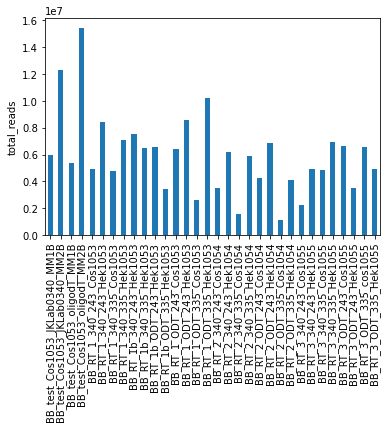

sa_reads


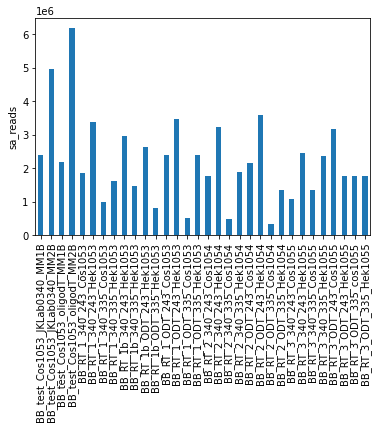

total_clipped


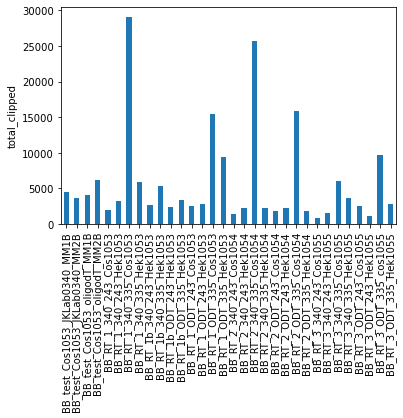

total_bad_starts


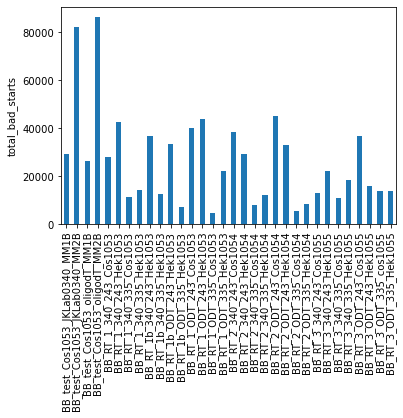

total_bad_ends


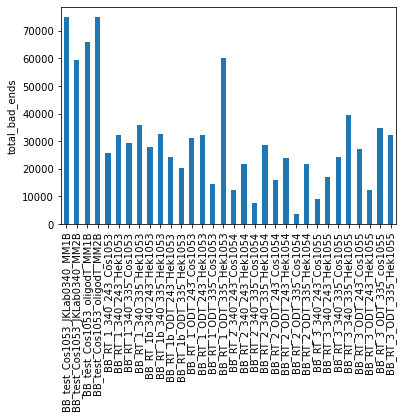

In [124]:
for col in reads_df:
    
    print( col )
    
    reads_df[ col ].plot.bar()
    
    plt.ylabel( col )
    
    plt.show()

sa_reads


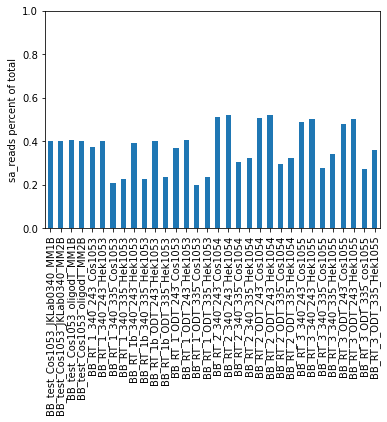

total_clipped


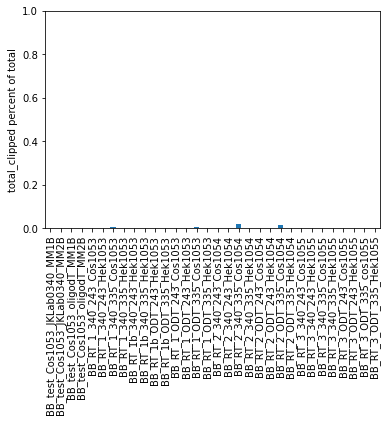

total_bad_starts


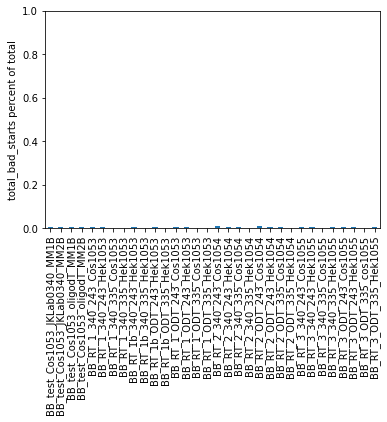

total_bad_ends


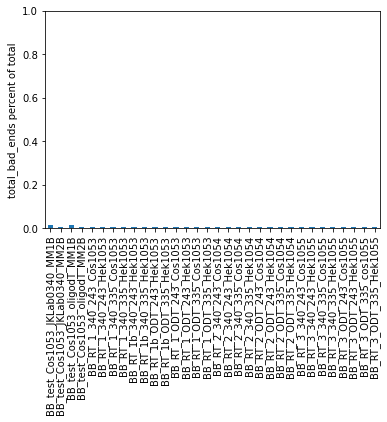

In [126]:
r_df = reads_df.copy()

for col in reads_df:
    
    if col == 'total_reads':
        continue
    
    print( col )
    
    r_df[ 'per_' + col ] = r_df[ col ] / r_df.total_reads
    
    r_df[ 'per_' + col ].plot.bar()
    
    plt.ylim( ( 0, 1 ) )
    
    plt.ylabel( col + ' percent of total' )
    
    plt.show()

In [130]:
total_cols = [ 'total_read_count', 'total_num_bcs', 'totalsum_sa_reads' 'total_num_vars', 'total_passfilt' ]

for col in total_cols:
    
    iso_df_stats_all[ col ] = iso_df_stats_all[ [ lcol for lcol in iso_df_stats_all if col + '_' in lcol ] ].sum( axis = 1 )

In [127]:
len( bam )

32

In [128]:
iso_df_stats_all.shape

(7352, 241)

In [131]:
iso_df_stats_all.query( 'total_passfilt > 0' ).shape

(473, 245)

In [132]:
iso_df_stats_all.query( 'total_passfilt >= 16' ).shape

(68, 245)

In [133]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

1.1257901513775952

In [134]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

98.60173941032993

In [137]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).totalsum_sa_reads.sum() / iso_df_stats_all.totalsum_sa_reads.sum() )*100

98.63807340114118

In [135]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

2.391724944440723

In [136]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

97.0093198321134

In [139]:
iso_df_stats_all.to_csv( bdout + 'wt1_ex9_isoforms_2022-0522.txt',
                         sep = '\t',
                         index = False )

In [140]:
reads_df.to_csv( bdout + 'wt1_ex9_read_cnts_2022-0522.txt',
                         sep = '\t',
                         index = False )

In [143]:
np.exp( 1.56 )

4.758821245137854